
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train MC and SARSA 
    - Compare which one performs better in training
    - Compare which one performs better on Test time period


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [19]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import sarsa_single_stock, on_policy_mc_control_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [2]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [4]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254773,-80.462511,16.129793,2.749560,2.861671,"[[0.0013489692062006661, 0.0004284121378810980...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839512,6287200,AMGN,2,0.156757,42.707026,40.853193,51.060601,51.523241,10.432018,41.058031,40.603774,"[[0.0013489692062006661, 0.0004284121378810980...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580749,9625600,AXP,2,-0.935583,18.646871,12.660475,42.554839,-75.437701,25.776759,15.744066,17.616376,"[[0.0013489692062006661, 0.0004284121378810980...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,-0.279799,32.174387,28.867828,47.440262,156.995125,5.366299,30.327213,32.389915,"[[0.0013489692062006661, 0.0004284121378810980...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608662,6277400,CAT,2,0.655611,30.348090,25.455644,51.205322,98.374205,26.331746,26.689549,26.423591,"[[0.0013489692062006661, 0.0004284121378810980...",tic AAPL AMGN AXP ...


In [5]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [6]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [8]:
EPISODES = 1000

In [9]:
sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [10]:
sarsa_post_training_env, sarsa_training_episodes, sarsa_Q = sarsa_single_stock(sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, aggressive=True)

Episode:   0%|          | 1/1000 [00:07<2:06:48,  7.62s/it]

begin_total_asset:1000000
end_total_asset:9661461.92191152
Sharpe:  1.048714293444311


Episode:   0%|          | 2/1000 [00:15<2:07:13,  7.65s/it]

begin_total_asset:1000000
end_total_asset:10236480.750490295
Sharpe:  1.067854232240004


Episode:   0%|          | 3/1000 [00:21<1:54:58,  6.92s/it]

begin_total_asset:1000000
end_total_asset:10501028.343752967
Sharpe:  1.0784318665071224


Episode:   0%|          | 4/1000 [00:27<1:47:38,  6.48s/it]

begin_total_asset:1000000
end_total_asset:5866586.996955747
Sharpe:  0.8290796807426396


Episode:   0%|          | 5/1000 [00:33<1:43:45,  6.26s/it]

begin_total_asset:1000000
end_total_asset:8391993.005832888
Sharpe:  0.9655291301637405


Episode:   1%|          | 6/1000 [00:38<1:40:49,  6.09s/it]

begin_total_asset:1000000
end_total_asset:5578117.2175702825
Sharpe:  0.7900143909375246


Episode:   1%|          | 7/1000 [00:44<1:40:02,  6.04s/it]

begin_total_asset:1000000
end_total_asset:6623058.303976051
Sharpe:  0.8711237431577213


Episode:   1%|          | 8/1000 [00:50<1:38:24,  5.95s/it]

begin_total_asset:1000000
end_total_asset:7813482.151568051
Sharpe:  0.9360790644440191


Episode:   1%|          | 9/1000 [00:56<1:37:40,  5.91s/it]

begin_total_asset:1000000
end_total_asset:8031198.768124945
Sharpe:  0.9468619843885805


Episode:   1%|          | 10/1000 [01:02<1:37:12,  5.89s/it]

begin_total_asset:1000000
end_total_asset:8687692.176137563
Sharpe:  0.969857084239187


Episode:   1%|          | 11/1000 [01:07<1:36:44,  5.87s/it]

begin_total_asset:1000000
end_total_asset:6503857.043820721
Sharpe:  0.8559183811417187


Episode:   1%|          | 12/1000 [01:13<1:36:18,  5.85s/it]

begin_total_asset:1000000
end_total_asset:8107580.851062723
Sharpe:  0.9531946738241373


Episode:   1%|▏         | 13/1000 [01:19<1:36:11,  5.85s/it]

begin_total_asset:1000000
end_total_asset:8503813.867843783
Sharpe:  0.9607186804220123


Episode:   1%|▏         | 14/1000 [01:25<1:36:50,  5.89s/it]

begin_total_asset:1000000
end_total_asset:12799335.806710554
Sharpe:  1.1361550205128943


Episode:   2%|▏         | 15/1000 [01:31<1:36:15,  5.86s/it]

begin_total_asset:1000000
end_total_asset:4457562.43172594
Sharpe:  0.7187313596122741


Episode:   2%|▏         | 16/1000 [01:37<1:35:46,  5.84s/it]

begin_total_asset:1000000
end_total_asset:8120029.40849764
Sharpe:  0.9626687987722565


Episode:   2%|▏         | 17/1000 [01:43<1:35:39,  5.84s/it]

begin_total_asset:1000000
end_total_asset:4820432.564440186
Sharpe:  0.7489311139234546


Episode:   2%|▏         | 18/1000 [01:48<1:35:12,  5.82s/it]

begin_total_asset:1000000
end_total_asset:10716260.72836333
Sharpe:  1.0846514285782263


Episode:   2%|▏         | 19/1000 [01:54<1:35:07,  5.82s/it]

begin_total_asset:1000000
end_total_asset:10257218.840245308
Sharpe:  1.0570359626230195


Episode:   2%|▏         | 20/1000 [02:00<1:35:13,  5.83s/it]

begin_total_asset:1000000
end_total_asset:7569312.161087405
Sharpe:  0.9193285254311044


Episode:   2%|▏         | 21/1000 [02:06<1:35:25,  5.85s/it]

begin_total_asset:1000000
end_total_asset:9073177.391855981
Sharpe:  1.0098208248676663


Episode:   2%|▏         | 22/1000 [02:12<1:35:24,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6449271.380126153
Sharpe:  0.8790526924625791


Episode:   2%|▏         | 23/1000 [02:18<1:35:14,  5.85s/it]

begin_total_asset:1000000
end_total_asset:5459204.923969932
Sharpe:  0.7933225840320564


Episode:   2%|▏         | 24/1000 [02:23<1:35:23,  5.86s/it]

begin_total_asset:1000000
end_total_asset:15330327.226410542
Sharpe:  1.2006118367181835


Episode:   2%|▎         | 25/1000 [02:29<1:35:13,  5.86s/it]

begin_total_asset:1000000
end_total_asset:6785213.20492307
Sharpe:  0.8910475890249135


Episode:   3%|▎         | 26/1000 [02:35<1:35:10,  5.86s/it]

begin_total_asset:1000000
end_total_asset:14207262.077007344
Sharpe:  1.1902868886281066


Episode:   3%|▎         | 27/1000 [02:41<1:34:59,  5.86s/it]

begin_total_asset:1000000
end_total_asset:11155469.633222938
Sharpe:  1.070086557811548


Episode:   3%|▎         | 28/1000 [02:47<1:34:58,  5.86s/it]

begin_total_asset:1000000
end_total_asset:14273221.869425286
Sharpe:  1.2042448869126638


Episode:   3%|▎         | 29/1000 [02:53<1:34:24,  5.83s/it]

begin_total_asset:1000000
end_total_asset:14638077.611393472
Sharpe:  1.236873597323887


Episode:   3%|▎         | 30/1000 [02:59<1:34:53,  5.87s/it]

begin_total_asset:1000000
end_total_asset:10268145.783078164
Sharpe:  1.079705058902555


Episode:   3%|▎         | 31/1000 [03:05<1:34:57,  5.88s/it]

begin_total_asset:1000000
end_total_asset:11979739.800269833
Sharpe:  1.114850204803832


Episode:   3%|▎         | 32/1000 [03:11<1:36:50,  6.00s/it]

begin_total_asset:1000000
end_total_asset:8788382.36660779
Sharpe:  1.0095963536943011


Episode:   3%|▎         | 33/1000 [03:17<1:36:47,  6.01s/it]

begin_total_asset:1000000
end_total_asset:7348049.001149399
Sharpe:  0.913637515117038


Episode:   3%|▎         | 34/1000 [03:23<1:39:51,  6.20s/it]

begin_total_asset:1000000
end_total_asset:10081510.471350094
Sharpe:  1.071669690944903


Episode:   4%|▎         | 35/1000 [03:30<1:42:05,  6.35s/it]

begin_total_asset:1000000
end_total_asset:15688683.444216825
Sharpe:  1.2687990018031596


Episode:   4%|▎         | 36/1000 [03:37<1:43:18,  6.43s/it]

begin_total_asset:1000000
end_total_asset:8423793.249678418
Sharpe:  1.001261087737748


Episode:   4%|▎         | 37/1000 [03:44<1:44:48,  6.53s/it]

begin_total_asset:1000000
end_total_asset:12917868.331447257
Sharpe:  1.1522852161679877


Episode:   4%|▍         | 38/1000 [03:50<1:42:42,  6.41s/it]

begin_total_asset:1000000
end_total_asset:11239050.892935174
Sharpe:  1.129891203093075


Episode:   4%|▍         | 39/1000 [03:56<1:39:46,  6.23s/it]

begin_total_asset:1000000
end_total_asset:13341728.972034073
Sharpe:  1.2320751143838726


Episode:   4%|▍         | 40/1000 [04:01<1:37:37,  6.10s/it]

begin_total_asset:1000000
end_total_asset:10736677.223435497
Sharpe:  1.0967550307463463


Episode:   4%|▍         | 41/1000 [04:07<1:36:47,  6.06s/it]

begin_total_asset:1000000
end_total_asset:18792843.529068686
Sharpe:  1.3387394393785843


Episode:   4%|▍         | 42/1000 [04:13<1:35:35,  5.99s/it]

begin_total_asset:1000000
end_total_asset:6183820.474037065
Sharpe:  0.8554084684379555


Episode:   4%|▍         | 43/1000 [04:19<1:34:58,  5.95s/it]

begin_total_asset:1000000
end_total_asset:8318518.330992775
Sharpe:  0.9715320554454583


Episode:   4%|▍         | 44/1000 [04:25<1:33:56,  5.90s/it]

begin_total_asset:1000000
end_total_asset:9914721.783426542
Sharpe:  1.0730296624531237


Episode:   4%|▍         | 45/1000 [04:31<1:33:42,  5.89s/it]

begin_total_asset:1000000
end_total_asset:10858813.809244998
Sharpe:  1.1115412250941428


Episode:   5%|▍         | 46/1000 [04:37<1:35:06,  5.98s/it]

begin_total_asset:1000000
end_total_asset:9337125.125478325
Sharpe:  1.0256389332081146


Episode:   5%|▍         | 47/1000 [04:43<1:34:15,  5.93s/it]

begin_total_asset:1000000
end_total_asset:15155619.616366722
Sharpe:  1.2590237901397892


Episode:   5%|▍         | 48/1000 [04:48<1:33:54,  5.92s/it]

begin_total_asset:1000000
end_total_asset:7984427.9409747
Sharpe:  0.9893342608988571


Episode:   5%|▍         | 49/1000 [04:55<1:34:20,  5.95s/it]

begin_total_asset:1000000
end_total_asset:7675028.9041808415
Sharpe:  0.9375481061866101


Episode:   5%|▌         | 50/1000 [05:01<1:37:49,  6.18s/it]

begin_total_asset:1000000
end_total_asset:10127062.865128554
Sharpe:  1.0948066919876824


Episode:   5%|▌         | 51/1000 [05:07<1:36:14,  6.08s/it]

begin_total_asset:1000000
end_total_asset:14817942.600331686
Sharpe:  1.220300949354815


Episode:   5%|▌         | 52/1000 [05:13<1:34:46,  6.00s/it]

begin_total_asset:1000000
end_total_asset:9029815.4278606
Sharpe:  1.0321687007629914


Episode:   5%|▌         | 53/1000 [05:19<1:34:15,  5.97s/it]

begin_total_asset:1000000
end_total_asset:9230110.980743706
Sharpe:  1.0417043745082295


Episode:   5%|▌         | 54/1000 [05:25<1:34:24,  5.99s/it]

begin_total_asset:1000000
end_total_asset:8621536.080021927
Sharpe:  1.0295919869850234


Episode:   6%|▌         | 55/1000 [05:31<1:33:47,  5.95s/it]

begin_total_asset:1000000
end_total_asset:12511184.24197681
Sharpe:  1.1555838187117307


Episode:   6%|▌         | 56/1000 [05:37<1:35:07,  6.05s/it]

begin_total_asset:1000000
end_total_asset:5120262.740662121
Sharpe:  0.7897440362139011


Episode:   6%|▌         | 57/1000 [05:43<1:34:40,  6.02s/it]

begin_total_asset:1000000
end_total_asset:5152832.306447684
Sharpe:  0.7711284004358571


Episode:   6%|▌         | 58/1000 [05:49<1:33:49,  5.98s/it]

begin_total_asset:1000000
end_total_asset:5501328.766737749
Sharpe:  0.8295642298991441


Episode:   6%|▌         | 59/1000 [05:55<1:33:50,  5.98s/it]

begin_total_asset:1000000
end_total_asset:6318190.176991537
Sharpe:  0.8830012393128177


Episode:   6%|▌         | 60/1000 [06:01<1:33:38,  5.98s/it]

begin_total_asset:1000000
end_total_asset:9879227.399892243
Sharpe:  1.0534389850120203


Episode:   6%|▌         | 61/1000 [06:07<1:33:36,  5.98s/it]

begin_total_asset:1000000
end_total_asset:7683606.659917583
Sharpe:  0.9545566482232395


Episode:   6%|▌         | 62/1000 [06:13<1:33:08,  5.96s/it]

begin_total_asset:1000000
end_total_asset:8970568.387543365
Sharpe:  1.047598408683835


Episode:   6%|▋         | 63/1000 [06:19<1:32:42,  5.94s/it]

begin_total_asset:1000000
end_total_asset:8955328.305563752
Sharpe:  1.023544606905149


Episode:   6%|▋         | 64/1000 [06:24<1:32:36,  5.94s/it]

begin_total_asset:1000000
end_total_asset:6787076.545929293
Sharpe:  0.9188713535568718


Episode:   6%|▋         | 65/1000 [06:30<1:32:19,  5.92s/it]

begin_total_asset:1000000
end_total_asset:9304093.653071536
Sharpe:  1.056625543995041


Episode:   7%|▋         | 66/1000 [06:36<1:33:05,  5.98s/it]

begin_total_asset:1000000
end_total_asset:4458797.764563939
Sharpe:  0.7288708431209118


Episode:   7%|▋         | 67/1000 [06:42<1:32:31,  5.95s/it]

begin_total_asset:1000000
end_total_asset:10191520.261784835
Sharpe:  1.0705222176933045


Episode:   7%|▋         | 68/1000 [06:48<1:33:00,  5.99s/it]

begin_total_asset:1000000
end_total_asset:10062858.344969146
Sharpe:  1.096669523620353


Episode:   7%|▋         | 69/1000 [06:54<1:32:49,  5.98s/it]

begin_total_asset:1000000
end_total_asset:13009313.105719253
Sharpe:  1.1761240164114697


Episode:   7%|▋         | 70/1000 [07:00<1:32:26,  5.96s/it]

begin_total_asset:1000000
end_total_asset:6299277.982100539
Sharpe:  0.879399344825033


Episode:   7%|▋         | 71/1000 [07:06<1:32:04,  5.95s/it]

begin_total_asset:1000000
end_total_asset:17533229.017889354
Sharpe:  1.3104838586951288


Episode:   7%|▋         | 72/1000 [07:12<1:31:34,  5.92s/it]

begin_total_asset:1000000
end_total_asset:13826988.97634714
Sharpe:  1.2135286552887312


Episode:   7%|▋         | 73/1000 [07:18<1:31:13,  5.90s/it]

begin_total_asset:1000000
end_total_asset:14057787.616986286
Sharpe:  1.2212015488476016


Episode:   7%|▋         | 74/1000 [07:24<1:31:08,  5.91s/it]

begin_total_asset:1000000
end_total_asset:15718094.576803701
Sharpe:  1.2480011429845967


Episode:   8%|▊         | 75/1000 [07:30<1:31:15,  5.92s/it]

begin_total_asset:1000000
end_total_asset:8297761.724611775
Sharpe:  1.0062049466152971


Episode:   8%|▊         | 76/1000 [07:36<1:31:11,  5.92s/it]

begin_total_asset:1000000
end_total_asset:11093687.371888876
Sharpe:  1.1040528658816295


Episode:   8%|▊         | 77/1000 [07:42<1:31:44,  5.96s/it]

begin_total_asset:1000000
end_total_asset:15724213.875193989
Sharpe:  1.2631922741616377


Episode:   8%|▊         | 78/1000 [07:48<1:31:28,  5.95s/it]

begin_total_asset:1000000
end_total_asset:11911445.737695612
Sharpe:  1.1732487880658207


Episode:   8%|▊         | 79/1000 [07:54<1:33:18,  6.08s/it]

begin_total_asset:1000000
end_total_asset:10326018.00912585
Sharpe:  1.095962045136401


Episode:   8%|▊         | 80/1000 [08:00<1:32:32,  6.04s/it]

begin_total_asset:1000000
end_total_asset:11221332.029096305
Sharpe:  1.1207392904636717


Episode:   8%|▊         | 81/1000 [08:06<1:32:04,  6.01s/it]

begin_total_asset:1000000
end_total_asset:7579258.693850673
Sharpe:  0.9836214555107834


Episode:   8%|▊         | 82/1000 [08:12<1:31:26,  5.98s/it]

begin_total_asset:1000000
end_total_asset:8532936.365465228
Sharpe:  1.0137938935800537


Episode:   8%|▊         | 83/1000 [08:18<1:31:18,  5.97s/it]

begin_total_asset:1000000
end_total_asset:8532181.110509863
Sharpe:  1.0271436765613464


Episode:   8%|▊         | 84/1000 [08:24<1:30:38,  5.94s/it]

begin_total_asset:1000000
end_total_asset:7822337.209601674
Sharpe:  0.9654122402502411


Episode:   8%|▊         | 85/1000 [08:30<1:31:02,  5.97s/it]

begin_total_asset:1000000
end_total_asset:7014699.299389152
Sharpe:  0.9289064332970781


Episode:   9%|▊         | 86/1000 [08:36<1:30:55,  5.97s/it]

begin_total_asset:1000000
end_total_asset:12815815.58393011
Sharpe:  1.175909900614651


Episode:   9%|▊         | 87/1000 [08:42<1:30:39,  5.96s/it]

begin_total_asset:1000000
end_total_asset:10267173.486469986
Sharpe:  1.0666200008920521


Episode:   9%|▉         | 88/1000 [08:48<1:30:18,  5.94s/it]

begin_total_asset:1000000
end_total_asset:6039845.889932377
Sharpe:  0.879742421603797


Episode:   9%|▉         | 89/1000 [08:54<1:30:25,  5.96s/it]

begin_total_asset:1000000
end_total_asset:10113441.438482158
Sharpe:  1.1164564477621552


Episode:   9%|▉         | 90/1000 [09:00<1:30:27,  5.96s/it]

begin_total_asset:1000000
end_total_asset:8532112.763490034
Sharpe:  1.0448787180173538


Episode:   9%|▉         | 91/1000 [09:05<1:29:51,  5.93s/it]

begin_total_asset:1000000
end_total_asset:12908402.209563438
Sharpe:  1.2447473492025738


Episode:   9%|▉         | 92/1000 [09:11<1:29:45,  5.93s/it]

begin_total_asset:1000000
end_total_asset:6054541.96649921
Sharpe:  0.9117192252184053


Episode:   9%|▉         | 93/1000 [09:17<1:29:30,  5.92s/it]

begin_total_asset:1000000
end_total_asset:9089374.390148293
Sharpe:  1.0471039970379799


Episode:   9%|▉         | 94/1000 [09:23<1:29:27,  5.92s/it]

begin_total_asset:1000000
end_total_asset:6715613.250311777
Sharpe:  0.9159970983959405


Episode:  10%|▉         | 95/1000 [09:29<1:29:45,  5.95s/it]

begin_total_asset:1000000
end_total_asset:18651954.176897194
Sharpe:  1.3611494350413873


Episode:  10%|▉         | 96/1000 [09:35<1:29:28,  5.94s/it]

begin_total_asset:1000000
end_total_asset:8985776.864549104
Sharpe:  1.032450890925205


Episode:  10%|▉         | 97/1000 [09:41<1:29:14,  5.93s/it]

begin_total_asset:1000000
end_total_asset:14416872.95145221
Sharpe:  1.276982726272306


Episode:  10%|▉         | 98/1000 [09:47<1:29:03,  5.92s/it]

begin_total_asset:1000000
end_total_asset:10151803.850707175
Sharpe:  1.0989261684944471


Episode:  10%|▉         | 99/1000 [09:53<1:28:40,  5.91s/it]

begin_total_asset:1000000
end_total_asset:10060266.956708463
Sharpe:  1.0700476011019024


Episode:  10%|█         | 100/1000 [09:59<1:28:35,  5.91s/it]

begin_total_asset:1000000
end_total_asset:12078725.640748285
Sharpe:  1.1949513037642652


Episode:  10%|█         | 101/1000 [10:05<1:28:49,  5.93s/it]

begin_total_asset:1000000
end_total_asset:10449547.502653103
Sharpe:  1.1196049202912641


Episode:  10%|█         | 102/1000 [10:11<1:29:15,  5.96s/it]

begin_total_asset:1000000
end_total_asset:8209603.606894783
Sharpe:  1.009043693917278


Episode:  10%|█         | 103/1000 [10:17<1:29:07,  5.96s/it]

begin_total_asset:1000000
end_total_asset:9535096.418906197
Sharpe:  1.0615793360967845


Episode:  10%|█         | 104/1000 [10:23<1:28:39,  5.94s/it]

begin_total_asset:1000000
end_total_asset:6371937.816741388
Sharpe:  0.8969635493822337


Episode:  10%|█         | 105/1000 [10:28<1:28:36,  5.94s/it]

begin_total_asset:1000000
end_total_asset:10794816.148780186
Sharpe:  1.125789366291512


Episode:  11%|█         | 106/1000 [10:35<1:29:44,  6.02s/it]

begin_total_asset:1000000
end_total_asset:7140074.098829385
Sharpe:  0.949755040511222


Episode:  11%|█         | 107/1000 [10:41<1:29:09,  5.99s/it]

begin_total_asset:1000000
end_total_asset:5044749.617970036
Sharpe:  0.7935361978890195


Episode:  11%|█         | 108/1000 [10:47<1:28:42,  5.97s/it]

begin_total_asset:1000000
end_total_asset:7636384.659871182
Sharpe:  0.9885464595254152


Episode:  11%|█         | 109/1000 [10:52<1:28:10,  5.94s/it]

begin_total_asset:1000000
end_total_asset:5424704.79914235
Sharpe:  0.8124795554181236


Episode:  11%|█         | 110/1000 [10:58<1:28:27,  5.96s/it]

begin_total_asset:1000000
end_total_asset:9893278.400486749
Sharpe:  1.079549202495689


Episode:  11%|█         | 111/1000 [11:04<1:28:27,  5.97s/it]

begin_total_asset:1000000
end_total_asset:8610593.67292437
Sharpe:  0.9933135377231261


Episode:  11%|█         | 112/1000 [11:10<1:28:34,  5.98s/it]

begin_total_asset:1000000
end_total_asset:5659490.556075598
Sharpe:  0.8626750485788435


Episode:  11%|█▏        | 113/1000 [11:16<1:28:31,  5.99s/it]

begin_total_asset:1000000
end_total_asset:6534221.376581782
Sharpe:  0.8999150323378591


Episode:  11%|█▏        | 114/1000 [11:22<1:28:34,  6.00s/it]

begin_total_asset:1000000
end_total_asset:9436695.363334958
Sharpe:  1.0371196693317668


Episode:  12%|█▏        | 115/1000 [11:28<1:28:40,  6.01s/it]

begin_total_asset:1000000
end_total_asset:7717336.66454534
Sharpe:  0.9566920755462662


Episode:  12%|█▏        | 116/1000 [11:36<1:35:52,  6.51s/it]

begin_total_asset:1000000
end_total_asset:4092832.56048682
Sharpe:  0.6757414819153198


Episode:  12%|█▏        | 117/1000 [11:42<1:33:15,  6.34s/it]

begin_total_asset:1000000
end_total_asset:6659663.522066116
Sharpe:  0.8883577601408437


Episode:  12%|█▏        | 118/1000 [11:48<1:31:30,  6.22s/it]

begin_total_asset:1000000
end_total_asset:6015078.727358784
Sharpe:  0.8446702344504938


Episode:  12%|█▏        | 119/1000 [11:54<1:29:13,  6.08s/it]

begin_total_asset:1000000
end_total_asset:5321037.806903696
Sharpe:  0.79399483878889


Episode:  12%|█▏        | 120/1000 [11:59<1:27:13,  5.95s/it]

begin_total_asset:1000000
end_total_asset:3620233.0338300536
Sharpe:  0.6363367945768441


Episode:  12%|█▏        | 121/1000 [12:05<1:25:35,  5.84s/it]

begin_total_asset:1000000
end_total_asset:3783365.180475644
Sharpe:  0.6640932961975161


Episode:  12%|█▏        | 122/1000 [12:11<1:24:12,  5.75s/it]

begin_total_asset:1000000
end_total_asset:7151553.441871086
Sharpe:  0.9241827768960488


Episode:  12%|█▏        | 123/1000 [12:16<1:23:49,  5.73s/it]

begin_total_asset:1000000
end_total_asset:4483063.9379836125
Sharpe:  0.7437535892750418


Episode:  12%|█▏        | 124/1000 [12:22<1:23:09,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5856176.561296454
Sharpe:  0.8351872997209683


Episode:  12%|█▎        | 125/1000 [12:28<1:23:03,  5.70s/it]

begin_total_asset:1000000
end_total_asset:4385435.943472846
Sharpe:  0.7310142777767299


Episode:  13%|█▎        | 126/1000 [12:33<1:23:21,  5.72s/it]

begin_total_asset:1000000
end_total_asset:8008207.039272633
Sharpe:  1.0070487215612525


Episode:  13%|█▎        | 127/1000 [12:39<1:22:51,  5.69s/it]

begin_total_asset:1000000
end_total_asset:6287762.81550378
Sharpe:  0.8888834160635333


Episode:  13%|█▎        | 128/1000 [12:45<1:22:27,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9128959.255936122
Sharpe:  1.036850224503627


Episode:  13%|█▎        | 129/1000 [12:51<1:23:54,  5.78s/it]

begin_total_asset:1000000
end_total_asset:4707517.408948306
Sharpe:  0.7845272555120035


Episode:  13%|█▎        | 130/1000 [12:57<1:24:21,  5.82s/it]

begin_total_asset:1000000
end_total_asset:4260396.961139751
Sharpe:  0.7266065798561725


Episode:  13%|█▎        | 131/1000 [13:02<1:23:30,  5.77s/it]

begin_total_asset:1000000
end_total_asset:3674203.0114208004
Sharpe:  0.6528960560304925


Episode:  13%|█▎        | 132/1000 [13:08<1:22:38,  5.71s/it]

begin_total_asset:1000000
end_total_asset:3648896.0147653725
Sharpe:  0.6717711912613247


Episode:  13%|█▎        | 133/1000 [13:13<1:22:11,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4114535.192487237
Sharpe:  0.7200917041755447


Episode:  13%|█▎        | 134/1000 [13:19<1:22:31,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3697189.554310577
Sharpe:  0.6748993352895583


Episode:  14%|█▎        | 135/1000 [13:25<1:22:59,  5.76s/it]

begin_total_asset:1000000
end_total_asset:4353596.02170448
Sharpe:  0.7422172607926235


Episode:  14%|█▎        | 136/1000 [13:31<1:23:10,  5.78s/it]

begin_total_asset:1000000
end_total_asset:3264871.268080044
Sharpe:  0.6121486615218279


Episode:  14%|█▎        | 137/1000 [13:37<1:22:48,  5.76s/it]

begin_total_asset:1000000
end_total_asset:4522371.480693546
Sharpe:  0.7855057009959816


Episode:  14%|█▍        | 138/1000 [13:42<1:22:40,  5.76s/it]

begin_total_asset:1000000
end_total_asset:2399332.615743251
Sharpe:  0.49184338486655466


Episode:  14%|█▍        | 139/1000 [13:48<1:22:14,  5.73s/it]

begin_total_asset:1000000
end_total_asset:3773258.896011927
Sharpe:  0.6780767011270739


Episode:  14%|█▍        | 140/1000 [13:54<1:21:25,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5143306.065918714
Sharpe:  0.803465416073522


Episode:  14%|█▍        | 141/1000 [13:59<1:21:41,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4117851.748258831
Sharpe:  0.7089308303597847


Episode:  14%|█▍        | 142/1000 [14:05<1:20:58,  5.66s/it]

begin_total_asset:1000000
end_total_asset:2748585.211675943
Sharpe:  0.5388042110036075


Episode:  14%|█▍        | 143/1000 [14:10<1:20:37,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5112628.879927633
Sharpe:  0.8194761667304568


Episode:  14%|█▍        | 144/1000 [14:16<1:20:16,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4729657.863382284
Sharpe:  0.7819074603590699


Episode:  14%|█▍        | 145/1000 [14:22<1:19:45,  5.60s/it]

begin_total_asset:1000000
end_total_asset:8294510.1390052
Sharpe:  0.9868870049877425


Episode:  15%|█▍        | 146/1000 [14:27<1:20:28,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6133130.439674645
Sharpe:  0.9029539764142889


Episode:  15%|█▍        | 147/1000 [14:33<1:20:57,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8467324.277704662
Sharpe:  1.034648292050538


Episode:  15%|█▍        | 148/1000 [14:39<1:21:00,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8742153.887765195
Sharpe:  1.0759424246846683


Episode:  15%|█▍        | 149/1000 [14:45<1:20:56,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4946455.437941633
Sharpe:  0.8002009759839845


Episode:  15%|█▌        | 150/1000 [14:50<1:20:32,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8341852.153318896
Sharpe:  1.042454469786508


Episode:  15%|█▌        | 151/1000 [14:56<1:20:29,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8260374.709701326
Sharpe:  1.0272730314446534


Episode:  15%|█▌        | 152/1000 [15:02<1:20:09,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9520631.109709548
Sharpe:  1.0532663541143157


Episode:  15%|█▌        | 153/1000 [15:08<1:21:37,  5.78s/it]

begin_total_asset:1000000
end_total_asset:5653320.02528184
Sharpe:  0.850356574409272


Episode:  15%|█▌        | 154/1000 [15:14<1:23:40,  5.93s/it]

begin_total_asset:1000000
end_total_asset:5368400.815120722
Sharpe:  0.831659405872433


Episode:  16%|█▌        | 155/1000 [15:20<1:24:35,  6.01s/it]

begin_total_asset:1000000
end_total_asset:7615760.189823368
Sharpe:  0.9594199471436236


Episode:  16%|█▌        | 156/1000 [15:26<1:22:57,  5.90s/it]

begin_total_asset:1000000
end_total_asset:8455170.532555128
Sharpe:  1.0259550549977507


Episode:  16%|█▌        | 157/1000 [15:31<1:22:02,  5.84s/it]

begin_total_asset:1000000
end_total_asset:9338160.031868128
Sharpe:  1.0677352508355784


Episode:  16%|█▌        | 158/1000 [15:37<1:20:59,  5.77s/it]

begin_total_asset:1000000
end_total_asset:5334407.453920673
Sharpe:  0.8335246515727671


Episode:  16%|█▌        | 159/1000 [15:43<1:19:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6120980.968187495
Sharpe:  0.8744666889611437


Episode:  16%|█▌        | 160/1000 [15:48<1:19:30,  5.68s/it]

begin_total_asset:1000000
end_total_asset:11852548.379147738
Sharpe:  1.1441393233454622


Episode:  16%|█▌        | 161/1000 [15:54<1:18:53,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8562815.66106834
Sharpe:  1.0172716655149965


Episode:  16%|█▌        | 162/1000 [15:59<1:18:38,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8596031.365397435
Sharpe:  1.0327189839902051


Episode:  16%|█▋        | 163/1000 [16:05<1:18:31,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8712300.464282578
Sharpe:  1.027647659883523


Episode:  16%|█▋        | 164/1000 [16:11<1:18:30,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5735568.557816685
Sharpe:  0.8508458498622556


Episode:  16%|█▋        | 165/1000 [16:16<1:18:04,  5.61s/it]

begin_total_asset:1000000
end_total_asset:6288521.740388998
Sharpe:  0.8934482616338031


Episode:  17%|█▋        | 166/1000 [16:22<1:17:36,  5.58s/it]

begin_total_asset:1000000
end_total_asset:10615738.648032738
Sharpe:  1.1124518844907978


Episode:  17%|█▋        | 167/1000 [16:27<1:17:13,  5.56s/it]

begin_total_asset:1000000
end_total_asset:7488813.95606092
Sharpe:  0.9544254305311382


Episode:  17%|█▋        | 168/1000 [16:33<1:17:08,  5.56s/it]

begin_total_asset:1000000
end_total_asset:6741766.847293242
Sharpe:  0.9069451115464725


Episode:  17%|█▋        | 169/1000 [16:38<1:17:04,  5.56s/it]

begin_total_asset:1000000
end_total_asset:5761383.360945173
Sharpe:  0.8670863661085847


Episode:  17%|█▋        | 170/1000 [16:44<1:17:20,  5.59s/it]

begin_total_asset:1000000
end_total_asset:24527771.998283215
Sharpe:  1.429754435655342


Episode:  17%|█▋        | 171/1000 [16:50<1:17:49,  5.63s/it]

begin_total_asset:1000000
end_total_asset:10627428.103865951
Sharpe:  1.0874657638256233


Episode:  17%|█▋        | 172/1000 [16:56<1:18:37,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7057433.64403816
Sharpe:  0.9250815213572376


Episode:  17%|█▋        | 173/1000 [17:01<1:18:08,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12519603.321498001
Sharpe:  1.20912113630555


Episode:  17%|█▋        | 174/1000 [17:07<1:17:59,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9814169.975190816
Sharpe:  1.105184417845154


Episode:  18%|█▊        | 175/1000 [17:12<1:17:25,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8259342.747890781
Sharpe:  1.0100055589770967


Episode:  18%|█▊        | 176/1000 [17:18<1:17:05,  5.61s/it]

begin_total_asset:1000000
end_total_asset:11254590.707683112
Sharpe:  1.1264173253325556


Episode:  18%|█▊        | 177/1000 [17:24<1:16:48,  5.60s/it]

begin_total_asset:1000000
end_total_asset:3780348.4392819772
Sharpe:  0.6668303374754887


Episode:  18%|█▊        | 178/1000 [17:29<1:16:31,  5.59s/it]

begin_total_asset:1000000
end_total_asset:4036762.8191625187
Sharpe:  0.6988793123912207


Episode:  18%|█▊        | 179/1000 [17:35<1:16:55,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4035075.465087462
Sharpe:  0.6870980775507783


Episode:  18%|█▊        | 180/1000 [17:41<1:17:45,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4545057.338973718
Sharpe:  0.7352672309318


Episode:  18%|█▊        | 181/1000 [17:46<1:17:50,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7251705.397581436
Sharpe:  0.9710200932130407


Episode:  18%|█▊        | 182/1000 [17:52<1:18:13,  5.74s/it]

begin_total_asset:1000000
end_total_asset:5937964.7446048735
Sharpe:  0.8705340109395634


Episode:  18%|█▊        | 183/1000 [17:58<1:17:25,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5889005.384989507
Sharpe:  0.8643278947931535


Episode:  18%|█▊        | 184/1000 [18:03<1:16:58,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6669922.835557353
Sharpe:  0.9208287088327782


Episode:  18%|█▊        | 185/1000 [18:09<1:16:20,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5947077.556020406
Sharpe:  0.8421691573590737


Episode:  19%|█▊        | 186/1000 [18:14<1:16:11,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4610937.442339331
Sharpe:  0.7380970883399818


Episode:  19%|█▊        | 187/1000 [18:20<1:16:22,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5458314.129088867
Sharpe:  0.8427028185189884


Episode:  19%|█▉        | 188/1000 [18:26<1:16:50,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8352989.807304884
Sharpe:  0.9899098611918274


Episode:  19%|█▉        | 189/1000 [18:32<1:17:34,  5.74s/it]

begin_total_asset:1000000
end_total_asset:12088027.024634635
Sharpe:  1.1613730338713006


Episode:  19%|█▉        | 190/1000 [18:38<1:18:21,  5.80s/it]

begin_total_asset:1000000
end_total_asset:5141424.042926911
Sharpe:  0.7904202895322398


Episode:  19%|█▉        | 191/1000 [18:44<1:18:10,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4721784.188756253
Sharpe:  0.7638103435016167


Episode:  19%|█▉        | 192/1000 [18:49<1:17:40,  5.77s/it]

begin_total_asset:1000000
end_total_asset:3243027.381689457
Sharpe:  0.6102407844840246


Episode:  19%|█▉        | 193/1000 [18:55<1:17:57,  5.80s/it]

begin_total_asset:1000000
end_total_asset:2591478.684829435
Sharpe:  0.5154308575052474


Episode:  19%|█▉        | 194/1000 [19:01<1:16:55,  5.73s/it]

begin_total_asset:1000000
end_total_asset:4382732.961555702
Sharpe:  0.7371614947869324


Episode:  20%|█▉        | 195/1000 [19:06<1:16:18,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10946956.103704983
Sharpe:  1.0745729925384886


Episode:  20%|█▉        | 196/1000 [19:12<1:16:07,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8473886.238465937
Sharpe:  1.016553399420557


Episode:  20%|█▉        | 197/1000 [19:18<1:15:32,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7674077.934383789
Sharpe:  0.9469362538273763


Episode:  20%|█▉        | 198/1000 [19:23<1:15:54,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3750946.9660198805
Sharpe:  0.6616095446560256


Episode:  20%|█▉        | 199/1000 [19:29<1:15:26,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5105807.947832671
Sharpe:  0.8153816171956579


Episode:  20%|██        | 200/1000 [19:34<1:15:04,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3468765.692033383
Sharpe:  0.6310200310436743


Episode:  20%|██        | 201/1000 [19:40<1:14:41,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7231138.704298987
Sharpe:  0.949435088987635


Episode:  20%|██        | 202/1000 [19:46<1:14:41,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6312480.900699588
Sharpe:  0.8954649996230434


Episode:  20%|██        | 203/1000 [19:51<1:14:49,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3534178.7989203837
Sharpe:  0.6368932093936936


Episode:  20%|██        | 204/1000 [19:58<1:16:59,  5.80s/it]

begin_total_asset:1000000
end_total_asset:6875000.032777645
Sharpe:  0.9299923210997907


Episode:  20%|██        | 205/1000 [20:04<1:17:42,  5.87s/it]

begin_total_asset:1000000
end_total_asset:5550383.387528965
Sharpe:  0.843815676219882


Episode:  21%|██        | 206/1000 [20:09<1:17:04,  5.82s/it]

begin_total_asset:1000000
end_total_asset:4658067.561852298
Sharpe:  0.77047437171071


Episode:  21%|██        | 207/1000 [20:15<1:16:55,  5.82s/it]

begin_total_asset:1000000
end_total_asset:5226604.641198644
Sharpe:  0.7978436933671252


Episode:  21%|██        | 208/1000 [20:21<1:16:54,  5.83s/it]

begin_total_asset:1000000
end_total_asset:5184071.183497593
Sharpe:  0.8030964237751286


Episode:  21%|██        | 209/1000 [20:27<1:16:11,  5.78s/it]

begin_total_asset:1000000
end_total_asset:5995572.030006166
Sharpe:  0.8535422910228024


Episode:  21%|██        | 210/1000 [20:32<1:15:53,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6361947.990568382
Sharpe:  0.9103345080399101


Episode:  21%|██        | 211/1000 [20:38<1:15:29,  5.74s/it]

begin_total_asset:1000000
end_total_asset:5230084.9014089145
Sharpe:  0.8244643865602671


Episode:  21%|██        | 212/1000 [20:44<1:14:55,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6454321.532293199
Sharpe:  0.9459317912328103


Episode:  21%|██▏       | 213/1000 [20:49<1:14:07,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4777652.811905012
Sharpe:  0.7590926369763622


Episode:  21%|██▏       | 214/1000 [20:55<1:13:50,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3607005.5530300224
Sharpe:  0.6486109535735459


Episode:  22%|██▏       | 215/1000 [21:00<1:13:18,  5.60s/it]

begin_total_asset:1000000
end_total_asset:4097961.104028638
Sharpe:  0.7154997398323361


Episode:  22%|██▏       | 216/1000 [21:06<1:13:12,  5.60s/it]

begin_total_asset:1000000
end_total_asset:7290944.938603691
Sharpe:  0.9860593835863756


Episode:  22%|██▏       | 217/1000 [21:12<1:13:44,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6217669.060109527
Sharpe:  0.9198698512133279


Episode:  22%|██▏       | 218/1000 [21:17<1:13:29,  5.64s/it]

begin_total_asset:1000000
end_total_asset:9776642.681754656
Sharpe:  1.1402021912229605


Episode:  22%|██▏       | 219/1000 [21:23<1:13:18,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8053969.491696576
Sharpe:  1.0239393813545061


Episode:  22%|██▏       | 220/1000 [21:29<1:13:35,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4924472.635377352
Sharpe:  0.8037126602454377


Episode:  22%|██▏       | 221/1000 [21:34<1:13:25,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5252012.842606038
Sharpe:  0.8321403462402568


Episode:  22%|██▏       | 222/1000 [21:40<1:14:32,  5.75s/it]

begin_total_asset:1000000
end_total_asset:10479669.17917932
Sharpe:  1.1428558167899348


Episode:  22%|██▏       | 223/1000 [21:46<1:13:50,  5.70s/it]

begin_total_asset:1000000
end_total_asset:10571141.049970884
Sharpe:  1.1394078989177276


Episode:  22%|██▏       | 224/1000 [21:51<1:13:45,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5461434.192360151
Sharpe:  0.8672100226376716


Episode:  22%|██▎       | 225/1000 [21:57<1:13:05,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4505734.571020253
Sharpe:  0.7845686872315554


Episode:  23%|██▎       | 226/1000 [22:03<1:12:45,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5947528.728036997
Sharpe:  0.8429877065168465


Episode:  23%|██▎       | 227/1000 [22:08<1:12:27,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6810305.344222024
Sharpe:  0.9326847004800912


Episode:  23%|██▎       | 228/1000 [22:14<1:12:42,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6845606.323636706
Sharpe:  0.9608217944904764


Episode:  23%|██▎       | 229/1000 [22:19<1:12:09,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6425894.072966929
Sharpe:  0.9157098334946646


Episode:  23%|██▎       | 230/1000 [22:25<1:11:54,  5.60s/it]

begin_total_asset:1000000
end_total_asset:2743179.3401032607
Sharpe:  0.5380888900594625


Episode:  23%|██▎       | 231/1000 [22:31<1:11:56,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7474494.063523075
Sharpe:  0.9950877621040668


Episode:  23%|██▎       | 232/1000 [22:36<1:11:48,  5.61s/it]

begin_total_asset:1000000
end_total_asset:5644305.747247741
Sharpe:  0.8547846522359026


Episode:  23%|██▎       | 233/1000 [22:42<1:11:28,  5.59s/it]

begin_total_asset:1000000
end_total_asset:5097951.714678316
Sharpe:  0.8138734317984911


Episode:  23%|██▎       | 234/1000 [22:47<1:11:12,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5600346.839141433
Sharpe:  0.8338304778025132


Episode:  24%|██▎       | 235/1000 [22:53<1:12:11,  5.66s/it]

begin_total_asset:1000000
end_total_asset:2124744.8796079624
Sharpe:  0.42562511955913035


Episode:  24%|██▎       | 236/1000 [22:59<1:11:55,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5900096.184304996
Sharpe:  0.8705972122186213


Episode:  24%|██▎       | 237/1000 [23:04<1:11:47,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3930390.0100005656
Sharpe:  0.6939460279934653


Episode:  24%|██▍       | 238/1000 [23:10<1:11:24,  5.62s/it]

begin_total_asset:1000000
end_total_asset:3049521.692365314
Sharpe:  0.5959813629763367


Episode:  24%|██▍       | 239/1000 [23:16<1:12:47,  5.74s/it]

begin_total_asset:1000000
end_total_asset:2174340.492860763
Sharpe:  0.4488969706118351


Episode:  24%|██▍       | 240/1000 [23:23<1:16:01,  6.00s/it]

begin_total_asset:1000000
end_total_asset:4705164.133364169
Sharpe:  0.786754558194666


Episode:  24%|██▍       | 241/1000 [23:29<1:15:21,  5.96s/it]

begin_total_asset:1000000
end_total_asset:5307688.38100092
Sharpe:  0.820847980165274


Episode:  24%|██▍       | 242/1000 [23:34<1:13:54,  5.85s/it]

begin_total_asset:1000000
end_total_asset:4137316.8631622605
Sharpe:  0.7402718017066428


Episode:  24%|██▍       | 243/1000 [23:40<1:13:14,  5.80s/it]

begin_total_asset:1000000
end_total_asset:6776337.335834184
Sharpe:  0.92250933824082


Episode:  24%|██▍       | 244/1000 [23:46<1:13:22,  5.82s/it]

begin_total_asset:1000000
end_total_asset:5515353.565555639
Sharpe:  0.8547462671218741


Episode:  24%|██▍       | 245/1000 [23:52<1:13:43,  5.86s/it]

begin_total_asset:1000000
end_total_asset:9777292.170088679
Sharpe:  1.059154904027382


Episode:  25%|██▍       | 246/1000 [23:57<1:12:43,  5.79s/it]

begin_total_asset:1000000
end_total_asset:5242284.083311413
Sharpe:  0.8339541599566508


Episode:  25%|██▍       | 247/1000 [24:03<1:11:49,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5774437.305392726
Sharpe:  0.8570799999315827


Episode:  25%|██▍       | 248/1000 [24:08<1:11:25,  5.70s/it]

begin_total_asset:1000000
end_total_asset:11989205.195324745
Sharpe:  1.1621341709480935


Episode:  25%|██▍       | 249/1000 [24:14<1:11:01,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5527397.697301916
Sharpe:  0.8354096945002067


Episode:  25%|██▌       | 250/1000 [24:20<1:10:33,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5429591.3215334
Sharpe:  0.8179337977612829


Episode:  25%|██▌       | 251/1000 [24:26<1:12:09,  5.78s/it]

begin_total_asset:1000000
end_total_asset:3328541.873380851
Sharpe:  0.6461677186789943


Episode:  25%|██▌       | 252/1000 [24:32<1:13:25,  5.89s/it]

begin_total_asset:1000000
end_total_asset:4457605.816703811
Sharpe:  0.7611811891396618


Episode:  25%|██▌       | 253/1000 [24:38<1:12:24,  5.82s/it]

begin_total_asset:1000000
end_total_asset:3853730.026538807
Sharpe:  0.7070232103204349


Episode:  25%|██▌       | 254/1000 [24:43<1:12:04,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4215826.346992833
Sharpe:  0.7242305192840869


Episode:  26%|██▌       | 255/1000 [24:50<1:15:10,  6.05s/it]

begin_total_asset:1000000
end_total_asset:4473629.0185178835
Sharpe:  0.7663247780435314


Episode:  26%|██▌       | 256/1000 [24:56<1:13:57,  5.96s/it]

begin_total_asset:1000000
end_total_asset:4973749.251603349
Sharpe:  0.799361351697086


Episode:  26%|██▌       | 257/1000 [25:01<1:12:47,  5.88s/it]

begin_total_asset:1000000
end_total_asset:3030223.370029711
Sharpe:  0.5743076667577994


Episode:  26%|██▌       | 258/1000 [25:07<1:12:48,  5.89s/it]

begin_total_asset:1000000
end_total_asset:7345585.90625291
Sharpe:  0.9586430594753993


Episode:  26%|██▌       | 259/1000 [25:13<1:13:21,  5.94s/it]

begin_total_asset:1000000
end_total_asset:12289099.48270358
Sharpe:  1.1732852396280191


Episode:  26%|██▌       | 260/1000 [25:19<1:13:04,  5.92s/it]

begin_total_asset:1000000
end_total_asset:8738676.363013161
Sharpe:  1.030911254476888


Episode:  26%|██▌       | 261/1000 [25:25<1:11:58,  5.84s/it]

begin_total_asset:1000000
end_total_asset:8843737.252202231
Sharpe:  1.072252453267971


Episode:  26%|██▌       | 262/1000 [25:31<1:10:58,  5.77s/it]

begin_total_asset:1000000
end_total_asset:4877190.476346472
Sharpe:  0.8010197071141784


Episode:  26%|██▋       | 263/1000 [25:36<1:10:25,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6612222.560928231
Sharpe:  0.9233874891636652


Episode:  26%|██▋       | 264/1000 [25:42<1:11:07,  5.80s/it]

begin_total_asset:1000000
end_total_asset:5449160.415106186
Sharpe:  0.8400527157405734


Episode:  26%|██▋       | 265/1000 [25:48<1:11:41,  5.85s/it]

begin_total_asset:1000000
end_total_asset:3516652.2838625847
Sharpe:  0.6619328625451153


Episode:  27%|██▋       | 266/1000 [25:54<1:11:36,  5.85s/it]

begin_total_asset:1000000
end_total_asset:4962759.314435207
Sharpe:  0.8336739307293678


Episode:  27%|██▋       | 267/1000 [26:00<1:11:48,  5.88s/it]

begin_total_asset:1000000
end_total_asset:5361779.483613033
Sharpe:  0.8395206505383548


Episode:  27%|██▋       | 268/1000 [26:06<1:12:37,  5.95s/it]

begin_total_asset:1000000
end_total_asset:13431859.380660655
Sharpe:  1.248722768008132


Episode:  27%|██▋       | 269/1000 [26:12<1:12:27,  5.95s/it]

begin_total_asset:1000000
end_total_asset:9242038.378978325
Sharpe:  1.0950070557113296


Episode:  27%|██▋       | 270/1000 [26:18<1:11:02,  5.84s/it]

begin_total_asset:1000000
end_total_asset:8512282.725938747
Sharpe:  1.0499595312726204


Episode:  27%|██▋       | 271/1000 [26:24<1:12:23,  5.96s/it]

begin_total_asset:1000000
end_total_asset:13847652.458065024
Sharpe:  1.2319662934722795


Episode:  27%|██▋       | 272/1000 [26:29<1:11:25,  5.89s/it]

begin_total_asset:1000000
end_total_asset:6090829.567476918
Sharpe:  0.8611892345039396


Episode:  27%|██▋       | 273/1000 [26:35<1:10:18,  5.80s/it]

begin_total_asset:1000000
end_total_asset:9749733.875314724
Sharpe:  1.077862915642033


Episode:  27%|██▋       | 274/1000 [26:41<1:09:54,  5.78s/it]

begin_total_asset:1000000
end_total_asset:5799814.443030273
Sharpe:  0.8684082589975142


Episode:  28%|██▊       | 275/1000 [26:47<1:09:34,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6771527.563002197
Sharpe:  0.909418575882868


Episode:  28%|██▊       | 276/1000 [26:52<1:08:55,  5.71s/it]

begin_total_asset:1000000
end_total_asset:9886152.29456981
Sharpe:  1.0729038410337834


Episode:  28%|██▊       | 277/1000 [26:58<1:08:23,  5.68s/it]

begin_total_asset:1000000
end_total_asset:11154943.804905271
Sharpe:  1.1010335201277328


Episode:  28%|██▊       | 278/1000 [27:03<1:08:01,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6327966.097341637
Sharpe:  0.8760908016762599


Episode:  28%|██▊       | 279/1000 [27:09<1:07:49,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7704697.197343274
Sharpe:  0.9784007826575009


Episode:  28%|██▊       | 280/1000 [27:15<1:07:35,  5.63s/it]

begin_total_asset:1000000
end_total_asset:11130866.400705993
Sharpe:  1.1002491326107773


Episode:  28%|██▊       | 281/1000 [27:20<1:07:41,  5.65s/it]

begin_total_asset:1000000
end_total_asset:9297504.667014675
Sharpe:  1.0456215639416606


Episode:  28%|██▊       | 282/1000 [27:26<1:07:24,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6690174.360722533
Sharpe:  0.9047418599227967


Episode:  28%|██▊       | 283/1000 [27:32<1:08:16,  5.71s/it]

begin_total_asset:1000000
end_total_asset:9692845.300270878
Sharpe:  1.081364602241339


Episode:  28%|██▊       | 284/1000 [27:37<1:08:00,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5705612.727286894
Sharpe:  0.8325100698651156


Episode:  28%|██▊       | 285/1000 [27:43<1:07:55,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3959849.835961868
Sharpe:  0.694860155979773


Episode:  29%|██▊       | 286/1000 [27:49<1:07:54,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7855930.282483014
Sharpe:  0.9947574827253876


Episode:  29%|██▊       | 287/1000 [27:54<1:07:34,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9078581.638150299
Sharpe:  1.0527751695815533


Episode:  29%|██▉       | 288/1000 [28:00<1:07:14,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6287696.541452149
Sharpe:  0.91090841648776


Episode:  29%|██▉       | 289/1000 [28:06<1:06:50,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7451089.4956941465
Sharpe:  0.961814597886294


Episode:  29%|██▉       | 290/1000 [28:11<1:06:52,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3047826.373295188
Sharpe:  0.5585940576165802


Episode:  29%|██▉       | 291/1000 [28:17<1:07:05,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5166831.4396684
Sharpe:  0.8066457998260452


Episode:  29%|██▉       | 292/1000 [28:23<1:07:10,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5340512.584727292
Sharpe:  0.8037652652757723


Episode:  29%|██▉       | 293/1000 [28:29<1:08:13,  5.79s/it]

begin_total_asset:1000000
end_total_asset:11963950.803839164
Sharpe:  1.183958742805082


Episode:  29%|██▉       | 294/1000 [28:35<1:08:32,  5.83s/it]

begin_total_asset:1000000
end_total_asset:7937678.108692252
Sharpe:  1.0090985295873758


Episode:  30%|██▉       | 295/1000 [28:41<1:11:10,  6.06s/it]

begin_total_asset:1000000
end_total_asset:8669753.95527427
Sharpe:  1.0288143320791172


Episode:  30%|██▉       | 296/1000 [28:49<1:17:36,  6.61s/it]

begin_total_asset:1000000
end_total_asset:6878630.002678396
Sharpe:  0.9424681037449089


Episode:  30%|██▉       | 297/1000 [28:56<1:18:22,  6.69s/it]

begin_total_asset:1000000
end_total_asset:9338677.642969891
Sharpe:  1.0747752735021296


Episode:  30%|██▉       | 298/1000 [29:02<1:15:14,  6.43s/it]

begin_total_asset:1000000
end_total_asset:3825889.7308107256
Sharpe:  0.6728404705848255


Episode:  30%|██▉       | 299/1000 [29:08<1:12:24,  6.20s/it]

begin_total_asset:1000000
end_total_asset:9557196.810909364
Sharpe:  1.1195869654716883


Episode:  30%|███       | 300/1000 [29:13<1:10:48,  6.07s/it]

begin_total_asset:1000000
end_total_asset:5629131.960771759
Sharpe:  0.8707993715706263


Episode:  30%|███       | 301/1000 [29:19<1:09:08,  5.93s/it]

begin_total_asset:1000000
end_total_asset:4339941.7398882145
Sharpe:  0.7373855100967343


Episode:  30%|███       | 302/1000 [29:25<1:07:55,  5.84s/it]

begin_total_asset:1000000
end_total_asset:5525786.80973016
Sharpe:  0.8479802371670148


Episode:  30%|███       | 303/1000 [29:30<1:07:19,  5.79s/it]

begin_total_asset:1000000
end_total_asset:13005276.86301835
Sharpe:  1.1541625819957833


Episode:  30%|███       | 304/1000 [29:36<1:07:07,  5.79s/it]

begin_total_asset:1000000
end_total_asset:5484607.468508767
Sharpe:  0.8544890974625186


Episode:  30%|███       | 305/1000 [29:42<1:06:27,  5.74s/it]

begin_total_asset:1000000
end_total_asset:9964271.581690889
Sharpe:  1.0948239170442204


Episode:  31%|███       | 306/1000 [29:47<1:05:58,  5.70s/it]

begin_total_asset:1000000
end_total_asset:6097748.736061415
Sharpe:  0.9318632306109813


Episode:  31%|███       | 307/1000 [29:53<1:05:38,  5.68s/it]

begin_total_asset:1000000
end_total_asset:9310255.06752879
Sharpe:  1.1207160474880111


Episode:  31%|███       | 308/1000 [29:59<1:05:41,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8275308.756064208
Sharpe:  1.053490328955158


Episode:  31%|███       | 309/1000 [30:04<1:05:17,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6811164.788787146
Sharpe:  0.9419225622713343


Episode:  31%|███       | 310/1000 [30:10<1:05:01,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5455214.557673396
Sharpe:  0.8232977301550491


Episode:  31%|███       | 311/1000 [30:16<1:05:15,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4936467.294619158
Sharpe:  0.7873915517544218


Episode:  31%|███       | 312/1000 [30:21<1:05:27,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4946412.482718429
Sharpe:  0.8044411052220151


Episode:  31%|███▏      | 313/1000 [30:27<1:05:18,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2882682.3114040582
Sharpe:  0.5571668750626748


Episode:  31%|███▏      | 314/1000 [30:33<1:04:57,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4741861.267352021
Sharpe:  0.7675076542391672


Episode:  32%|███▏      | 315/1000 [30:39<1:05:09,  5.71s/it]

begin_total_asset:1000000
end_total_asset:8704614.675462954
Sharpe:  0.9897566055525839


Episode:  32%|███▏      | 316/1000 [30:44<1:04:39,  5.67s/it]

begin_total_asset:1000000
end_total_asset:8726064.99505332
Sharpe:  0.9931142191305401


Episode:  32%|███▏      | 317/1000 [30:50<1:04:35,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5797272.462969197
Sharpe:  0.9092948738886396


Episode:  32%|███▏      | 318/1000 [30:55<1:04:19,  5.66s/it]

begin_total_asset:1000000
end_total_asset:3896236.777161119
Sharpe:  0.6913078350164181


Episode:  32%|███▏      | 319/1000 [31:01<1:04:13,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6540017.16651389
Sharpe:  0.9404975702212


Episode:  32%|███▏      | 320/1000 [31:07<1:04:30,  5.69s/it]

begin_total_asset:1000000
end_total_asset:2291219.8477497306
Sharpe:  0.4671507603039856


Episode:  32%|███▏      | 321/1000 [31:13<1:04:30,  5.70s/it]

begin_total_asset:1000000
end_total_asset:4384495.407665437
Sharpe:  0.780866182409321


Episode:  32%|███▏      | 322/1000 [31:18<1:04:28,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4032269.2958580884
Sharpe:  0.7425089933014887


Episode:  32%|███▏      | 323/1000 [31:24<1:04:38,  5.73s/it]

begin_total_asset:1000000
end_total_asset:3888433.6561818365
Sharpe:  0.7281562997464601


Episode:  32%|███▏      | 324/1000 [31:30<1:04:16,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5860340.83002104
Sharpe:  0.8877831501317912


Episode:  32%|███▎      | 325/1000 [31:35<1:03:52,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3819608.09069717
Sharpe:  0.7057767434707579


Episode:  33%|███▎      | 326/1000 [31:41<1:03:52,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7005232.831760525
Sharpe:  0.9959028668688328


Episode:  33%|███▎      | 327/1000 [31:47<1:04:03,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4607130.14421162
Sharpe:  0.7848742095443996


Episode:  33%|███▎      | 328/1000 [31:52<1:03:42,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7417214.06125688
Sharpe:  1.0174795032610326


Episode:  33%|███▎      | 329/1000 [31:58<1:03:57,  5.72s/it]

begin_total_asset:1000000
end_total_asset:6964052.787390501
Sharpe:  0.9419775149304522


Episode:  33%|███▎      | 330/1000 [32:04<1:03:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5725087.400737487
Sharpe:  0.8987130043666326


Episode:  33%|███▎      | 331/1000 [32:10<1:04:07,  5.75s/it]

begin_total_asset:1000000
end_total_asset:5238363.630179827
Sharpe:  0.8392014932921322


Episode:  33%|███▎      | 332/1000 [32:15<1:03:45,  5.73s/it]

begin_total_asset:1000000
end_total_asset:3959773.5322152996
Sharpe:  0.6997059671670977


Episode:  33%|███▎      | 333/1000 [32:21<1:03:22,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2575010.9388507064
Sharpe:  0.528850203822863


Episode:  33%|███▎      | 334/1000 [32:27<1:03:14,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2689758.7728634765
Sharpe:  0.5371072161329796


Episode:  34%|███▎      | 335/1000 [32:32<1:03:02,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3428780.061858548
Sharpe:  0.6397236902357608


Episode:  34%|███▎      | 336/1000 [32:38<1:02:47,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4694836.598796628
Sharpe:  0.8117683751559859


Episode:  34%|███▎      | 337/1000 [32:44<1:02:55,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4421959.061765417
Sharpe:  0.7611016794949319


Episode:  34%|███▍      | 338/1000 [32:49<1:02:43,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3532729.7068329784
Sharpe:  0.6623042131657909


Episode:  34%|███▍      | 339/1000 [32:55<1:02:41,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3923237.1445229254
Sharpe:  0.7191064363488819


Episode:  34%|███▍      | 340/1000 [33:01<1:02:22,  5.67s/it]

begin_total_asset:1000000
end_total_asset:3315386.801112691
Sharpe:  0.6210868448648759


Episode:  34%|███▍      | 341/1000 [33:06<1:01:56,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5819148.961709151
Sharpe:  0.8633018791397078


Episode:  34%|███▍      | 342/1000 [33:12<1:01:39,  5.62s/it]

begin_total_asset:1000000
end_total_asset:8673208.277185528
Sharpe:  1.050237758101998


Episode:  34%|███▍      | 343/1000 [33:18<1:01:32,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4953130.686638056
Sharpe:  0.7961632133914073


Episode:  34%|███▍      | 344/1000 [33:23<1:01:41,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5179511.332720658
Sharpe:  0.818765664841632


Episode:  34%|███▍      | 345/1000 [33:29<1:01:27,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6269691.157993246
Sharpe:  0.8890499715220587


Episode:  35%|███▍      | 346/1000 [33:34<1:01:24,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3807568.478177831
Sharpe:  0.6912890354482868


Episode:  35%|███▍      | 347/1000 [33:40<1:01:41,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5420272.352678885
Sharpe:  0.8213162698799034


Episode:  35%|███▍      | 348/1000 [33:46<1:01:39,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6341310.730488466
Sharpe:  0.8990998876745249


Episode:  35%|███▍      | 349/1000 [33:52<1:01:16,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5867315.821746474
Sharpe:  0.8918175362752322


Episode:  35%|███▌      | 350/1000 [33:57<1:01:08,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4864949.181456393
Sharpe:  0.7801176523603667


Episode:  35%|███▌      | 351/1000 [34:03<1:01:08,  5.65s/it]

begin_total_asset:1000000
end_total_asset:1595707.2118803097
Sharpe:  0.30300738970795554


Episode:  35%|███▌      | 352/1000 [34:08<1:00:44,  5.62s/it]

begin_total_asset:1000000
end_total_asset:1659372.7082096771
Sharpe:  0.3224164665465936


Episode:  35%|███▌      | 353/1000 [34:14<1:00:46,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4068662.9235218777
Sharpe:  0.7012729648156418


Episode:  35%|███▌      | 354/1000 [34:20<1:00:55,  5.66s/it]

begin_total_asset:1000000
end_total_asset:3141001.98922053
Sharpe:  0.5982156160328991


Episode:  36%|███▌      | 355/1000 [34:25<1:00:47,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4375797.326652054
Sharpe:  0.7492975453667016


Episode:  36%|███▌      | 356/1000 [34:31<1:00:41,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3352030.4645657307
Sharpe:  0.6228683864993128


Episode:  36%|███▌      | 357/1000 [34:37<1:00:55,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4146418.2296949103
Sharpe:  0.6937530398958441


Episode:  36%|███▌      | 358/1000 [34:42<1:00:48,  5.68s/it]

begin_total_asset:1000000
end_total_asset:2832197.1778637427
Sharpe:  0.5425623546821371


Episode:  36%|███▌      | 359/1000 [34:48<1:00:19,  5.65s/it]

begin_total_asset:1000000
end_total_asset:1965464.609852328
Sharpe:  0.3923004813922413


Episode:  36%|███▌      | 360/1000 [34:54<1:00:03,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6604626.201328204
Sharpe:  0.9143525072265452


Episode:  36%|███▌      | 361/1000 [35:00<1:03:11,  5.93s/it]

begin_total_asset:1000000
end_total_asset:6839438.605060609
Sharpe:  0.9444301842153011


Episode:  36%|███▌      | 362/1000 [35:06<1:02:47,  5.91s/it]

begin_total_asset:1000000
end_total_asset:4437179.679455896
Sharpe:  0.756463910017192


Episode:  36%|███▋      | 363/1000 [35:12<1:01:42,  5.81s/it]

begin_total_asset:1000000
end_total_asset:2599567.7571449904
Sharpe:  0.5088863270416425


Episode:  36%|███▋      | 364/1000 [35:18<1:01:34,  5.81s/it]

begin_total_asset:1000000
end_total_asset:3555693.019003134
Sharpe:  0.6534357396988192


Episode:  36%|███▋      | 365/1000 [35:23<1:01:10,  5.78s/it]

begin_total_asset:1000000
end_total_asset:7105508.905017566
Sharpe:  0.9512420875715654


Episode:  37%|███▋      | 366/1000 [35:29<1:00:42,  5.74s/it]

begin_total_asset:1000000
end_total_asset:4575411.006395282
Sharpe:  0.762718930099587


Episode:  37%|███▋      | 367/1000 [35:34<59:52,  5.68s/it]  

begin_total_asset:1000000
end_total_asset:7592702.897646444
Sharpe:  0.9800458331400668


Episode:  37%|███▋      | 368/1000 [35:40<59:32,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3293569.9070541854
Sharpe:  0.6161701243824658


Episode:  37%|███▋      | 369/1000 [35:46<59:12,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5149526.627761096
Sharpe:  0.7945617674812043


Episode:  37%|███▋      | 370/1000 [35:51<59:22,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6583441.87384572
Sharpe:  0.942421553411193


Episode:  37%|███▋      | 371/1000 [35:57<59:08,  5.64s/it]

begin_total_asset:1000000
end_total_asset:6981815.769550963
Sharpe:  0.9811191898807217


Episode:  37%|███▋      | 372/1000 [36:03<58:55,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3854562.1830715104
Sharpe:  0.7163101331115628


Episode:  37%|███▋      | 373/1000 [36:08<58:58,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4919378.721737199
Sharpe:  0.810100369306595


Episode:  37%|███▋      | 374/1000 [36:14<59:02,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7949878.720333909
Sharpe:  1.0150236600731974


Episode:  38%|███▊      | 375/1000 [36:20<58:51,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6620644.675424222
Sharpe:  0.9191254547167228


Episode:  38%|███▊      | 376/1000 [36:25<58:43,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4041611.6205980205
Sharpe:  0.7309042067963482


Episode:  38%|███▊      | 377/1000 [36:31<58:33,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3863300.559422024
Sharpe:  0.6937183050994004


Episode:  38%|███▊      | 378/1000 [36:37<58:56,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4490545.659867678
Sharpe:  0.7671228588802277


Episode:  38%|███▊      | 379/1000 [36:42<58:48,  5.68s/it]

begin_total_asset:1000000
end_total_asset:6556242.745984579
Sharpe:  0.9479364226957934


Episode:  38%|███▊      | 380/1000 [36:48<58:31,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5700663.716976349
Sharpe:  0.885918322103504


Episode:  38%|███▊      | 381/1000 [36:53<58:11,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4163637.1827320266
Sharpe:  0.748591946665657


Episode:  38%|███▊      | 382/1000 [36:59<58:14,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3768493.9765994237
Sharpe:  0.681619426354517


Episode:  38%|███▊      | 383/1000 [37:05<58:18,  5.67s/it]

begin_total_asset:1000000
end_total_asset:3283383.2239473807
Sharpe:  0.6322798503790658


Episode:  38%|███▊      | 384/1000 [37:10<57:50,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3671051.595676554
Sharpe:  0.6703210098967148


Episode:  38%|███▊      | 385/1000 [37:16<57:57,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3871405.1701422515
Sharpe:  0.7020211304346872


Episode:  39%|███▊      | 386/1000 [37:22<58:26,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5875976.352047394
Sharpe:  0.8744468712291642


Episode:  39%|███▊      | 387/1000 [37:28<57:57,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5332033.145941147
Sharpe:  0.8304798890709122


Episode:  39%|███▉      | 388/1000 [37:34<58:51,  5.77s/it]

begin_total_asset:1000000
end_total_asset:5210650.433937868
Sharpe:  0.8088074748607041


Episode:  39%|███▉      | 389/1000 [37:39<58:10,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4640044.180099974
Sharpe:  0.7585221780064288


Episode:  39%|███▉      | 390/1000 [37:45<57:37,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5948393.511524471
Sharpe:  0.8669094146591444


Episode:  39%|███▉      | 391/1000 [37:50<57:29,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9593766.161307855
Sharpe:  1.0753807417877095


Episode:  39%|███▉      | 392/1000 [37:56<57:25,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12703860.506599966
Sharpe:  1.1902858476489016


Episode:  39%|███▉      | 393/1000 [38:02<57:18,  5.67s/it]

begin_total_asset:1000000
end_total_asset:11368470.467749985
Sharpe:  1.145957981774


Episode:  39%|███▉      | 394/1000 [38:07<56:55,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8395130.680595962
Sharpe:  0.9841881091238917


Episode:  40%|███▉      | 395/1000 [38:13<56:52,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8809531.705348013
Sharpe:  1.0178658113646057


Episode:  40%|███▉      | 396/1000 [38:18<56:36,  5.62s/it]

begin_total_asset:1000000
end_total_asset:7775290.81928196
Sharpe:  0.9646146497074983


Episode:  40%|███▉      | 397/1000 [38:24<56:21,  5.61s/it]

begin_total_asset:1000000
end_total_asset:10260048.93779616
Sharpe:  1.0831275858209573


Episode:  40%|███▉      | 398/1000 [38:30<56:16,  5.61s/it]

begin_total_asset:1000000
end_total_asset:4245410.088125059
Sharpe:  0.7245479733586639


Episode:  40%|███▉      | 399/1000 [38:35<56:22,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8405579.514241166
Sharpe:  0.9989066100636542


Episode:  40%|████      | 400/1000 [38:41<56:09,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6761215.488581568
Sharpe:  0.9464440501029124


Episode:  40%|████      | 401/1000 [38:46<55:56,  5.60s/it]

begin_total_asset:1000000
end_total_asset:5649063.018130503
Sharpe:  0.8154316073485212


Episode:  40%|████      | 402/1000 [38:52<56:08,  5.63s/it]

begin_total_asset:1000000
end_total_asset:9870081.161462111
Sharpe:  1.0947853687586706


Episode:  40%|████      | 403/1000 [38:58<55:52,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7805317.625185789
Sharpe:  0.9764255673340557


Episode:  40%|████      | 404/1000 [39:03<55:58,  5.63s/it]

begin_total_asset:1000000
end_total_asset:13650986.569961917
Sharpe:  1.2238728205091802


Episode:  40%|████      | 405/1000 [39:09<55:36,  5.61s/it]

begin_total_asset:1000000
end_total_asset:6915271.3703435715
Sharpe:  0.9186047936519621


Episode:  41%|████      | 406/1000 [39:15<55:35,  5.62s/it]

begin_total_asset:1000000
end_total_asset:8999061.188957136
Sharpe:  1.0542904797742203


Episode:  41%|████      | 407/1000 [39:20<55:33,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6978602.149490126
Sharpe:  0.8986698857080031


Episode:  41%|████      | 408/1000 [39:26<55:32,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8679757.674741121
Sharpe:  1.0418247950437218


Episode:  41%|████      | 409/1000 [39:32<55:24,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6663956.342438738
Sharpe:  0.9373539868925651


Episode:  41%|████      | 410/1000 [39:37<56:08,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7281471.159264049
Sharpe:  0.9679296910259829


Episode:  41%|████      | 411/1000 [39:43<55:32,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4701126.939163304
Sharpe:  0.7772715961743814


Episode:  41%|████      | 412/1000 [39:49<55:14,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7582710.355673311
Sharpe:  1.0128699464279507


Episode:  41%|████▏     | 413/1000 [39:54<55:03,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3531408.0042342925
Sharpe:  0.6512666521156548


Episode:  41%|████▏     | 414/1000 [40:00<54:59,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4471564.805149139
Sharpe:  0.7566982254877218


Episode:  42%|████▏     | 415/1000 [40:05<54:51,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4793632.63695362
Sharpe:  0.7879540386347559


Episode:  42%|████▏     | 416/1000 [40:11<54:44,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5123036.662203559
Sharpe:  0.819470774912475


Episode:  42%|████▏     | 417/1000 [40:17<54:37,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6876432.365656929
Sharpe:  0.9564135718776782


Episode:  42%|████▏     | 418/1000 [40:22<54:34,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5841463.83675191
Sharpe:  0.8576099977016033


Episode:  42%|████▏     | 419/1000 [40:28<54:41,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7744753.860573395
Sharpe:  0.9766153915074547


Episode:  42%|████▏     | 420/1000 [40:34<54:31,  5.64s/it]

begin_total_asset:1000000
end_total_asset:6106746.021687191
Sharpe:  0.8431934230047947


Episode:  42%|████▏     | 421/1000 [40:39<54:18,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4111727.5995459664
Sharpe:  0.7018721579422994


Episode:  42%|████▏     | 422/1000 [40:45<54:14,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5862661.02263866
Sharpe:  0.8632522954174725


Episode:  42%|████▏     | 423/1000 [40:50<54:13,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8249076.124687911
Sharpe:  1.0021360675339446


Episode:  42%|████▏     | 424/1000 [40:56<54:10,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5377152.951940795
Sharpe:  0.8249244834087214


Episode:  42%|████▎     | 425/1000 [41:02<54:06,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3424571.54595817
Sharpe:  0.6293797581095223


Episode:  43%|████▎     | 426/1000 [41:07<53:54,  5.64s/it]

begin_total_asset:1000000
end_total_asset:6369252.162576443
Sharpe:  0.8558397628027073


Episode:  43%|████▎     | 427/1000 [41:13<54:08,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7133670.720564138
Sharpe:  0.9095252821309902


Episode:  43%|████▎     | 428/1000 [41:19<53:47,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5360730.0117787365
Sharpe:  0.809909206777161


Episode:  43%|████▎     | 429/1000 [41:24<53:43,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4062761.2085170913
Sharpe:  0.675306641169732


Episode:  43%|████▎     | 430/1000 [41:30<53:28,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5842259.77735278
Sharpe:  0.8436540136877267


Episode:  43%|████▎     | 431/1000 [41:36<53:37,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6293640.345176107
Sharpe:  0.8737400014154364


Episode:  43%|████▎     | 432/1000 [41:41<53:36,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5192159.718993953
Sharpe:  0.7777221653098528


Episode:  43%|████▎     | 433/1000 [41:47<53:27,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6818030.718369367
Sharpe:  0.927280763166139


Episode:  43%|████▎     | 434/1000 [41:53<53:05,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6155639.437827624
Sharpe:  0.8610707206934869


Episode:  44%|████▎     | 435/1000 [41:58<53:20,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6767162.132256286
Sharpe:  0.9188884505507771


Episode:  44%|████▎     | 436/1000 [42:04<53:14,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7490917.026128328
Sharpe:  0.9562620314724419


Episode:  44%|████▎     | 437/1000 [42:10<53:12,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7008817.608077517
Sharpe:  0.9240563411932411


Episode:  44%|████▍     | 438/1000 [42:15<52:54,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7839122.97772729
Sharpe:  0.938178460221516


Episode:  44%|████▍     | 439/1000 [42:21<52:48,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7941292.146792209
Sharpe:  0.9765742805793719


Episode:  44%|████▍     | 440/1000 [42:27<52:52,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5163853.12104323
Sharpe:  0.8043197603699216


Episode:  44%|████▍     | 441/1000 [42:32<53:03,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7267789.619985256
Sharpe:  0.9475746035010777


Episode:  44%|████▍     | 442/1000 [42:38<53:17,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5361179.46759622
Sharpe:  0.8519565161408381


Episode:  44%|████▍     | 443/1000 [42:44<53:27,  5.76s/it]

begin_total_asset:1000000
end_total_asset:7717015.15690086
Sharpe:  0.9597298348444263


Episode:  44%|████▍     | 444/1000 [42:50<52:59,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7231059.877365688
Sharpe:  0.9423467946919457


Episode:  44%|████▍     | 445/1000 [42:55<52:32,  5.68s/it]

begin_total_asset:1000000
end_total_asset:6920199.643740962
Sharpe:  0.9150665132527042


Episode:  45%|████▍     | 446/1000 [43:01<53:14,  5.77s/it]

begin_total_asset:1000000
end_total_asset:6507863.129452293
Sharpe:  0.8980623923734122


Episode:  45%|████▍     | 447/1000 [43:07<53:38,  5.82s/it]

begin_total_asset:1000000
end_total_asset:4248483.430584947
Sharpe:  0.7101319694959376


Episode:  45%|████▍     | 448/1000 [43:13<53:35,  5.82s/it]

begin_total_asset:1000000
end_total_asset:4637815.831825389
Sharpe:  0.765577282079053


Episode:  45%|████▍     | 449/1000 [43:19<52:59,  5.77s/it]

begin_total_asset:1000000
end_total_asset:5533656.969301802
Sharpe:  0.8424154280258594


Episode:  45%|████▌     | 450/1000 [43:24<52:24,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3859457.891396638
Sharpe:  0.6764879635105975


Episode:  45%|████▌     | 451/1000 [43:30<52:17,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4312096.768310953
Sharpe:  0.7285099924814616


Episode:  45%|████▌     | 452/1000 [43:36<51:57,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3102420.0723896245
Sharpe:  0.5848157701043181


Episode:  45%|████▌     | 453/1000 [43:41<51:37,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6134090.032547952
Sharpe:  0.8898287917415394


Episode:  45%|████▌     | 454/1000 [43:47<51:25,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6825132.640028681
Sharpe:  0.9217688510867872


Episode:  46%|████▌     | 455/1000 [43:52<51:22,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4494009.095542675
Sharpe:  0.7335794926244957


Episode:  46%|████▌     | 456/1000 [43:58<51:32,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4862657.216759168
Sharpe:  0.764952684715837


Episode:  46%|████▌     | 457/1000 [44:04<51:46,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5246085.378918591
Sharpe:  0.8315190052407577


Episode:  46%|████▌     | 458/1000 [44:10<51:34,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6825005.07579905
Sharpe:  0.9267811832606356


Episode:  46%|████▌     | 459/1000 [44:15<51:30,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7231778.698031216
Sharpe:  0.939792654916452


Episode:  46%|████▌     | 460/1000 [44:21<51:13,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5569932.415165837
Sharpe:  0.843430415687012


Episode:  46%|████▌     | 461/1000 [44:27<50:54,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6230023.57671873
Sharpe:  0.8877280329188088


Episode:  46%|████▌     | 462/1000 [44:32<50:46,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4423015.374704143
Sharpe:  0.7351783711622657


Episode:  46%|████▋     | 463/1000 [44:38<50:40,  5.66s/it]

begin_total_asset:1000000
end_total_asset:3475318.757879431
Sharpe:  0.6298341389031415


Episode:  46%|████▋     | 464/1000 [44:44<50:28,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3596148.622594714
Sharpe:  0.6570028811388272


Episode:  46%|████▋     | 465/1000 [44:49<50:17,  5.64s/it]

begin_total_asset:1000000
end_total_asset:2593545.5967070037
Sharpe:  0.5279952286045163


Episode:  47%|████▋     | 466/1000 [44:55<50:32,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4278380.530085278
Sharpe:  0.7363441462033724


Episode:  47%|████▋     | 467/1000 [45:01<50:11,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5696744.793039218
Sharpe:  0.8607204655378676


Episode:  47%|████▋     | 468/1000 [45:06<50:04,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5131894.085345847
Sharpe:  0.8321065676081346


Episode:  47%|████▋     | 469/1000 [45:12<50:00,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5472803.272754284
Sharpe:  0.838560278799433


Episode:  47%|████▋     | 470/1000 [45:18<49:52,  5.65s/it]

begin_total_asset:1000000
end_total_asset:12040753.277588507
Sharpe:  1.2083027511897937


Episode:  47%|████▋     | 471/1000 [45:23<49:55,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5205181.816908678
Sharpe:  0.8179106207060935


Episode:  47%|████▋     | 472/1000 [45:29<49:43,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5824558.15704667
Sharpe:  0.8521111098658102


Episode:  47%|████▋     | 473/1000 [45:34<49:27,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3267816.111396937
Sharpe:  0.6280928891503198


Episode:  47%|████▋     | 474/1000 [45:40<49:39,  5.66s/it]

begin_total_asset:1000000
end_total_asset:3091921.848822082
Sharpe:  0.5979440900184664


Episode:  48%|████▊     | 475/1000 [45:46<49:17,  5.63s/it]

begin_total_asset:1000000
end_total_asset:2949972.0439849556
Sharpe:  0.5724278028492652


Episode:  48%|████▊     | 476/1000 [45:51<49:00,  5.61s/it]

begin_total_asset:1000000
end_total_asset:3872464.814341282
Sharpe:  0.711160151064707


Episode:  48%|████▊     | 477/1000 [45:57<48:57,  5.62s/it]

begin_total_asset:1000000
end_total_asset:3422313.40357309
Sharpe:  0.6354418692302527


Episode:  48%|████▊     | 478/1000 [46:03<48:57,  5.63s/it]

begin_total_asset:1000000
end_total_asset:2585187.157817483
Sharpe:  0.515391096631906


Episode:  48%|████▊     | 479/1000 [46:08<48:47,  5.62s/it]

begin_total_asset:1000000
end_total_asset:3022656.4723052494
Sharpe:  0.5798074903843345


Episode:  48%|████▊     | 480/1000 [46:14<48:54,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4360775.35316882
Sharpe:  0.7479922743487308


Episode:  48%|████▊     | 481/1000 [46:20<48:51,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4317985.785646641
Sharpe:  0.7361632618900262


Episode:  48%|████▊     | 482/1000 [46:25<49:00,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3457144.515778318
Sharpe:  0.6299632193276855


Episode:  48%|████▊     | 483/1000 [46:31<48:40,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3762601.1464851145
Sharpe:  0.6886858562683125


Episode:  48%|████▊     | 484/1000 [46:36<48:25,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8039454.612415997
Sharpe:  1.0172844221741446


Episode:  48%|████▊     | 485/1000 [46:42<48:19,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6814325.696030656
Sharpe:  0.9481160877165138


Episode:  49%|████▊     | 486/1000 [46:48<48:16,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4087631.4179507946
Sharpe:  0.7209744257698291


Episode:  49%|████▊     | 487/1000 [46:53<48:11,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3341704.1521858783
Sharpe:  0.6164278841423968


Episode:  49%|████▉     | 488/1000 [46:59<48:05,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4177209.3458049046
Sharpe:  0.7491843436765795


Episode:  49%|████▉     | 489/1000 [47:05<48:41,  5.72s/it]

begin_total_asset:1000000
end_total_asset:6878086.157971035
Sharpe:  0.9568887686518505


Episode:  49%|████▉     | 490/1000 [47:10<48:15,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3957206.7652578736
Sharpe:  0.7115035712910491


Episode:  49%|████▉     | 491/1000 [47:16<47:55,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4149015.286175708
Sharpe:  0.7244371735223151


Episode:  49%|████▉     | 492/1000 [47:22<47:53,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5494977.708097123
Sharpe:  0.866819015257757


Episode:  49%|████▉     | 493/1000 [47:27<47:31,  5.62s/it]

begin_total_asset:1000000
end_total_asset:7747209.12137255
Sharpe:  0.9445652269870214


Episode:  49%|████▉     | 494/1000 [47:33<47:20,  5.61s/it]

begin_total_asset:1000000
end_total_asset:13000312.939236369
Sharpe:  1.2047315334833444


Episode:  50%|████▉     | 495/1000 [47:38<47:11,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7721670.658629977
Sharpe:  0.9780549731533275


Episode:  50%|████▉     | 496/1000 [47:44<47:25,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8039078.109076746
Sharpe:  1.003166917185529


Episode:  50%|████▉     | 497/1000 [47:50<47:43,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8151018.7873050645
Sharpe:  0.9861292625004556


Episode:  50%|████▉     | 498/1000 [47:56<47:28,  5.67s/it]

begin_total_asset:1000000
end_total_asset:14812619.229434894
Sharpe:  1.2804910829626028


Episode:  50%|████▉     | 499/1000 [48:01<47:31,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9877432.701934077
Sharpe:  1.0911587416827033


Episode:  50%|█████     | 500/1000 [48:07<47:08,  5.66s/it]

begin_total_asset:1000000
end_total_asset:13957968.937415568
Sharpe:  1.2496821562466744


Episode:  50%|█████     | 501/1000 [48:13<46:56,  5.64s/it]

begin_total_asset:1000000
end_total_asset:21850583.4167173
Sharpe:  1.39239073579709


Episode:  50%|█████     | 502/1000 [48:18<46:51,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7142337.023159572
Sharpe:  0.9307471700735207


Episode:  50%|█████     | 503/1000 [48:24<46:52,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4700473.0104154125
Sharpe:  0.7509939683048018


Episode:  50%|█████     | 504/1000 [48:30<46:44,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8557887.960531833
Sharpe:  1.0257000613454577


Episode:  50%|█████     | 505/1000 [48:35<46:55,  5.69s/it]

begin_total_asset:1000000
end_total_asset:12782227.11344113
Sharpe:  1.2563963207407105


Episode:  51%|█████     | 506/1000 [48:41<46:36,  5.66s/it]

begin_total_asset:1000000
end_total_asset:8993508.619301988
Sharpe:  1.0180884228634919


Episode:  51%|█████     | 507/1000 [48:46<46:11,  5.62s/it]

begin_total_asset:1000000
end_total_asset:11692807.799451295
Sharpe:  1.1477945860066008


Episode:  51%|█████     | 508/1000 [48:52<46:07,  5.62s/it]

begin_total_asset:1000000
end_total_asset:18397050.96997628
Sharpe:  1.4159367989211114


Episode:  51%|█████     | 509/1000 [48:58<46:10,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7561997.911837159
Sharpe:  0.969612030735564


Episode:  51%|█████     | 510/1000 [49:03<45:54,  5.62s/it]

begin_total_asset:1000000
end_total_asset:8061699.358033393
Sharpe:  1.0205264197356687


Episode:  51%|█████     | 511/1000 [49:09<45:47,  5.62s/it]

begin_total_asset:1000000
end_total_asset:13935665.419179093
Sharpe:  1.2498401917584918


Episode:  51%|█████     | 512/1000 [49:15<45:40,  5.62s/it]

begin_total_asset:1000000
end_total_asset:11273489.717727242
Sharpe:  1.144886512296473


Episode:  51%|█████▏    | 513/1000 [49:20<45:59,  5.67s/it]

begin_total_asset:1000000
end_total_asset:21992971.62539311
Sharpe:  1.4689827221715104


Episode:  51%|█████▏    | 514/1000 [49:26<45:46,  5.65s/it]

begin_total_asset:1000000
end_total_asset:9055893.035206506
Sharpe:  1.0867811672276064


Episode:  52%|█████▏    | 515/1000 [49:32<45:37,  5.65s/it]

begin_total_asset:1000000
end_total_asset:16291249.19366759
Sharpe:  1.3307307838176379


Episode:  52%|█████▏    | 516/1000 [49:37<45:23,  5.63s/it]

begin_total_asset:1000000
end_total_asset:14583660.167511173
Sharpe:  1.2810604892264803


Episode:  52%|█████▏    | 517/1000 [49:43<45:18,  5.63s/it]

begin_total_asset:1000000
end_total_asset:11694783.157151967
Sharpe:  1.181761232802377


Episode:  52%|█████▏    | 518/1000 [49:48<45:05,  5.61s/it]

begin_total_asset:1000000
end_total_asset:9738014.555231603
Sharpe:  1.1302013376816664


Episode:  52%|█████▏    | 519/1000 [49:54<45:01,  5.62s/it]

begin_total_asset:1000000
end_total_asset:16458213.490485838
Sharpe:  1.3153772403611708


Episode:  52%|█████▏    | 520/1000 [50:00<46:13,  5.78s/it]

begin_total_asset:1000000
end_total_asset:20357572.216789316
Sharpe:  1.4398970705349063


Episode:  52%|█████▏    | 521/1000 [50:06<45:56,  5.75s/it]

begin_total_asset:1000000
end_total_asset:7348068.107933037
Sharpe:  0.9862273725497637


Episode:  52%|█████▏    | 522/1000 [50:11<45:23,  5.70s/it]

begin_total_asset:1000000
end_total_asset:11256618.515721465
Sharpe:  1.1499083640319967


Episode:  52%|█████▏    | 523/1000 [50:17<45:01,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9896884.578628732
Sharpe:  1.0656273037140915


Episode:  52%|█████▏    | 524/1000 [50:23<44:51,  5.65s/it]

begin_total_asset:1000000
end_total_asset:10250279.750832258
Sharpe:  1.1058248836020403


Episode:  52%|█████▎    | 525/1000 [50:28<44:33,  5.63s/it]

begin_total_asset:1000000
end_total_asset:7992651.414969184
Sharpe:  1.0061838158332312


Episode:  53%|█████▎    | 526/1000 [50:34<44:19,  5.61s/it]

begin_total_asset:1000000
end_total_asset:15053618.375420414
Sharpe:  1.2728509343188976


Episode:  53%|█████▎    | 527/1000 [50:39<44:06,  5.59s/it]

begin_total_asset:1000000
end_total_asset:6880952.037375414
Sharpe:  0.9687056980794453


Episode:  53%|█████▎    | 528/1000 [50:45<44:11,  5.62s/it]

begin_total_asset:1000000
end_total_asset:7180829.122786349
Sharpe:  0.9651738338365279


Episode:  53%|█████▎    | 529/1000 [50:51<44:15,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5117811.684245159
Sharpe:  0.8113764101018152


Episode:  53%|█████▎    | 530/1000 [50:56<44:07,  5.63s/it]

begin_total_asset:1000000
end_total_asset:8917195.190315932
Sharpe:  1.0838024870002216


Episode:  53%|█████▎    | 531/1000 [51:02<44:14,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9952107.254483419
Sharpe:  1.1503615746751923


Episode:  53%|█████▎    | 532/1000 [51:08<44:03,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3815112.592975307
Sharpe:  0.7004557685176017


Episode:  53%|█████▎    | 533/1000 [51:13<43:51,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5532310.895330505
Sharpe:  0.8470551249122055


Episode:  53%|█████▎    | 534/1000 [51:19<43:45,  5.63s/it]

begin_total_asset:1000000
end_total_asset:9358002.756066773
Sharpe:  1.0586542617682153


Episode:  54%|█████▎    | 535/1000 [51:24<43:37,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4220946.0783023555
Sharpe:  0.6969598659021073


Episode:  54%|█████▎    | 536/1000 [51:30<43:29,  5.62s/it]

begin_total_asset:1000000
end_total_asset:3562464.4615979
Sharpe:  0.6572548465757457


Episode:  54%|█████▎    | 537/1000 [51:36<43:31,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3602939.390958468
Sharpe:  0.6651854368888799


Episode:  54%|█████▍    | 538/1000 [51:41<43:31,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4926040.762407455
Sharpe:  0.7950634825610166


Episode:  54%|█████▍    | 539/1000 [51:47<43:37,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4659302.691108941
Sharpe:  0.7823866660957969


Episode:  54%|█████▍    | 540/1000 [51:53<43:17,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3456613.1411916073
Sharpe:  0.6405958671184304


Episode:  54%|█████▍    | 541/1000 [51:58<43:14,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3162695.335272118
Sharpe:  0.6053246190946928


Episode:  54%|█████▍    | 542/1000 [52:04<43:05,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4138642.054711472
Sharpe:  0.7114643894695418


Episode:  54%|█████▍    | 543/1000 [52:10<42:57,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3500586.454673966
Sharpe:  0.6628830754108773


Episode:  54%|█████▍    | 544/1000 [52:16<43:16,  5.69s/it]

begin_total_asset:1000000
end_total_asset:2360826.9164066985
Sharpe:  0.47959425842890957


Episode:  55%|█████▍    | 545/1000 [52:21<43:06,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4682891.1119395
Sharpe:  0.7637520364120823


Episode:  55%|█████▍    | 546/1000 [52:27<42:53,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7371061.185991396
Sharpe:  0.9608565391400289


Episode:  55%|█████▍    | 547/1000 [52:32<42:45,  5.66s/it]

begin_total_asset:1000000
end_total_asset:3843769.3746002237
Sharpe:  0.6827016759802242


Episode:  55%|█████▍    | 548/1000 [52:38<42:33,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5906856.672936104
Sharpe:  0.8859544176789741


Episode:  55%|█████▍    | 549/1000 [52:44<42:37,  5.67s/it]

begin_total_asset:1000000
end_total_asset:11938913.605401175
Sharpe:  1.168707304648224


Episode:  55%|█████▌    | 550/1000 [52:49<42:26,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4515129.995288261
Sharpe:  0.7317456818805547


Episode:  55%|█████▌    | 551/1000 [52:55<42:16,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8277525.320378854
Sharpe:  1.0098827254297535


Episode:  55%|█████▌    | 552/1000 [53:01<42:25,  5.68s/it]

begin_total_asset:1000000
end_total_asset:10563821.23745644
Sharpe:  1.1099140075665699


Episode:  55%|█████▌    | 553/1000 [53:06<42:16,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7870120.563307207
Sharpe:  0.9963273351933719


Episode:  55%|█████▌    | 554/1000 [53:12<41:58,  5.65s/it]

begin_total_asset:1000000
end_total_asset:14401366.199234769
Sharpe:  1.2683218416056303


Episode:  56%|█████▌    | 555/1000 [53:18<41:47,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4116732.286316694
Sharpe:  0.7101258077316902


Episode:  56%|█████▌    | 556/1000 [53:23<42:04,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4381062.9441381795
Sharpe:  0.7472960301288768


Episode:  56%|█████▌    | 557/1000 [53:29<41:45,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5020657.972304032
Sharpe:  0.7708280597780143


Episode:  56%|█████▌    | 558/1000 [53:35<41:39,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7675490.726671984
Sharpe:  0.9593834673080163


Episode:  56%|█████▌    | 559/1000 [53:40<41:33,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8176901.415223031
Sharpe:  0.9699485510518212


Episode:  56%|█████▌    | 560/1000 [53:46<41:46,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5144502.762250443
Sharpe:  0.8139295613496372


Episode:  56%|█████▌    | 561/1000 [53:52<41:27,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5230388.77819651
Sharpe:  0.8174237262968168


Episode:  56%|█████▌    | 562/1000 [53:57<41:05,  5.63s/it]

begin_total_asset:1000000
end_total_asset:7202355.826806565
Sharpe:  0.9687675413114609


Episode:  56%|█████▋    | 563/1000 [54:03<41:06,  5.64s/it]

begin_total_asset:1000000
end_total_asset:12497138.142548006
Sharpe:  1.2197197615282436


Episode:  56%|█████▋    | 564/1000 [54:09<41:02,  5.65s/it]

begin_total_asset:1000000
end_total_asset:11945035.453761427
Sharpe:  1.1876198079762457


Episode:  56%|█████▋    | 565/1000 [54:14<41:12,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7379997.606262411
Sharpe:  0.99829835486984


Episode:  57%|█████▋    | 566/1000 [54:20<41:05,  5.68s/it]

begin_total_asset:1000000
end_total_asset:9807037.197540602
Sharpe:  1.108224784571662


Episode:  57%|█████▋    | 567/1000 [54:26<41:03,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8344667.654352383
Sharpe:  1.0039343149920477


Episode:  57%|█████▋    | 568/1000 [54:31<41:00,  5.69s/it]

begin_total_asset:1000000
end_total_asset:16875417.415786915
Sharpe:  1.364500674059436


Episode:  57%|█████▋    | 569/1000 [54:39<43:48,  6.10s/it]

begin_total_asset:1000000
end_total_asset:11700332.009965325
Sharpe:  1.1571536026995568


Episode:  57%|█████▋    | 570/1000 [54:46<46:38,  6.51s/it]

begin_total_asset:1000000
end_total_asset:10159231.98791987
Sharpe:  1.1183531290843152


Episode:  57%|█████▋    | 571/1000 [54:53<46:52,  6.56s/it]

begin_total_asset:1000000
end_total_asset:9861848.276871353
Sharpe:  1.0834300377509067


Episode:  57%|█████▋    | 572/1000 [54:59<45:22,  6.36s/it]

begin_total_asset:1000000
end_total_asset:7658098.376770562
Sharpe:  0.9834723477725823


Episode:  57%|█████▋    | 573/1000 [55:05<44:41,  6.28s/it]

begin_total_asset:1000000
end_total_asset:15614085.945072558
Sharpe:  1.2878603263594484


Episode:  57%|█████▋    | 574/1000 [55:11<44:16,  6.24s/it]

begin_total_asset:1000000
end_total_asset:11574780.25778869
Sharpe:  1.1366686752185948


Episode:  57%|█████▊    | 575/1000 [55:17<43:13,  6.10s/it]

begin_total_asset:1000000
end_total_asset:6039557.759452678
Sharpe:  0.8624061346016689


Episode:  58%|█████▊    | 576/1000 [55:23<43:03,  6.09s/it]

begin_total_asset:1000000
end_total_asset:6103464.581659608
Sharpe:  0.8743192045703756


Episode:  58%|█████▊    | 577/1000 [55:28<42:03,  5.97s/it]

begin_total_asset:1000000
end_total_asset:11448476.825736826
Sharpe:  1.1270402682614145


Episode:  58%|█████▊    | 578/1000 [55:34<41:20,  5.88s/it]

begin_total_asset:1000000
end_total_asset:10352610.17826439
Sharpe:  1.1052759903923757


Episode:  58%|█████▊    | 579/1000 [55:40<40:59,  5.84s/it]

begin_total_asset:1000000
end_total_asset:11728840.904626794
Sharpe:  1.205680479026473


Episode:  58%|█████▊    | 580/1000 [55:45<40:28,  5.78s/it]

begin_total_asset:1000000
end_total_asset:10714329.781566892
Sharpe:  1.1735713981935953


Episode:  58%|█████▊    | 581/1000 [55:51<40:02,  5.73s/it]

begin_total_asset:1000000
end_total_asset:9372186.900176983
Sharpe:  1.068243715362969


Episode:  58%|█████▊    | 582/1000 [55:57<39:49,  5.72s/it]

begin_total_asset:1000000
end_total_asset:15340955.363864603
Sharpe:  1.3168285755327602


Episode:  58%|█████▊    | 583/1000 [56:03<40:04,  5.77s/it]

begin_total_asset:1000000
end_total_asset:9852923.760332223
Sharpe:  1.13103647300908


Episode:  58%|█████▊    | 584/1000 [56:08<39:41,  5.72s/it]

begin_total_asset:1000000
end_total_asset:9360963.189674115
Sharpe:  1.0658298321360813


Episode:  58%|█████▊    | 585/1000 [56:14<39:24,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5084617.678987433
Sharpe:  0.8233287795726053


Episode:  59%|█████▊    | 586/1000 [56:19<39:08,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12756347.441828318
Sharpe:  1.199304141379913


Episode:  59%|█████▊    | 587/1000 [56:25<39:01,  5.67s/it]

begin_total_asset:1000000
end_total_asset:13694668.800228223
Sharpe:  1.2512746967753896


Episode:  59%|█████▉    | 588/1000 [56:31<39:00,  5.68s/it]

begin_total_asset:1000000
end_total_asset:13676984.182919841
Sharpe:  1.2654273198231214


Episode:  59%|█████▉    | 589/1000 [56:37<38:58,  5.69s/it]

begin_total_asset:1000000
end_total_asset:13045534.979327796
Sharpe:  1.1772857936094219


Episode:  59%|█████▉    | 590/1000 [56:42<38:48,  5.68s/it]

begin_total_asset:1000000
end_total_asset:10753516.1417583
Sharpe:  1.1302283371447428


Episode:  59%|█████▉    | 591/1000 [56:48<38:55,  5.71s/it]

begin_total_asset:1000000
end_total_asset:13334325.856735948
Sharpe:  1.232215286704589


Episode:  59%|█████▉    | 592/1000 [56:54<39:10,  5.76s/it]

begin_total_asset:1000000
end_total_asset:8530526.403586796
Sharpe:  1.0496687293854374


Episode:  59%|█████▉    | 593/1000 [57:00<39:10,  5.78s/it]

begin_total_asset:1000000
end_total_asset:6921541.107005515
Sharpe:  0.9468688664889059


Episode:  59%|█████▉    | 594/1000 [57:05<38:43,  5.72s/it]

begin_total_asset:1000000
end_total_asset:11162330.324155437
Sharpe:  1.1544207499421348


Episode:  60%|█████▉    | 595/1000 [57:11<38:32,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7256065.26645398
Sharpe:  0.965952899222144


Episode:  60%|█████▉    | 596/1000 [57:17<38:50,  5.77s/it]

begin_total_asset:1000000
end_total_asset:7684775.032554675
Sharpe:  0.9738319313605496


Episode:  60%|█████▉    | 597/1000 [57:23<39:31,  5.88s/it]

begin_total_asset:1000000
end_total_asset:8679882.928029863
Sharpe:  1.0448490516466076


Episode:  60%|█████▉    | 598/1000 [57:29<39:10,  5.85s/it]

begin_total_asset:1000000
end_total_asset:9707661.333816284
Sharpe:  1.061179237106485


Episode:  60%|█████▉    | 599/1000 [57:35<38:58,  5.83s/it]

begin_total_asset:1000000
end_total_asset:22287137.911640197
Sharpe:  1.4202909316327277


Episode:  60%|██████    | 600/1000 [57:40<38:28,  5.77s/it]

begin_total_asset:1000000
end_total_asset:15392769.925549518
Sharpe:  1.2843790782411464


Episode:  60%|██████    | 601/1000 [57:46<37:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:15515910.990455799
Sharpe:  1.2869490086065636


Episode:  60%|██████    | 602/1000 [57:51<37:37,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5692930.669150352
Sharpe:  0.8208545703353229


Episode:  60%|██████    | 603/1000 [57:57<37:34,  5.68s/it]

begin_total_asset:1000000
end_total_asset:10398445.731242027
Sharpe:  1.12713641280809


Episode:  60%|██████    | 604/1000 [58:03<37:34,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7720419.763977797
Sharpe:  0.9606397172399835


Episode:  60%|██████    | 605/1000 [58:08<37:25,  5.68s/it]

begin_total_asset:1000000
end_total_asset:9633055.808202956
Sharpe:  1.0700277924132977


Episode:  61%|██████    | 606/1000 [58:14<37:18,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3526531.1847655526
Sharpe:  0.6479232004344061


Episode:  61%|██████    | 607/1000 [58:20<37:25,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7310024.746238816
Sharpe:  0.9438412518898052


Episode:  61%|██████    | 608/1000 [58:26<37:11,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8773712.13925567
Sharpe:  1.0505851211929562


Episode:  61%|██████    | 609/1000 [58:31<36:57,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4020746.8538031555
Sharpe:  0.6896105858690281


Episode:  61%|██████    | 610/1000 [58:37<36:47,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5991357.07928253
Sharpe:  0.8789245109783681


Episode:  61%|██████    | 611/1000 [58:43<37:00,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4539028.090640066
Sharpe:  0.7787063582380377


Episode:  61%|██████    | 612/1000 [58:48<36:46,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5219219.467969576
Sharpe:  0.8178555718129865


Episode:  61%|██████▏   | 613/1000 [58:54<36:36,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4120457.99886799
Sharpe:  0.7013381197246656


Episode:  61%|██████▏   | 614/1000 [58:59<36:17,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3743367.9016262363
Sharpe:  0.6784927513248614


Episode:  62%|██████▏   | 615/1000 [59:05<36:36,  5.70s/it]

begin_total_asset:1000000
end_total_asset:6099669.454820591
Sharpe:  0.8909300564339834


Episode:  62%|██████▏   | 616/1000 [59:11<36:17,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4298811.077380158
Sharpe:  0.7202247305365201


Episode:  62%|██████▏   | 617/1000 [59:17<36:12,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4478671.346108577
Sharpe:  0.7533525661052325


Episode:  62%|██████▏   | 618/1000 [59:22<36:10,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4149751.017961305
Sharpe:  0.6833509940253056


Episode:  62%|██████▏   | 619/1000 [59:28<36:03,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4730137.260061189
Sharpe:  0.7555045123634331


Episode:  62%|██████▏   | 620/1000 [59:34<35:53,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9939840.063398594
Sharpe:  1.0841525725046297


Episode:  62%|██████▏   | 621/1000 [59:39<35:45,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5805043.0931803305
Sharpe:  0.8552517525195338


Episode:  62%|██████▏   | 622/1000 [59:45<35:42,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5427568.5672497405
Sharpe:  0.8025477327035258


Episode:  62%|██████▏   | 623/1000 [59:51<35:47,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5630304.6644975245
Sharpe:  0.8413257394370471


Episode:  62%|██████▏   | 624/1000 [59:56<35:44,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7512150.378912048
Sharpe:  0.9582823543876209


Episode:  62%|██████▎   | 625/1000 [1:00:02<35:23,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6525061.582565997
Sharpe:  0.8878372687520831


Episode:  63%|██████▎   | 626/1000 [1:00:08<35:10,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5217201.15628751
Sharpe:  0.8207644591634164


Episode:  63%|██████▎   | 627/1000 [1:00:13<35:00,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4989781.829606168
Sharpe:  0.8164549142115817


Episode:  63%|██████▎   | 628/1000 [1:00:19<34:54,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5680020.528345713
Sharpe:  0.8444936280700918


Episode:  63%|██████▎   | 629/1000 [1:00:25<35:05,  5.67s/it]

begin_total_asset:1000000
end_total_asset:3616241.3241894194
Sharpe:  0.6554847905893463


Episode:  63%|██████▎   | 630/1000 [1:00:30<34:50,  5.65s/it]

begin_total_asset:1000000
end_total_asset:2157153.7320518815
Sharpe:  0.4358072152867768


Episode:  63%|██████▎   | 631/1000 [1:00:36<35:01,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7043685.117416486
Sharpe:  0.9402058617988148


Episode:  63%|██████▎   | 632/1000 [1:00:42<34:52,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4845321.692108438
Sharpe:  0.7682515093394015


Episode:  63%|██████▎   | 633/1000 [1:00:47<34:35,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4746587.899510821
Sharpe:  0.7693542996384606


Episode:  63%|██████▎   | 634/1000 [1:00:53<34:18,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4025989.4838889115
Sharpe:  0.6918291547662678


Episode:  64%|██████▎   | 635/1000 [1:00:58<34:05,  5.60s/it]

begin_total_asset:1000000
end_total_asset:3096664.1010609316
Sharpe:  0.5807237275824391


Episode:  64%|██████▎   | 636/1000 [1:01:04<34:05,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4604500.6415592665
Sharpe:  0.7619320355267156


Episode:  64%|██████▎   | 637/1000 [1:01:10<33:52,  5.60s/it]

begin_total_asset:1000000
end_total_asset:1787404.0763319524
Sharpe:  0.3544969415334295


Episode:  64%|██████▍   | 638/1000 [1:01:15<33:52,  5.61s/it]

begin_total_asset:1000000
end_total_asset:13711163.44468433
Sharpe:  1.239236077006496


Episode:  64%|██████▍   | 639/1000 [1:01:21<34:02,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5924916.0377576025
Sharpe:  0.870222356558349


Episode:  64%|██████▍   | 640/1000 [1:01:27<33:54,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7035727.949699101
Sharpe:  0.9466386978624753


Episode:  64%|██████▍   | 641/1000 [1:01:32<33:44,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8101479.496945773
Sharpe:  1.0144199123114879


Episode:  64%|██████▍   | 642/1000 [1:01:38<33:45,  5.66s/it]

begin_total_asset:1000000
end_total_asset:11161306.585820107
Sharpe:  1.153054667820155


Episode:  64%|██████▍   | 643/1000 [1:01:44<33:37,  5.65s/it]

begin_total_asset:1000000
end_total_asset:10041715.315180762
Sharpe:  1.1108800345211869


Episode:  64%|██████▍   | 644/1000 [1:01:49<33:39,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7868461.255412449
Sharpe:  1.0335653167369865


Episode:  64%|██████▍   | 645/1000 [1:01:55<34:00,  5.75s/it]

begin_total_asset:1000000
end_total_asset:8494367.151422404
Sharpe:  1.0392877281692334


Episode:  65%|██████▍   | 646/1000 [1:02:01<33:47,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6768557.720030281
Sharpe:  0.9430477056470867


Episode:  65%|██████▍   | 647/1000 [1:02:07<33:49,  5.75s/it]

begin_total_asset:1000000
end_total_asset:7189562.170893528
Sharpe:  0.9617943276543306


Episode:  65%|██████▍   | 648/1000 [1:02:12<33:33,  5.72s/it]

begin_total_asset:1000000
end_total_asset:9354912.717048762
Sharpe:  1.119943238318854


Episode:  65%|██████▍   | 649/1000 [1:02:18<33:20,  5.70s/it]

begin_total_asset:1000000
end_total_asset:20038331.890049662
Sharpe:  1.4008769916807555


Episode:  65%|██████▌   | 650/1000 [1:02:24<33:07,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7859276.619510598
Sharpe:  0.9891525765784153


Episode:  65%|██████▌   | 651/1000 [1:02:29<32:53,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6619482.208040385
Sharpe:  0.9487556668111607


Episode:  65%|██████▌   | 652/1000 [1:02:35<32:50,  5.66s/it]

begin_total_asset:1000000
end_total_asset:8981833.236096581
Sharpe:  1.0710220547731824


Episode:  65%|██████▌   | 653/1000 [1:02:41<32:55,  5.69s/it]

begin_total_asset:1000000
end_total_asset:6727331.241343133
Sharpe:  0.9591296679156788


Episode:  65%|██████▌   | 654/1000 [1:02:46<32:56,  5.71s/it]

begin_total_asset:1000000
end_total_asset:11314362.239230935
Sharpe:  1.2045328556408161


Episode:  66%|██████▌   | 655/1000 [1:02:52<32:49,  5.71s/it]

begin_total_asset:1000000
end_total_asset:13682576.556123937
Sharpe:  1.2698947466757469


Episode:  66%|██████▌   | 656/1000 [1:02:58<32:31,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12440560.901883334
Sharpe:  1.199095652660715


Episode:  66%|██████▌   | 657/1000 [1:03:03<32:16,  5.64s/it]

begin_total_asset:1000000
end_total_asset:11081854.467765208
Sharpe:  1.20950259912962


Episode:  66%|██████▌   | 658/1000 [1:03:09<32:08,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8717056.651879746
Sharpe:  1.028165097060713


Episode:  66%|██████▌   | 659/1000 [1:03:15<32:07,  5.65s/it]

begin_total_asset:1000000
end_total_asset:14674536.379456442
Sharpe:  1.2928264069670437


Episode:  66%|██████▌   | 660/1000 [1:03:20<32:10,  5.68s/it]

begin_total_asset:1000000
end_total_asset:15752988.452514373
Sharpe:  1.363504647158132


Episode:  66%|██████▌   | 661/1000 [1:03:26<32:03,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9450367.850594934
Sharpe:  1.1229134665106895


Episode:  66%|██████▌   | 662/1000 [1:03:32<31:54,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7513253.758241921
Sharpe:  0.9795862922376444


Episode:  66%|██████▋   | 663/1000 [1:03:37<31:51,  5.67s/it]

begin_total_asset:1000000
end_total_asset:15126465.491872499
Sharpe:  1.3258449127149765


Episode:  66%|██████▋   | 664/1000 [1:03:43<31:38,  5.65s/it]

begin_total_asset:1000000
end_total_asset:14635988.732039347
Sharpe:  1.3107170218344275


Episode:  66%|██████▋   | 665/1000 [1:03:49<31:33,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7245423.824332249
Sharpe:  0.9838185436597995


Episode:  67%|██████▋   | 666/1000 [1:03:54<31:26,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8173569.457487968
Sharpe:  1.0256421735693877


Episode:  67%|██████▋   | 667/1000 [1:04:00<31:18,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7085717.160578
Sharpe:  0.9617057277938319


Episode:  67%|██████▋   | 668/1000 [1:04:06<31:18,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4407276.244185503
Sharpe:  0.7392186995879626


Episode:  67%|██████▋   | 669/1000 [1:04:11<31:07,  5.64s/it]

begin_total_asset:1000000
end_total_asset:19135182.571453385
Sharpe:  1.4187994830106108


Episode:  67%|██████▋   | 670/1000 [1:04:17<31:07,  5.66s/it]

begin_total_asset:1000000
end_total_asset:10478437.552064728
Sharpe:  1.1634375769053285


Episode:  67%|██████▋   | 671/1000 [1:04:23<31:12,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5334051.727644563
Sharpe:  0.8594743771398072


Episode:  67%|██████▋   | 672/1000 [1:04:28<30:55,  5.66s/it]

begin_total_asset:1000000
end_total_asset:10228023.095957212
Sharpe:  1.1330300668262647


Episode:  67%|██████▋   | 673/1000 [1:04:34<30:52,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9290680.477016876
Sharpe:  1.081811298327395


Episode:  67%|██████▋   | 674/1000 [1:04:40<30:48,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12813114.35935362
Sharpe:  1.1986440531381704


Episode:  68%|██████▊   | 675/1000 [1:04:45<30:43,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4133361.6696163164
Sharpe:  0.7147762674220077


Episode:  68%|██████▊   | 676/1000 [1:04:51<30:48,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5239349.505152471
Sharpe:  0.8159164172561184


Episode:  68%|██████▊   | 677/1000 [1:04:57<31:35,  5.87s/it]

begin_total_asset:1000000
end_total_asset:6289326.904018657
Sharpe:  0.8771806734736096


Episode:  68%|██████▊   | 678/1000 [1:05:03<31:59,  5.96s/it]

begin_total_asset:1000000
end_total_asset:5774459.532960657
Sharpe:  0.8368988238149186


Episode:  68%|██████▊   | 679/1000 [1:05:09<31:30,  5.89s/it]

begin_total_asset:1000000
end_total_asset:3011991.7584299357
Sharpe:  0.5718750034658866


Episode:  68%|██████▊   | 680/1000 [1:05:15<31:00,  5.81s/it]

begin_total_asset:1000000
end_total_asset:9264694.919722842
Sharpe:  1.0667822641653435


Episode:  68%|██████▊   | 681/1000 [1:05:21<30:46,  5.79s/it]

begin_total_asset:1000000
end_total_asset:8956563.51402379
Sharpe:  1.0110075401795968


Episode:  68%|██████▊   | 682/1000 [1:05:26<30:22,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5989389.867500533
Sharpe:  0.8864520058806548


Episode:  68%|██████▊   | 683/1000 [1:05:32<30:09,  5.71s/it]

begin_total_asset:1000000
end_total_asset:8369556.010146412
Sharpe:  1.0290082605197657


Episode:  68%|██████▊   | 684/1000 [1:05:38<30:09,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6101599.657648211
Sharpe:  0.8738209792850408


Episode:  68%|██████▊   | 685/1000 [1:05:43<29:55,  5.70s/it]

begin_total_asset:1000000
end_total_asset:6521967.655546103
Sharpe:  0.8828549320169413


Episode:  69%|██████▊   | 686/1000 [1:05:49<29:51,  5.70s/it]

begin_total_asset:1000000
end_total_asset:13842763.14319951
Sharpe:  1.2293421314541955


Episode:  69%|██████▊   | 687/1000 [1:05:55<29:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:9493651.517617615
Sharpe:  1.0554210874683385


Episode:  69%|██████▉   | 688/1000 [1:06:00<29:39,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5144520.671533074
Sharpe:  0.8119124212599761


Episode:  69%|██████▉   | 689/1000 [1:06:06<29:28,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5491145.151773216
Sharpe:  0.8445825207092004


Episode:  69%|██████▉   | 690/1000 [1:06:12<29:21,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3513678.2260882715
Sharpe:  0.6356756234463207


Episode:  69%|██████▉   | 691/1000 [1:06:17<29:13,  5.67s/it]

begin_total_asset:1000000
end_total_asset:3530060.7681995556
Sharpe:  0.6375439886390888


Episode:  69%|██████▉   | 692/1000 [1:06:23<29:02,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7385770.205036086
Sharpe:  0.9401324617826066


Episode:  69%|██████▉   | 693/1000 [1:06:29<28:53,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5260914.943276254
Sharpe:  0.7979101734256039


Episode:  69%|██████▉   | 694/1000 [1:06:34<28:45,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4219497.075962458
Sharpe:  0.7117887083034009


Episode:  70%|██████▉   | 695/1000 [1:06:40<28:53,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3625268.658880941
Sharpe:  0.6607503164611601


Episode:  70%|██████▉   | 696/1000 [1:06:46<29:00,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5370638.231321162
Sharpe:  0.8349136098871376


Episode:  70%|██████▉   | 697/1000 [1:06:51<28:51,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7334587.383095033
Sharpe:  0.9826662318130622


Episode:  70%|██████▉   | 698/1000 [1:06:57<28:51,  5.73s/it]

begin_total_asset:1000000
end_total_asset:3373138.720244806
Sharpe:  0.6233733637199752


Episode:  70%|██████▉   | 699/1000 [1:07:03<28:37,  5.70s/it]

begin_total_asset:1000000
end_total_asset:6290106.256367075
Sharpe:  0.9384838003314031


Episode:  70%|███████   | 700/1000 [1:07:09<28:28,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3966402.59207119
Sharpe:  0.7003867299998521


Episode:  70%|███████   | 701/1000 [1:07:14<28:23,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2974566.336274495
Sharpe:  0.5845697730538927


Episode:  70%|███████   | 702/1000 [1:07:20<28:18,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2848174.540682063
Sharpe:  0.5794823044804222


Episode:  70%|███████   | 703/1000 [1:07:26<28:27,  5.75s/it]

begin_total_asset:1000000
end_total_asset:5874204.652617807
Sharpe:  0.9184219400254249


Episode:  70%|███████   | 704/1000 [1:07:31<28:07,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8099950.238537162
Sharpe:  1.052949793638316


Episode:  70%|███████   | 705/1000 [1:07:37<27:50,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7459425.893093474
Sharpe:  0.9666502048871107


Episode:  71%|███████   | 706/1000 [1:07:43<27:48,  5.67s/it]

begin_total_asset:1000000
end_total_asset:13219097.384572573
Sharpe:  1.2299225125003552


Episode:  71%|███████   | 707/1000 [1:07:48<27:42,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5339748.000472189
Sharpe:  0.8726818198735962


Episode:  71%|███████   | 708/1000 [1:07:54<27:50,  5.72s/it]

begin_total_asset:1000000
end_total_asset:6195096.885781826
Sharpe:  0.8971194320474615


Episode:  71%|███████   | 709/1000 [1:08:00<27:46,  5.73s/it]

begin_total_asset:1000000
end_total_asset:11697381.31430692
Sharpe:  1.1910448965549316


Episode:  71%|███████   | 710/1000 [1:08:06<27:47,  5.75s/it]

begin_total_asset:1000000
end_total_asset:9654364.658894924
Sharpe:  1.104411222186202


Episode:  71%|███████   | 711/1000 [1:08:11<27:40,  5.74s/it]

begin_total_asset:1000000
end_total_asset:4558474.486918307
Sharpe:  0.7933225585368534


Episode:  71%|███████   | 712/1000 [1:08:17<27:23,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4259898.832988255
Sharpe:  0.7668265819870428


Episode:  71%|███████▏  | 713/1000 [1:08:23<27:15,  5.70s/it]

begin_total_asset:1000000
end_total_asset:2844981.6706256997
Sharpe:  0.5622720891963957


Episode:  71%|███████▏  | 714/1000 [1:08:28<27:05,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10855365.968458675
Sharpe:  1.19366974672435


Episode:  72%|███████▏  | 715/1000 [1:08:34<27:00,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9054997.773672525
Sharpe:  1.1019861551579286


Episode:  72%|███████▏  | 716/1000 [1:08:40<27:00,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5749315.959143033
Sharpe:  0.9077554918156667


Episode:  72%|███████▏  | 717/1000 [1:08:45<26:49,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7432461.5568890795
Sharpe:  1.041269105969143


Episode:  72%|███████▏  | 718/1000 [1:08:51<26:57,  5.74s/it]

begin_total_asset:1000000
end_total_asset:7510749.920212042
Sharpe:  1.0051892058193808


Episode:  72%|███████▏  | 719/1000 [1:08:57<26:48,  5.73s/it]

begin_total_asset:1000000
end_total_asset:9939595.148252072
Sharpe:  1.118353690611375


Episode:  72%|███████▏  | 720/1000 [1:09:03<26:33,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8850840.698680965
Sharpe:  1.0513734539408701


Episode:  72%|███████▏  | 721/1000 [1:09:08<26:17,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7159532.028209241
Sharpe:  0.9874331930446636


Episode:  72%|███████▏  | 722/1000 [1:09:14<26:09,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6658904.034905577
Sharpe:  0.9770973825195739


Episode:  72%|███████▏  | 723/1000 [1:09:20<26:08,  5.66s/it]

begin_total_asset:1000000
end_total_asset:8499021.083053462
Sharpe:  1.0707764936123199


Episode:  72%|███████▏  | 724/1000 [1:09:25<26:01,  5.66s/it]

begin_total_asset:1000000
end_total_asset:10708232.48760039
Sharpe:  1.1444187657017009


Episode:  72%|███████▎  | 725/1000 [1:09:31<26:01,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5248939.804628957
Sharpe:  0.8598132598363425


Episode:  73%|███████▎  | 726/1000 [1:09:37<26:02,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5511715.261684191
Sharpe:  0.8671731946677279


Episode:  73%|███████▎  | 727/1000 [1:09:42<25:51,  5.68s/it]

begin_total_asset:1000000
end_total_asset:11531237.68841358
Sharpe:  1.1998439042357065


Episode:  73%|███████▎  | 728/1000 [1:09:48<25:41,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7180976.732870132
Sharpe:  0.9801199586026852


Episode:  73%|███████▎  | 729/1000 [1:09:54<25:34,  5.66s/it]

begin_total_asset:1000000
end_total_asset:12385903.303142969
Sharpe:  1.2651102291244125


Episode:  73%|███████▎  | 730/1000 [1:09:59<25:33,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8653070.814046845
Sharpe:  1.0596897326209775


Episode:  73%|███████▎  | 731/1000 [1:10:05<25:30,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10086891.929394174
Sharpe:  1.1341116398361442


Episode:  73%|███████▎  | 732/1000 [1:10:11<25:26,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7320527.533241177
Sharpe:  0.9739522411447438


Episode:  73%|███████▎  | 733/1000 [1:10:16<25:20,  5.70s/it]

begin_total_asset:1000000
end_total_asset:12148916.969472798
Sharpe:  1.2171892897503696


Episode:  73%|███████▎  | 734/1000 [1:10:22<25:31,  5.76s/it]

begin_total_asset:1000000
end_total_asset:8213251.761106433
Sharpe:  1.0296012640177217


Episode:  74%|███████▎  | 735/1000 [1:10:28<25:22,  5.75s/it]

begin_total_asset:1000000
end_total_asset:14015524.241622416
Sharpe:  1.2916720645197202


Episode:  74%|███████▎  | 736/1000 [1:10:34<25:08,  5.71s/it]

begin_total_asset:1000000
end_total_asset:8821829.29357179
Sharpe:  1.0528024583654143


Episode:  74%|███████▎  | 737/1000 [1:10:40<25:12,  5.75s/it]

begin_total_asset:1000000
end_total_asset:16781419.167261377
Sharpe:  1.3501875232260028


Episode:  74%|███████▍  | 738/1000 [1:10:45<24:55,  5.71s/it]

begin_total_asset:1000000
end_total_asset:19548757.979901623
Sharpe:  1.4194865033750543


Episode:  74%|███████▍  | 739/1000 [1:10:51<24:48,  5.70s/it]

begin_total_asset:1000000
end_total_asset:12811927.971727604
Sharpe:  1.2161191319215494


Episode:  74%|███████▍  | 740/1000 [1:10:57<24:42,  5.70s/it]

begin_total_asset:1000000
end_total_asset:14718201.57325868
Sharpe:  1.278642797663979


Episode:  74%|███████▍  | 741/1000 [1:11:02<24:30,  5.68s/it]

begin_total_asset:1000000
end_total_asset:12108818.067994826
Sharpe:  1.2096390003592963


Episode:  74%|███████▍  | 742/1000 [1:11:08<24:33,  5.71s/it]

begin_total_asset:1000000
end_total_asset:15106571.153181449
Sharpe:  1.3076100173213614


Episode:  74%|███████▍  | 743/1000 [1:11:14<24:21,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8142729.790662194
Sharpe:  1.0197969654024772


Episode:  74%|███████▍  | 744/1000 [1:11:19<24:22,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7750806.389020252
Sharpe:  1.0046023106999529


Episode:  74%|███████▍  | 745/1000 [1:11:25<24:18,  5.72s/it]

begin_total_asset:1000000
end_total_asset:11215765.915779939
Sharpe:  1.161173803951349


Episode:  75%|███████▍  | 746/1000 [1:11:31<24:13,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7114894.973641331
Sharpe:  0.9842845609305445


Episode:  75%|███████▍  | 747/1000 [1:11:36<24:02,  5.70s/it]

begin_total_asset:1000000
end_total_asset:11511275.277772682
Sharpe:  1.1433265366956835


Episode:  75%|███████▍  | 748/1000 [1:11:42<23:53,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8001336.263332316
Sharpe:  0.9912802412505578


Episode:  75%|███████▍  | 749/1000 [1:11:48<23:47,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10709774.215175262
Sharpe:  1.1561193985846414


Episode:  75%|███████▌  | 750/1000 [1:11:54<23:45,  5.70s/it]

begin_total_asset:1000000
end_total_asset:11000602.015599057
Sharpe:  1.1476940446060524


Episode:  75%|███████▌  | 751/1000 [1:11:59<23:32,  5.67s/it]

begin_total_asset:1000000
end_total_asset:8524274.39063363
Sharpe:  1.0251250488719839


Episode:  75%|███████▌  | 752/1000 [1:12:05<23:24,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6341047.526066427
Sharpe:  0.9102882907484103


Episode:  75%|███████▌  | 753/1000 [1:12:10<23:14,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8675884.406883825
Sharpe:  1.0555658561327328


Episode:  75%|███████▌  | 754/1000 [1:12:16<23:17,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4473767.8841817705
Sharpe:  0.7439165203134183


Episode:  76%|███████▌  | 755/1000 [1:12:22<23:07,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6099789.5742131295
Sharpe:  0.8850196630329865


Episode:  76%|███████▌  | 756/1000 [1:12:27<23:04,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9597384.836339876
Sharpe:  1.0827475293967386


Episode:  76%|███████▌  | 757/1000 [1:12:33<23:00,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3547119.0955278645
Sharpe:  0.6672021528398443


Episode:  76%|███████▌  | 758/1000 [1:12:39<23:03,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5971166.463649607
Sharpe:  0.8962822969826656


Episode:  76%|███████▌  | 759/1000 [1:12:45<22:59,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7452417.634230536
Sharpe:  0.9972686887195351


Episode:  76%|███████▌  | 760/1000 [1:12:50<22:55,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5967927.155298428
Sharpe:  0.8791434484940105


Episode:  76%|███████▌  | 761/1000 [1:12:57<23:52,  5.99s/it]

begin_total_asset:1000000
end_total_asset:6895439.208456205
Sharpe:  0.9342580912000648


Episode:  76%|███████▌  | 762/1000 [1:13:03<23:47,  6.00s/it]

begin_total_asset:1000000
end_total_asset:5080586.0625340445
Sharpe:  0.7927601095672532


Episode:  76%|███████▋  | 763/1000 [1:13:09<23:29,  5.95s/it]

begin_total_asset:1000000
end_total_asset:5467157.2736946205
Sharpe:  0.8475303944914148


Episode:  76%|███████▋  | 764/1000 [1:13:15<23:12,  5.90s/it]

begin_total_asset:1000000
end_total_asset:4321310.898515642
Sharpe:  0.7452040664590154


Episode:  76%|███████▋  | 765/1000 [1:13:21<23:40,  6.05s/it]

begin_total_asset:1000000
end_total_asset:14119503.673512131
Sharpe:  1.2496762157971575


Episode:  77%|███████▋  | 766/1000 [1:13:27<23:46,  6.09s/it]

begin_total_asset:1000000
end_total_asset:7838102.254815237
Sharpe:  1.0137001042074483


Episode:  77%|███████▋  | 767/1000 [1:13:33<23:11,  5.97s/it]

begin_total_asset:1000000
end_total_asset:8475964.54596955
Sharpe:  1.0604481382444828


Episode:  77%|███████▋  | 768/1000 [1:13:39<22:43,  5.88s/it]

begin_total_asset:1000000
end_total_asset:5716189.522529399
Sharpe:  0.8238243412880007


Episode:  77%|███████▋  | 769/1000 [1:13:45<22:45,  5.91s/it]

begin_total_asset:1000000
end_total_asset:7139158.40912359
Sharpe:  0.9585325662656214


Episode:  77%|███████▋  | 770/1000 [1:13:51<22:45,  5.94s/it]

begin_total_asset:1000000
end_total_asset:5568714.894747803
Sharpe:  0.8679964927133916


Episode:  77%|███████▋  | 771/1000 [1:13:56<22:35,  5.92s/it]

begin_total_asset:1000000
end_total_asset:8434565.894002711
Sharpe:  1.0286783788259048


Episode:  77%|███████▋  | 772/1000 [1:14:02<22:20,  5.88s/it]

begin_total_asset:1000000
end_total_asset:7445605.54262259
Sharpe:  0.9640723810135445


Episode:  77%|███████▋  | 773/1000 [1:14:08<22:14,  5.88s/it]

begin_total_asset:1000000
end_total_asset:5768901.246074385
Sharpe:  0.8852933331971339


Episode:  77%|███████▋  | 774/1000 [1:14:14<21:50,  5.80s/it]

begin_total_asset:1000000
end_total_asset:8177649.736434611
Sharpe:  1.050908909553123


Episode:  78%|███████▊  | 775/1000 [1:14:19<21:34,  5.75s/it]

begin_total_asset:1000000
end_total_asset:4103331.405749217
Sharpe:  0.7428404908565314


Episode:  78%|███████▊  | 776/1000 [1:14:25<21:25,  5.74s/it]

begin_total_asset:1000000
end_total_asset:3022697.4689494767
Sharpe:  0.5817210066389358


Episode:  78%|███████▊  | 777/1000 [1:14:31<21:15,  5.72s/it]

begin_total_asset:1000000
end_total_asset:8459282.025315415
Sharpe:  0.9982087178594005


Episode:  78%|███████▊  | 778/1000 [1:14:37<21:31,  5.82s/it]

begin_total_asset:1000000
end_total_asset:7615070.259414429
Sharpe:  1.0288840471938967


Episode:  78%|███████▊  | 779/1000 [1:14:43<21:59,  5.97s/it]

begin_total_asset:1000000
end_total_asset:8315624.330650365
Sharpe:  1.0451014119203137


Episode:  78%|███████▊  | 780/1000 [1:14:49<21:31,  5.87s/it]

begin_total_asset:1000000
end_total_asset:9367943.426454693
Sharpe:  1.0856623651511912


Episode:  78%|███████▊  | 781/1000 [1:14:55<21:20,  5.85s/it]

begin_total_asset:1000000
end_total_asset:5711115.520219853
Sharpe:  0.8844385667377535


Episode:  78%|███████▊  | 782/1000 [1:15:00<21:01,  5.79s/it]

begin_total_asset:1000000
end_total_asset:4140447.273355596
Sharpe:  0.723195603521894


Episode:  78%|███████▊  | 783/1000 [1:15:06<20:50,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6719389.818208121
Sharpe:  0.9189550137272101


Episode:  78%|███████▊  | 784/1000 [1:15:12<20:33,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5003386.925556876
Sharpe:  0.8043522696031948


Episode:  78%|███████▊  | 785/1000 [1:15:17<20:26,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5889224.021887708
Sharpe:  0.878357835181426


Episode:  79%|███████▊  | 786/1000 [1:15:23<20:20,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3423582.2775225835
Sharpe:  0.6305084180820963


Episode:  79%|███████▊  | 787/1000 [1:15:29<20:10,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5899042.609648464
Sharpe:  0.8743107248328079


Episode:  79%|███████▉  | 788/1000 [1:15:34<20:00,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9146095.935861893
Sharpe:  1.0471674803281414


Episode:  79%|███████▉  | 789/1000 [1:15:40<19:56,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7222173.546708908
Sharpe:  0.946479822486859


Episode:  79%|███████▉  | 790/1000 [1:15:46<19:49,  5.66s/it]

begin_total_asset:1000000
end_total_asset:9854700.313291986
Sharpe:  1.0825477157811294


Episode:  79%|███████▉  | 791/1000 [1:15:51<19:46,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4563722.490737982
Sharpe:  0.7404128876513792


Episode:  79%|███████▉  | 792/1000 [1:15:57<19:42,  5.68s/it]

begin_total_asset:1000000
end_total_asset:2683093.697371882
Sharpe:  0.5200586314958044


Episode:  79%|███████▉  | 793/1000 [1:16:03<19:36,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3443976.6994931325
Sharpe:  0.6362733567090618


Episode:  79%|███████▉  | 794/1000 [1:16:08<19:35,  5.71s/it]

begin_total_asset:1000000
end_total_asset:10248165.509575488
Sharpe:  1.1162721942524807


Episode:  80%|███████▉  | 795/1000 [1:16:14<19:27,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10855260.41782783
Sharpe:  1.1456091508045705


Episode:  80%|███████▉  | 796/1000 [1:16:20<19:20,  5.69s/it]

begin_total_asset:1000000
end_total_asset:12165457.599687776
Sharpe:  1.1620236443487466


Episode:  80%|███████▉  | 797/1000 [1:16:25<19:19,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6388208.740586517
Sharpe:  0.8844363465185938


Episode:  80%|███████▉  | 798/1000 [1:16:31<19:08,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5478936.384142063
Sharpe:  0.8328233934002985


Episode:  80%|███████▉  | 799/1000 [1:16:37<18:58,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5701020.086766263
Sharpe:  0.8548055798389027


Episode:  80%|████████  | 800/1000 [1:16:42<18:47,  5.64s/it]

begin_total_asset:1000000
end_total_asset:10287770.499030571
Sharpe:  1.1004086030638913


Episode:  80%|████████  | 801/1000 [1:16:48<18:42,  5.64s/it]

begin_total_asset:1000000
end_total_asset:12493038.663944947
Sharpe:  1.1940744998581263


Episode:  80%|████████  | 802/1000 [1:16:54<18:35,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6754034.086257034
Sharpe:  0.9372011732492456


Episode:  80%|████████  | 803/1000 [1:16:59<18:33,  5.65s/it]

begin_total_asset:1000000
end_total_asset:9105896.526738163
Sharpe:  1.101125334330291


Episode:  80%|████████  | 804/1000 [1:17:05<18:31,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7755157.310865119
Sharpe:  1.0238518796955538


Episode:  80%|████████  | 805/1000 [1:17:11<18:36,  5.72s/it]

begin_total_asset:1000000
end_total_asset:8552550.158099614
Sharpe:  1.052973475728447


Episode:  81%|████████  | 806/1000 [1:17:16<18:20,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7812176.020017779
Sharpe:  1.009634195245268


Episode:  81%|████████  | 807/1000 [1:17:22<18:19,  5.70s/it]

begin_total_asset:1000000
end_total_asset:9029169.072098432
Sharpe:  1.065818058667628


Episode:  81%|████████  | 808/1000 [1:17:28<18:09,  5.68s/it]

begin_total_asset:1000000
end_total_asset:11287648.801803311
Sharpe:  1.2007184362451682


Episode:  81%|████████  | 809/1000 [1:17:33<18:00,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7674729.13867131
Sharpe:  0.9873598774641478


Episode:  81%|████████  | 810/1000 [1:17:39<18:02,  5.70s/it]

begin_total_asset:1000000
end_total_asset:9860165.140502278
Sharpe:  1.127459088573655


Episode:  81%|████████  | 811/1000 [1:17:45<18:04,  5.74s/it]

begin_total_asset:1000000
end_total_asset:15809362.292535193
Sharpe:  1.3726244921988444


Episode:  81%|████████  | 812/1000 [1:17:51<17:59,  5.74s/it]

begin_total_asset:1000000
end_total_asset:6054437.432152173
Sharpe:  0.89780924655036


Episode:  81%|████████▏ | 813/1000 [1:17:57<17:55,  5.75s/it]

begin_total_asset:1000000
end_total_asset:20039243.08012887
Sharpe:  1.4151645967189947


Episode:  81%|████████▏ | 814/1000 [1:18:02<17:43,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5943841.964471437
Sharpe:  0.8796603408364289


Episode:  82%|████████▏ | 815/1000 [1:18:08<17:30,  5.68s/it]

begin_total_asset:1000000
end_total_asset:12021977.385546142
Sharpe:  1.1994078068855465


Episode:  82%|████████▏ | 816/1000 [1:18:14<17:48,  5.80s/it]

begin_total_asset:1000000
end_total_asset:10245688.838053605
Sharpe:  1.1269582819348616


Episode:  82%|████████▏ | 817/1000 [1:18:20<17:54,  5.87s/it]

begin_total_asset:1000000
end_total_asset:12491514.314870985
Sharpe:  1.22516344625087


Episode:  82%|████████▏ | 818/1000 [1:18:25<17:34,  5.80s/it]

begin_total_asset:1000000
end_total_asset:6854421.207053322
Sharpe:  0.9660005662045675


Episode:  82%|████████▏ | 819/1000 [1:18:31<17:20,  5.75s/it]

begin_total_asset:1000000
end_total_asset:17244444.64243264
Sharpe:  1.381253238354016


Episode:  82%|████████▏ | 820/1000 [1:18:37<17:12,  5.73s/it]

begin_total_asset:1000000
end_total_asset:8092434.378820776
Sharpe:  1.0706884320601968


Episode:  82%|████████▏ | 821/1000 [1:18:43<17:35,  5.90s/it]

begin_total_asset:1000000
end_total_asset:10199939.322428448
Sharpe:  1.1133368764655385


Episode:  82%|████████▏ | 822/1000 [1:18:49<17:35,  5.93s/it]

begin_total_asset:1000000
end_total_asset:12820700.040927062
Sharpe:  1.234684642842954


Episode:  82%|████████▏ | 823/1000 [1:18:55<17:15,  5.85s/it]

begin_total_asset:1000000
end_total_asset:11421036.432879964
Sharpe:  1.1692892668101613


Episode:  82%|████████▏ | 824/1000 [1:19:01<17:04,  5.82s/it]

begin_total_asset:1000000
end_total_asset:11699799.333919331
Sharpe:  1.2325766245424155


Episode:  82%|████████▎ | 825/1000 [1:19:06<16:52,  5.78s/it]

begin_total_asset:1000000
end_total_asset:12689327.461174103
Sharpe:  1.2653771592820977


Episode:  83%|████████▎ | 826/1000 [1:19:12<16:38,  5.74s/it]

begin_total_asset:1000000
end_total_asset:8205207.5025764685
Sharpe:  1.0481727353380004


Episode:  83%|████████▎ | 827/1000 [1:19:17<16:26,  5.70s/it]

begin_total_asset:1000000
end_total_asset:16048123.888253115
Sharpe:  1.3616901396592884


Episode:  83%|████████▎ | 828/1000 [1:19:23<16:20,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7442880.543206641
Sharpe:  1.035923783902862


Episode:  83%|████████▎ | 829/1000 [1:19:29<16:19,  5.73s/it]

begin_total_asset:1000000
end_total_asset:12194571.672967479
Sharpe:  1.2442470492263837


Episode:  83%|████████▎ | 830/1000 [1:19:35<16:09,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5810562.555283228
Sharpe:  0.8678613173579426


Episode:  83%|████████▎ | 831/1000 [1:19:40<16:00,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8574762.00798149
Sharpe:  1.0641387645734899


Episode:  83%|████████▎ | 832/1000 [1:19:46<15:52,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5566410.037861542
Sharpe:  0.8474593463665654


Episode:  83%|████████▎ | 833/1000 [1:19:52<15:46,  5.67s/it]

begin_total_asset:1000000
end_total_asset:3178571.2898760345
Sharpe:  0.612808950804223


Episode:  83%|████████▎ | 834/1000 [1:19:58<15:57,  5.77s/it]

begin_total_asset:1000000
end_total_asset:6629260.116324049
Sharpe:  0.9428048456616398


Episode:  84%|████████▎ | 835/1000 [1:20:03<15:51,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6061634.296869214
Sharpe:  0.9274800033759076


Episode:  84%|████████▎ | 836/1000 [1:20:09<15:39,  5.73s/it]

begin_total_asset:1000000
end_total_asset:9809747.157435557
Sharpe:  1.1165005525704272


Episode:  84%|████████▎ | 837/1000 [1:20:15<15:35,  5.74s/it]

begin_total_asset:1000000
end_total_asset:7443908.917241398
Sharpe:  0.9835820226692689


Episode:  84%|████████▍ | 838/1000 [1:20:20<15:28,  5.73s/it]

begin_total_asset:1000000
end_total_asset:4865587.080029256
Sharpe:  0.8226879527637806


Episode:  84%|████████▍ | 839/1000 [1:20:26<15:21,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3234598.0531254564
Sharpe:  0.6225571153286025


Episode:  84%|████████▍ | 840/1000 [1:20:32<15:17,  5.74s/it]

begin_total_asset:1000000
end_total_asset:6839567.554356526
Sharpe:  0.9162833489303823


Episode:  84%|████████▍ | 841/1000 [1:20:38<15:13,  5.75s/it]

begin_total_asset:1000000
end_total_asset:8981392.53096279
Sharpe:  1.0951081781463403


Episode:  84%|████████▍ | 842/1000 [1:20:43<15:09,  5.76s/it]

begin_total_asset:1000000
end_total_asset:7525709.463094802
Sharpe:  1.028935848317672


Episode:  84%|████████▍ | 843/1000 [1:20:49<15:01,  5.74s/it]

begin_total_asset:1000000
end_total_asset:6071913.561430056
Sharpe:  0.8902741765616431


Episode:  84%|████████▍ | 844/1000 [1:20:55<14:58,  5.76s/it]

begin_total_asset:1000000
end_total_asset:13737912.831804495
Sharpe:  1.2690420827533384


Episode:  84%|████████▍ | 845/1000 [1:21:01<14:47,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7620901.951401786
Sharpe:  1.029618138049883


Episode:  85%|████████▍ | 846/1000 [1:21:06<14:38,  5.71s/it]

begin_total_asset:1000000
end_total_asset:16848646.11434191
Sharpe:  1.4405041033376909


Episode:  85%|████████▍ | 847/1000 [1:21:12<14:30,  5.69s/it]

begin_total_asset:1000000
end_total_asset:37336724.86309544
Sharpe:  1.7322104133845995


Episode:  85%|████████▍ | 848/1000 [1:21:18<14:33,  5.74s/it]

begin_total_asset:1000000
end_total_asset:29711404.36039829
Sharpe:  1.7293933779522304


Episode:  85%|████████▍ | 849/1000 [1:21:24<14:31,  5.77s/it]

begin_total_asset:1000000
end_total_asset:18363795.498323943
Sharpe:  1.450668969144291


Episode:  85%|████████▌ | 850/1000 [1:21:29<14:18,  5.73s/it]

begin_total_asset:1000000
end_total_asset:15166173.838560604
Sharpe:  1.3780992760189756


Episode:  85%|████████▌ | 851/1000 [1:21:35<14:12,  5.72s/it]

begin_total_asset:1000000
end_total_asset:11873748.978871677
Sharpe:  1.2546746002103533


Episode:  85%|████████▌ | 852/1000 [1:21:41<14:12,  5.76s/it]

begin_total_asset:1000000
end_total_asset:14324691.72521793
Sharpe:  1.3423941891809406


Episode:  85%|████████▌ | 853/1000 [1:21:47<14:09,  5.78s/it]

begin_total_asset:1000000
end_total_asset:6272809.550175814
Sharpe:  0.9631325710066497


Episode:  85%|████████▌ | 854/1000 [1:21:52<14:02,  5.77s/it]

begin_total_asset:1000000
end_total_asset:14702413.001436291
Sharpe:  1.3742334196879376


Episode:  86%|████████▌ | 855/1000 [1:21:58<13:50,  5.73s/it]

begin_total_asset:1000000
end_total_asset:16391631.951441718
Sharpe:  1.367436092365465


Episode:  86%|████████▌ | 856/1000 [1:22:04<13:44,  5.73s/it]

begin_total_asset:1000000
end_total_asset:12328700.429625891
Sharpe:  1.250599797444908


Episode:  86%|████████▌ | 857/1000 [1:22:09<13:37,  5.72s/it]

begin_total_asset:1000000
end_total_asset:8156869.222251916
Sharpe:  1.0789587017823543


Episode:  86%|████████▌ | 858/1000 [1:22:15<13:28,  5.69s/it]

begin_total_asset:1000000
end_total_asset:11290449.520061294
Sharpe:  1.2410448402652663


Episode:  86%|████████▌ | 859/1000 [1:22:21<13:20,  5.68s/it]

begin_total_asset:1000000
end_total_asset:16574768.80688164
Sharpe:  1.3659102167027004


Episode:  86%|████████▌ | 860/1000 [1:22:27<13:22,  5.73s/it]

begin_total_asset:1000000
end_total_asset:12141587.19030273
Sharpe:  1.2578635888627687


Episode:  86%|████████▌ | 861/1000 [1:22:32<13:13,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5566982.758367016
Sharpe:  0.8820555245587434


Episode:  86%|████████▌ | 862/1000 [1:22:38<13:04,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8547751.326600669
Sharpe:  1.0919689861934565


Episode:  86%|████████▋ | 863/1000 [1:22:43<12:56,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7690193.164471462
Sharpe:  1.0589302972401629


Episode:  86%|████████▋ | 864/1000 [1:22:49<12:51,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6703504.444452962
Sharpe:  0.9629301764183603


Episode:  86%|████████▋ | 865/1000 [1:22:55<12:48,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10958877.120242657
Sharpe:  1.2519027647813963


Episode:  87%|████████▋ | 866/1000 [1:23:01<12:51,  5.76s/it]

begin_total_asset:1000000
end_total_asset:8541194.752782362
Sharpe:  1.04320102339711


Episode:  87%|████████▋ | 867/1000 [1:23:07<12:45,  5.76s/it]

begin_total_asset:1000000
end_total_asset:9239383.0415409
Sharpe:  1.0934244330016425


Episode:  87%|████████▋ | 868/1000 [1:23:12<12:45,  5.80s/it]

begin_total_asset:1000000
end_total_asset:16324258.055374261
Sharpe:  1.3814981518487663


Episode:  87%|████████▋ | 869/1000 [1:23:18<12:32,  5.75s/it]

begin_total_asset:1000000
end_total_asset:9931959.724377293
Sharpe:  1.147043665228684


Episode:  87%|████████▋ | 870/1000 [1:23:25<13:06,  6.05s/it]

begin_total_asset:1000000
end_total_asset:12388287.494882757
Sharpe:  1.2385840393711944


Episode:  87%|████████▋ | 871/1000 [1:23:32<13:27,  6.26s/it]

begin_total_asset:1000000
end_total_asset:13427130.184836747
Sharpe:  1.2483615199877325


Episode:  87%|████████▋ | 872/1000 [1:23:38<13:08,  6.16s/it]

begin_total_asset:1000000
end_total_asset:7373673.983681525
Sharpe:  0.9757232480468601


Episode:  87%|████████▋ | 873/1000 [1:23:43<12:45,  6.03s/it]

begin_total_asset:1000000
end_total_asset:9168575.591175513
Sharpe:  1.058507629404332


Episode:  87%|████████▋ | 874/1000 [1:23:49<12:24,  5.91s/it]

begin_total_asset:1000000
end_total_asset:6299084.011738838
Sharpe:  0.9007298154840074


Episode:  88%|████████▊ | 875/1000 [1:23:55<12:25,  5.96s/it]

begin_total_asset:1000000
end_total_asset:11397469.183736235
Sharpe:  1.1774031123786517


Episode:  88%|████████▊ | 876/1000 [1:24:01<12:21,  5.98s/it]

begin_total_asset:1000000
end_total_asset:10237614.820046732
Sharpe:  1.1394404193276721


Episode:  88%|████████▊ | 877/1000 [1:24:07<12:14,  5.97s/it]

begin_total_asset:1000000
end_total_asset:8342783.2005486265
Sharpe:  1.0260910448155343


Episode:  88%|████████▊ | 878/1000 [1:24:13<12:07,  5.96s/it]

begin_total_asset:1000000
end_total_asset:4764226.508887279
Sharpe:  0.7689493712987836


Episode:  88%|████████▊ | 879/1000 [1:24:19<11:55,  5.91s/it]

begin_total_asset:1000000
end_total_asset:4302115.202476043
Sharpe:  0.7348453154423604


Episode:  88%|████████▊ | 880/1000 [1:24:24<11:42,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6775835.973054235
Sharpe:  0.954982819484956


Episode:  88%|████████▊ | 881/1000 [1:24:30<11:29,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4924964.821476521
Sharpe:  0.8242508559045146


Episode:  88%|████████▊ | 882/1000 [1:24:37<11:50,  6.02s/it]

begin_total_asset:1000000
end_total_asset:4562390.671498592
Sharpe:  0.7650235806231942


Episode:  88%|████████▊ | 883/1000 [1:24:42<11:39,  5.98s/it]

begin_total_asset:1000000
end_total_asset:13248963.992389621
Sharpe:  1.2278620416547907


Episode:  88%|████████▊ | 884/1000 [1:24:48<11:28,  5.94s/it]

begin_total_asset:1000000
end_total_asset:7482453.431798407
Sharpe:  0.9675405117747939


Episode:  88%|████████▊ | 885/1000 [1:24:54<11:13,  5.86s/it]

begin_total_asset:1000000
end_total_asset:7862900.430508664
Sharpe:  0.9768753903543784


Episode:  89%|████████▊ | 886/1000 [1:25:00<11:02,  5.81s/it]

begin_total_asset:1000000
end_total_asset:7416501.135842147
Sharpe:  0.9656111716660308


Episode:  89%|████████▊ | 887/1000 [1:25:05<10:52,  5.77s/it]

begin_total_asset:1000000
end_total_asset:13215626.2139221
Sharpe:  1.2354382700172137


Episode:  89%|████████▉ | 888/1000 [1:25:11<10:43,  5.74s/it]

begin_total_asset:1000000
end_total_asset:9660620.240285425
Sharpe:  1.1012200733971655


Episode:  89%|████████▉ | 889/1000 [1:25:17<10:35,  5.73s/it]

begin_total_asset:1000000
end_total_asset:17830992.454151135
Sharpe:  1.3729920870289003


Episode:  89%|████████▉ | 890/1000 [1:25:22<10:26,  5.70s/it]

begin_total_asset:1000000
end_total_asset:17530574.794691216
Sharpe:  1.4442029437898865


Episode:  89%|████████▉ | 891/1000 [1:25:28<10:18,  5.68s/it]

begin_total_asset:1000000
end_total_asset:13629890.644854624
Sharpe:  1.2833806923725608


Episode:  89%|████████▉ | 892/1000 [1:25:34<10:18,  5.73s/it]

begin_total_asset:1000000
end_total_asset:12788992.009550545
Sharpe:  1.2451881980088395


Episode:  89%|████████▉ | 893/1000 [1:25:39<10:08,  5.69s/it]

begin_total_asset:1000000
end_total_asset:12420842.93994898
Sharpe:  1.229238251715178


Episode:  89%|████████▉ | 894/1000 [1:25:45<10:01,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12627309.900479777
Sharpe:  1.238471204470076


Episode:  90%|████████▉ | 895/1000 [1:25:51<09:55,  5.67s/it]

begin_total_asset:1000000
end_total_asset:13779150.402450787
Sharpe:  1.2621078659833473


Episode:  90%|████████▉ | 896/1000 [1:25:56<09:50,  5.68s/it]

begin_total_asset:1000000
end_total_asset:19975933.349964917
Sharpe:  1.4233610884469639


Episode:  90%|████████▉ | 897/1000 [1:26:02<09:45,  5.69s/it]

begin_total_asset:1000000
end_total_asset:11490627.184501503
Sharpe:  1.2060033635175658


Episode:  90%|████████▉ | 898/1000 [1:26:08<09:38,  5.67s/it]

begin_total_asset:1000000
end_total_asset:13312342.264078781
Sharpe:  1.2386320274039138


Episode:  90%|████████▉ | 899/1000 [1:26:13<09:32,  5.67s/it]

begin_total_asset:1000000
end_total_asset:13277101.421025118
Sharpe:  1.2914211608782282


Episode:  90%|█████████ | 900/1000 [1:26:19<09:30,  5.70s/it]

begin_total_asset:1000000
end_total_asset:6026998.344710501
Sharpe:  0.8831574438904854


Episode:  90%|█████████ | 901/1000 [1:26:25<09:22,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7836620.477651492
Sharpe:  1.0022440774772214


Episode:  90%|█████████ | 902/1000 [1:26:31<09:16,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7480039.888241253
Sharpe:  0.9717525074811226


Episode:  90%|█████████ | 903/1000 [1:26:36<09:08,  5.65s/it]

begin_total_asset:1000000
end_total_asset:10920571.002943903
Sharpe:  1.1768203042987204


Episode:  90%|█████████ | 904/1000 [1:26:42<09:03,  5.66s/it]

begin_total_asset:1000000
end_total_asset:16746295.982640132
Sharpe:  1.2845531901448497


Episode:  90%|█████████ | 905/1000 [1:26:47<08:57,  5.65s/it]

begin_total_asset:1000000
end_total_asset:8069704.822212548
Sharpe:  0.9843831119139296


Episode:  91%|█████████ | 906/1000 [1:26:53<08:52,  5.66s/it]

begin_total_asset:1000000
end_total_asset:11759348.240540799
Sharpe:  1.1735799281691974


Episode:  91%|█████████ | 907/1000 [1:26:59<08:49,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9946576.878741395
Sharpe:  1.092328342299067


Episode:  91%|█████████ | 908/1000 [1:27:05<08:48,  5.75s/it]

begin_total_asset:1000000
end_total_asset:11141584.834012832
Sharpe:  1.154496507411119


Episode:  91%|█████████ | 909/1000 [1:27:10<08:41,  5.73s/it]

begin_total_asset:1000000
end_total_asset:13931683.65901471
Sharpe:  1.246256145728007


Episode:  91%|█████████ | 910/1000 [1:27:16<08:32,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8609345.414745579
Sharpe:  1.0112376693034937


Episode:  91%|█████████ | 911/1000 [1:27:22<08:24,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9146499.226250993
Sharpe:  1.0290123783925995


Episode:  91%|█████████ | 912/1000 [1:27:27<08:18,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7554714.646840626
Sharpe:  0.9620888527895771


Episode:  91%|█████████▏| 913/1000 [1:27:33<08:14,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7821502.72141495
Sharpe:  0.9734887871006624


Episode:  91%|█████████▏| 914/1000 [1:27:39<08:20,  5.82s/it]

begin_total_asset:1000000
end_total_asset:6969179.820443207
Sharpe:  0.9025030829360867


Episode:  92%|█████████▏| 915/1000 [1:27:45<08:17,  5.85s/it]

begin_total_asset:1000000
end_total_asset:7860543.463982373
Sharpe:  0.9668073910283975


Episode:  92%|█████████▏| 916/1000 [1:27:51<08:08,  5.81s/it]

begin_total_asset:1000000
end_total_asset:7584002.540331644
Sharpe:  0.9582946529336563


Episode:  92%|█████████▏| 917/1000 [1:27:57<07:59,  5.78s/it]

begin_total_asset:1000000
end_total_asset:4826600.447189993
Sharpe:  0.7785534687489213


Episode:  92%|█████████▏| 918/1000 [1:28:02<07:58,  5.84s/it]

begin_total_asset:1000000
end_total_asset:5448256.646988287
Sharpe:  0.831929499301445


Episode:  92%|█████████▏| 919/1000 [1:28:09<08:07,  6.02s/it]

begin_total_asset:1000000
end_total_asset:5688119.340703845
Sharpe:  0.848467084308359


Episode:  92%|█████████▏| 920/1000 [1:28:15<08:02,  6.03s/it]

begin_total_asset:1000000
end_total_asset:4921878.385454009
Sharpe:  0.7931775153971338


Episode:  92%|█████████▏| 921/1000 [1:28:21<07:56,  6.04s/it]

begin_total_asset:1000000
end_total_asset:7665876.775311479
Sharpe:  0.9741328765025513


Episode:  92%|█████████▏| 922/1000 [1:28:27<07:43,  5.95s/it]

begin_total_asset:1000000
end_total_asset:6389043.929659219
Sharpe:  0.9056578886682316


Episode:  92%|█████████▏| 923/1000 [1:28:33<07:32,  5.88s/it]

begin_total_asset:1000000
end_total_asset:10503721.824528554
Sharpe:  1.1321008899460916


Episode:  92%|█████████▏| 924/1000 [1:28:38<07:26,  5.87s/it]

begin_total_asset:1000000
end_total_asset:12891379.294425983
Sharpe:  1.2324274281232535


Episode:  92%|█████████▎| 925/1000 [1:28:44<07:15,  5.81s/it]

begin_total_asset:1000000
end_total_asset:7406351.7719287565
Sharpe:  0.9883952089022545


Episode:  93%|█████████▎| 926/1000 [1:28:50<07:08,  5.79s/it]

begin_total_asset:1000000
end_total_asset:13883696.514056006
Sharpe:  1.2907633753986014


Episode:  93%|█████████▎| 927/1000 [1:28:56<07:09,  5.88s/it]

begin_total_asset:1000000
end_total_asset:7992515.334158145
Sharpe:  1.0106988239375894


Episode:  93%|█████████▎| 928/1000 [1:29:03<07:24,  6.17s/it]

begin_total_asset:1000000
end_total_asset:6386375.887724295
Sharpe:  0.914923101098271


Episode:  93%|█████████▎| 929/1000 [1:29:09<07:15,  6.13s/it]

begin_total_asset:1000000
end_total_asset:8118960.462662481
Sharpe:  1.0502224704344882


Episode:  93%|█████████▎| 930/1000 [1:29:14<07:00,  6.01s/it]

begin_total_asset:1000000
end_total_asset:6950402.427663015
Sharpe:  0.941576357046006


Episode:  93%|█████████▎| 931/1000 [1:29:20<06:50,  5.95s/it]

begin_total_asset:1000000
end_total_asset:6378528.540212245
Sharpe:  0.9029201241465158


Episode:  93%|█████████▎| 932/1000 [1:29:26<06:41,  5.91s/it]

begin_total_asset:1000000
end_total_asset:9608061.413736682
Sharpe:  1.1065131726171094


Episode:  93%|█████████▎| 933/1000 [1:29:32<06:31,  5.84s/it]

begin_total_asset:1000000
end_total_asset:4642341.689592633
Sharpe:  0.7688090916949037


Episode:  93%|█████████▎| 934/1000 [1:29:37<06:19,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6849772.18820089
Sharpe:  0.946094082249934


Episode:  94%|█████████▎| 935/1000 [1:29:43<06:12,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7879074.790106286
Sharpe:  0.9876091387157426


Episode:  94%|█████████▎| 936/1000 [1:29:49<06:11,  5.80s/it]

begin_total_asset:1000000
end_total_asset:8408367.49843287
Sharpe:  1.0422867624021548


Episode:  94%|█████████▎| 937/1000 [1:29:55<06:07,  5.84s/it]

begin_total_asset:1000000
end_total_asset:8508009.543213224
Sharpe:  1.0554266800181489


Episode:  94%|█████████▍| 938/1000 [1:30:01<05:58,  5.78s/it]

begin_total_asset:1000000
end_total_asset:6596521.704062667
Sharpe:  0.9015095805316108


Episode:  94%|█████████▍| 939/1000 [1:30:06<05:51,  5.76s/it]

begin_total_asset:1000000
end_total_asset:9373135.975077093
Sharpe:  1.0534754543432105


Episode:  94%|█████████▍| 940/1000 [1:30:12<05:51,  5.87s/it]

begin_total_asset:1000000
end_total_asset:7252380.486181981
Sharpe:  0.9392466153941135


Episode:  94%|█████████▍| 941/1000 [1:30:19<05:51,  5.95s/it]

begin_total_asset:1000000
end_total_asset:3871057.858695289
Sharpe:  0.6687391925390219


Episode:  94%|█████████▍| 942/1000 [1:30:24<05:44,  5.94s/it]

begin_total_asset:1000000
end_total_asset:8414854.313485162
Sharpe:  1.0130047881791642


Episode:  94%|█████████▍| 943/1000 [1:30:30<05:33,  5.86s/it]

begin_total_asset:1000000
end_total_asset:11140547.61082472
Sharpe:  1.1106909822614761


Episode:  94%|█████████▍| 944/1000 [1:30:36<05:25,  5.82s/it]

begin_total_asset:1000000
end_total_asset:12024334.68500605
Sharpe:  1.2021607350800187


Episode:  94%|█████████▍| 945/1000 [1:30:42<05:17,  5.78s/it]

begin_total_asset:1000000
end_total_asset:10094164.90203216
Sharpe:  1.0779999257725268


Episode:  95%|█████████▍| 946/1000 [1:30:47<05:10,  5.74s/it]

begin_total_asset:1000000
end_total_asset:6533715.49665218
Sharpe:  0.8812107848776821


Episode:  95%|█████████▍| 947/1000 [1:30:53<05:02,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3770749.5966436556
Sharpe:  0.6661306004274147


Episode:  95%|█████████▍| 948/1000 [1:30:59<04:59,  5.75s/it]

begin_total_asset:1000000
end_total_asset:5704065.720707051
Sharpe:  0.8341508672778488


Episode:  95%|█████████▍| 949/1000 [1:31:04<04:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5259895.807953072
Sharpe:  0.811167691672363


Episode:  95%|█████████▌| 950/1000 [1:31:10<04:46,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3177061.0886201514
Sharpe:  0.5971369488912041


Episode:  95%|█████████▌| 951/1000 [1:31:16<04:38,  5.69s/it]

begin_total_asset:1000000
end_total_asset:8014769.335172553
Sharpe:  1.0310235542444912


Episode:  95%|█████████▌| 952/1000 [1:31:21<04:33,  5.69s/it]

begin_total_asset:1000000
end_total_asset:2727481.3179070144
Sharpe:  0.543655191844106


Episode:  95%|█████████▌| 953/1000 [1:31:27<04:31,  5.78s/it]

begin_total_asset:1000000
end_total_asset:8419340.396157937
Sharpe:  1.0209725192559085


Episode:  95%|█████████▌| 954/1000 [1:31:33<04:25,  5.76s/it]

begin_total_asset:1000000
end_total_asset:9472277.825378437
Sharpe:  1.0472234325760066


Episode:  96%|█████████▌| 955/1000 [1:31:39<04:19,  5.76s/it]

begin_total_asset:1000000
end_total_asset:8282319.723117091
Sharpe:  0.9928445867524054


Episode:  96%|█████████▌| 956/1000 [1:31:45<04:14,  5.78s/it]

begin_total_asset:1000000
end_total_asset:4304567.181131044
Sharpe:  0.7178024300208836


Episode:  96%|█████████▌| 957/1000 [1:31:50<04:06,  5.74s/it]

begin_total_asset:1000000
end_total_asset:7835632.440818629
Sharpe:  0.979965631560257


Episode:  96%|█████████▌| 958/1000 [1:31:56<04:02,  5.78s/it]

begin_total_asset:1000000
end_total_asset:8703961.448779898
Sharpe:  1.0387874720441888


Episode:  96%|█████████▌| 959/1000 [1:32:02<03:56,  5.76s/it]

begin_total_asset:1000000
end_total_asset:5508221.706223319
Sharpe:  0.8177093596927307


Episode:  96%|█████████▌| 960/1000 [1:32:07<03:48,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5677498.468145004
Sharpe:  0.8314922008610869


Episode:  96%|█████████▌| 961/1000 [1:32:13<03:42,  5.70s/it]

begin_total_asset:1000000
end_total_asset:12015376.443106579
Sharpe:  1.1700967542819138


Episode:  96%|█████████▌| 962/1000 [1:32:19<03:35,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7053620.940871489
Sharpe:  0.935270631127233


Episode:  96%|█████████▋| 963/1000 [1:32:24<03:29,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3524915.199360374
Sharpe:  0.6351782033186947


Episode:  96%|█████████▋| 964/1000 [1:32:30<03:24,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4482708.51437454
Sharpe:  0.7297833676473375


Episode:  96%|█████████▋| 965/1000 [1:32:36<03:18,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7221752.895879354
Sharpe:  0.931453814763085


Episode:  97%|█████████▋| 966/1000 [1:32:41<03:12,  5.65s/it]

begin_total_asset:1000000
end_total_asset:15095552.579779154
Sharpe:  1.2440506920526075


Episode:  97%|█████████▋| 967/1000 [1:32:47<03:06,  5.65s/it]

begin_total_asset:1000000
end_total_asset:11870784.130644254
Sharpe:  1.167978671055746


Episode:  97%|█████████▋| 968/1000 [1:32:53<03:00,  5.65s/it]

begin_total_asset:1000000
end_total_asset:14256760.777361175
Sharpe:  1.2508775841724777


Episode:  97%|█████████▋| 969/1000 [1:32:58<02:55,  5.66s/it]

begin_total_asset:1000000
end_total_asset:11537345.580535915
Sharpe:  1.1364092140473416


Episode:  97%|█████████▋| 970/1000 [1:33:04<02:50,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6555017.724620172
Sharpe:  0.9125753381365348


Episode:  97%|█████████▋| 971/1000 [1:33:10<02:45,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7491669.048265616
Sharpe:  0.9756342871581213


Episode:  97%|█████████▋| 972/1000 [1:33:15<02:39,  5.69s/it]

begin_total_asset:1000000
end_total_asset:16043844.496156843
Sharpe:  1.295592661406964


Episode:  97%|█████████▋| 973/1000 [1:33:21<02:32,  5.65s/it]

begin_total_asset:1000000
end_total_asset:9436493.029368334
Sharpe:  1.0980900975854835


Episode:  97%|█████████▋| 974/1000 [1:33:27<02:26,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7280060.7631015
Sharpe:  0.9700968597871744


Episode:  98%|█████████▊| 975/1000 [1:33:32<02:21,  5.64s/it]

begin_total_asset:1000000
end_total_asset:11032697.612392789
Sharpe:  1.148412809407359


Episode:  98%|█████████▊| 976/1000 [1:33:38<02:15,  5.66s/it]

begin_total_asset:1000000
end_total_asset:10577463.28894558
Sharpe:  1.1398434522871554


Episode:  98%|█████████▊| 977/1000 [1:33:44<02:10,  5.67s/it]

begin_total_asset:1000000
end_total_asset:14927755.677468084
Sharpe:  1.2927481581433546


Episode:  98%|█████████▊| 978/1000 [1:33:49<02:04,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7986972.769172974
Sharpe:  0.9960474483619131


Episode:  98%|█████████▊| 979/1000 [1:33:56<02:04,  5.91s/it]

begin_total_asset:1000000
end_total_asset:9652415.14462412
Sharpe:  1.0977693102983697


Episode:  98%|█████████▊| 980/1000 [1:34:02<02:00,  6.01s/it]

begin_total_asset:1000000
end_total_asset:12968489.6716537
Sharpe:  1.1911359327282507


Episode:  98%|█████████▊| 981/1000 [1:34:08<01:52,  5.93s/it]

begin_total_asset:1000000
end_total_asset:8950342.076377233
Sharpe:  1.056332958290111


Episode:  98%|█████████▊| 982/1000 [1:34:14<01:46,  5.89s/it]

begin_total_asset:1000000
end_total_asset:6520652.536300467
Sharpe:  0.9052297655968381


Episode:  98%|█████████▊| 983/1000 [1:34:20<01:41,  5.97s/it]

begin_total_asset:1000000
end_total_asset:7221162.106457345
Sharpe:  0.9566725808765421


Episode:  98%|█████████▊| 984/1000 [1:34:26<01:39,  6.19s/it]

begin_total_asset:1000000
end_total_asset:11493555.248398695
Sharpe:  1.1281017181881434


Episode:  98%|█████████▊| 985/1000 [1:34:32<01:30,  6.06s/it]

begin_total_asset:1000000
end_total_asset:11567775.31155346
Sharpe:  1.1401919827898088


Episode:  99%|█████████▊| 986/1000 [1:34:38<01:22,  5.92s/it]

begin_total_asset:1000000
end_total_asset:7480731.15397036
Sharpe:  1.0078361869046994


Episode:  99%|█████████▊| 987/1000 [1:34:44<01:16,  5.86s/it]

begin_total_asset:1000000
end_total_asset:6644152.206146926
Sharpe:  0.937003290453574


Episode:  99%|█████████▉| 988/1000 [1:34:49<01:10,  5.84s/it]

begin_total_asset:1000000
end_total_asset:8623870.272486413
Sharpe:  1.0388391698922135


Episode:  99%|█████████▉| 989/1000 [1:34:55<01:04,  5.89s/it]

begin_total_asset:1000000
end_total_asset:6178717.611042829
Sharpe:  0.9045209501289376


Episode:  99%|█████████▉| 990/1000 [1:35:02<01:02,  6.25s/it]

begin_total_asset:1000000
end_total_asset:10161818.845042197
Sharpe:  1.118760678423098


Episode:  99%|█████████▉| 991/1000 [1:35:08<00:55,  6.13s/it]

begin_total_asset:1000000
end_total_asset:5146655.157613813
Sharpe:  0.8279522115934151


Episode:  99%|█████████▉| 992/1000 [1:35:14<00:48,  6.02s/it]

begin_total_asset:1000000
end_total_asset:10253846.878655054
Sharpe:  1.1117191167046947


Episode:  99%|█████████▉| 993/1000 [1:35:20<00:42,  6.04s/it]

begin_total_asset:1000000
end_total_asset:10425612.210569222
Sharpe:  1.0850013335011897


Episode:  99%|█████████▉| 994/1000 [1:35:26<00:36,  6.12s/it]

begin_total_asset:1000000
end_total_asset:7708663.8168715425
Sharpe:  0.9553113734314582


Episode: 100%|█████████▉| 995/1000 [1:35:32<00:30,  6.03s/it]

begin_total_asset:1000000
end_total_asset:4946366.911709528
Sharpe:  0.7901025731314426


Episode: 100%|█████████▉| 996/1000 [1:35:39<00:24,  6.23s/it]

begin_total_asset:1000000
end_total_asset:4234402.869547533
Sharpe:  0.7164223956407143


Episode: 100%|█████████▉| 997/1000 [1:35:45<00:18,  6.08s/it]

begin_total_asset:1000000
end_total_asset:5008463.519181645
Sharpe:  0.8171691292252942


Episode: 100%|█████████▉| 998/1000 [1:35:50<00:11,  5.99s/it]

begin_total_asset:1000000
end_total_asset:3222715.8723982945
Sharpe:  0.5905475960312678


Episode: 100%|█████████▉| 999/1000 [1:35:56<00:05,  5.92s/it]

begin_total_asset:1000000
end_total_asset:4801763.716212795
Sharpe:  0.7770783293331881


begin_total_asset:1000000
end_total_asset:4917311.476912014
Sharpe:  0.8111353056110466


In [11]:
sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
sarsa_test_post_training_env, sarsa_test_episode, sarsa_test_Q  = sarsa_single_stock(sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=sarsa_Q, aggressive=True)

begin_total_asset:1000000
end_total_asset:1322430.100115083
Sharpe:  1.0668646225762652


In [12]:
# SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
sarsa_all_episode_rewards = []
for episode in sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    sarsa_all_episode_rewards.append(episode_rewards)
sarsa_final_amounts = [rewards[-1] for rewards in sarsa_all_episode_rewards]

In [13]:
train_mc = StockPortfolioEnv(df = train, **env_kwargs)

In [14]:
post_mc_train_env, mc_train_episodes, mc_Q = on_policy_mc_control_single_stock(train_mc, num_episodes=EPISODES, gamma=0.99, epsilon=0.5, step_size=0.5, stock=0, aggressive=True)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

begin_total_asset:1000000
end_total_asset:8582428.583743246
Sharpe:  1.00636572901195


Episode:   0%|          | 1/1000 [00:06<1:43:04,  6.19s/it]

begin_total_asset:1000000
end_total_asset:4389404.566264781
Sharpe:  0.7693514370943516


Episode:   0%|          | 2/1000 [00:12<1:43:38,  6.23s/it]

begin_total_asset:1000000
end_total_asset:6590990.1647172915
Sharpe:  0.9625925582790896


Episode:   0%|          | 3/1000 [00:18<1:45:31,  6.35s/it]

begin_total_asset:1000000
end_total_asset:4326138.926635354
Sharpe:  0.7306774130419983


Episode:   0%|          | 4/1000 [00:25<1:44:07,  6.27s/it]

begin_total_asset:1000000
end_total_asset:5869005.081718315
Sharpe:  0.8781971381258818


Episode:   0%|          | 5/1000 [00:31<1:44:39,  6.31s/it]

begin_total_asset:1000000
end_total_asset:13209022.737302143
Sharpe:  1.2924901229301802


Episode:   1%|          | 6/1000 [00:37<1:44:28,  6.31s/it]

begin_total_asset:1000000
end_total_asset:5737473.509931745
Sharpe:  0.9133288124129155


Episode:   1%|          | 7/1000 [00:44<1:44:18,  6.30s/it]

begin_total_asset:1000000
end_total_asset:12724445.990171514
Sharpe:  1.1737403370191808


Episode:   1%|          | 8/1000 [00:50<1:45:01,  6.35s/it]

begin_total_asset:1000000
end_total_asset:14555995.284515666
Sharpe:  1.3269527782974895


Episode:   1%|          | 9/1000 [00:57<1:47:38,  6.52s/it]

begin_total_asset:1000000
end_total_asset:7911382.635764708
Sharpe:  0.9693182778397996


Episode:   1%|          | 10/1000 [01:03<1:46:42,  6.47s/it]

begin_total_asset:1000000
end_total_asset:4478558.847893743
Sharpe:  0.7374995539404049


Episode:   1%|          | 11/1000 [01:10<1:46:59,  6.49s/it]

begin_total_asset:1000000
end_total_asset:8999653.89275006
Sharpe:  1.0530268868768848


Episode:   1%|          | 12/1000 [01:16<1:45:18,  6.40s/it]

begin_total_asset:1000000
end_total_asset:6185897.844507596
Sharpe:  0.8991632727736221


Episode:   1%|▏         | 13/1000 [01:22<1:44:04,  6.33s/it]

begin_total_asset:1000000
end_total_asset:7864780.286747979
Sharpe:  0.9865592239654004


Episode:   1%|▏         | 14/1000 [01:28<1:43:45,  6.31s/it]

begin_total_asset:1000000
end_total_asset:4085620.195991547
Sharpe:  0.7107684601401493


Episode:   2%|▏         | 15/1000 [01:35<1:43:35,  6.31s/it]

begin_total_asset:1000000
end_total_asset:8009032.579701651
Sharpe:  1.0441299025182262


Episode:   2%|▏         | 16/1000 [01:41<1:43:10,  6.29s/it]

begin_total_asset:1000000
end_total_asset:19865860.638924167
Sharpe:  1.4142379630232074


Episode:   2%|▏         | 17/1000 [01:47<1:43:00,  6.29s/it]

begin_total_asset:1000000
end_total_asset:8914334.65681566
Sharpe:  1.1225860606377593


Episode:   2%|▏         | 18/1000 [01:54<1:42:45,  6.28s/it]

begin_total_asset:1000000
end_total_asset:17458697.194533505
Sharpe:  1.4200350678846532


Episode:   2%|▏         | 19/1000 [02:00<1:43:59,  6.36s/it]

begin_total_asset:1000000
end_total_asset:5389656.300355908
Sharpe:  0.8021650931940896


Episode:   2%|▏         | 20/1000 [02:06<1:43:31,  6.34s/it]

begin_total_asset:1000000
end_total_asset:6890258.127898077
Sharpe:  0.983526786533322


Episode:   2%|▏         | 21/1000 [02:13<1:43:24,  6.34s/it]

begin_total_asset:1000000
end_total_asset:8789687.890847007
Sharpe:  1.045623684912998


Episode:   2%|▏         | 22/1000 [02:19<1:43:10,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13790944.446959952
Sharpe:  1.2570005130634092


Episode:   2%|▏         | 23/1000 [02:25<1:43:06,  6.33s/it]

begin_total_asset:1000000
end_total_asset:15740347.08453547
Sharpe:  1.2862371404056765


Episode:   2%|▏         | 24/1000 [02:32<1:43:07,  6.34s/it]

begin_total_asset:1000000
end_total_asset:21801221.95820595
Sharpe:  1.417302952184731


Episode:   2%|▎         | 25/1000 [02:38<1:42:38,  6.32s/it]

begin_total_asset:1000000
end_total_asset:6031763.890664528
Sharpe:  0.8865000436267907


Episode:   3%|▎         | 26/1000 [02:44<1:42:11,  6.30s/it]

begin_total_asset:1000000
end_total_asset:15655007.219796207
Sharpe:  1.3092316838269855


Episode:   3%|▎         | 27/1000 [02:51<1:43:06,  6.36s/it]

begin_total_asset:1000000
end_total_asset:11019378.702764923
Sharpe:  1.1642428029385283


Episode:   3%|▎         | 28/1000 [02:57<1:42:16,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9222719.870692473
Sharpe:  1.0721642205887247


Episode:   3%|▎         | 29/1000 [03:03<1:42:04,  6.31s/it]

begin_total_asset:1000000
end_total_asset:7358521.76328508
Sharpe:  0.9565714142880376


Episode:   3%|▎         | 30/1000 [03:10<1:41:59,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9233467.163028726
Sharpe:  1.078478680361456


Episode:   3%|▎         | 31/1000 [03:16<1:41:34,  6.29s/it]

begin_total_asset:1000000
end_total_asset:5852845.985676089
Sharpe:  0.8537838441138179


Episode:   3%|▎         | 32/1000 [03:22<1:41:09,  6.27s/it]

begin_total_asset:1000000
end_total_asset:6631280.7186696185
Sharpe:  0.912803481819045


Episode:   3%|▎         | 33/1000 [03:28<1:41:30,  6.30s/it]

begin_total_asset:1000000
end_total_asset:16136745.514747577
Sharpe:  1.294080505153828


Episode:   3%|▎         | 34/1000 [03:35<1:41:15,  6.29s/it]

begin_total_asset:1000000
end_total_asset:6698564.849481292
Sharpe:  0.959938805462522


Episode:   4%|▎         | 35/1000 [03:41<1:43:35,  6.44s/it]

begin_total_asset:1000000
end_total_asset:13877983.664088786
Sharpe:  1.2255066718844423


Episode:   4%|▎         | 36/1000 [03:48<1:43:50,  6.46s/it]

begin_total_asset:1000000
end_total_asset:5343213.049129118
Sharpe:  0.84292211770781


Episode:   4%|▎         | 37/1000 [03:54<1:43:12,  6.43s/it]

begin_total_asset:1000000
end_total_asset:4266121.286806552
Sharpe:  0.7225882559255721


Episode:   4%|▍         | 38/1000 [04:01<1:42:43,  6.41s/it]

begin_total_asset:1000000
end_total_asset:29987391.517202925
Sharpe:  1.4777706416208578


Episode:   4%|▍         | 39/1000 [04:07<1:43:36,  6.47s/it]

begin_total_asset:1000000
end_total_asset:19305998.828041784
Sharpe:  1.3886446872041789


Episode:   4%|▍         | 40/1000 [04:14<1:45:14,  6.58s/it]

begin_total_asset:1000000
end_total_asset:10160456.322281277
Sharpe:  1.1144602907695693


Episode:   4%|▍         | 41/1000 [04:20<1:44:12,  6.52s/it]

begin_total_asset:1000000
end_total_asset:12270370.621982845
Sharpe:  1.196809073441355


Episode:   4%|▍         | 42/1000 [04:27<1:43:09,  6.46s/it]

begin_total_asset:1000000
end_total_asset:8190075.365303534
Sharpe:  0.9776529868173236


Episode:   4%|▍         | 43/1000 [04:33<1:41:49,  6.38s/it]

begin_total_asset:1000000
end_total_asset:16883124.58420282
Sharpe:  1.3107081006918526


Episode:   4%|▍         | 44/1000 [04:39<1:41:44,  6.39s/it]

begin_total_asset:1000000
end_total_asset:11015193.891579108
Sharpe:  1.1528369968781833


Episode:   4%|▍         | 45/1000 [04:46<1:41:14,  6.36s/it]

begin_total_asset:1000000
end_total_asset:21574635.713175073
Sharpe:  1.3959218832324631


Episode:   5%|▍         | 46/1000 [04:52<1:41:05,  6.36s/it]

begin_total_asset:1000000
end_total_asset:9580100.2328777
Sharpe:  1.1466829559532987


Episode:   5%|▍         | 47/1000 [04:58<1:40:30,  6.33s/it]

begin_total_asset:1000000
end_total_asset:12096064.775758384
Sharpe:  1.1689370989922478


Episode:   5%|▍         | 48/1000 [05:05<1:40:04,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9183149.78394835
Sharpe:  1.0302154740646083


Episode:   5%|▍         | 49/1000 [05:11<1:40:09,  6.32s/it]

begin_total_asset:1000000
end_total_asset:14243665.356702417
Sharpe:  1.2749968992072946


Episode:   5%|▌         | 50/1000 [05:17<1:40:04,  6.32s/it]

begin_total_asset:1000000
end_total_asset:26595560.16827755
Sharpe:  1.5322406374585342


Episode:   5%|▌         | 51/1000 [05:23<1:39:24,  6.29s/it]

begin_total_asset:1000000
end_total_asset:12019592.642763922
Sharpe:  1.18612545079387


Episode:   5%|▌         | 52/1000 [05:30<1:39:56,  6.33s/it]

begin_total_asset:1000000
end_total_asset:4215109.125797038
Sharpe:  0.7205203297762063


Episode:   5%|▌         | 53/1000 [05:36<1:39:15,  6.29s/it]

begin_total_asset:1000000
end_total_asset:13242146.99120907
Sharpe:  1.2098326766909242


Episode:   5%|▌         | 54/1000 [05:42<1:38:52,  6.27s/it]

begin_total_asset:1000000
end_total_asset:11175243.458390512
Sharpe:  1.1125011482116314


Episode:   6%|▌         | 55/1000 [05:48<1:38:25,  6.25s/it]

begin_total_asset:1000000
end_total_asset:15012489.894833347
Sharpe:  1.2665265875215155


Episode:   6%|▌         | 56/1000 [05:55<1:38:58,  6.29s/it]

begin_total_asset:1000000
end_total_asset:16248457.290788215
Sharpe:  1.312694533926927


Episode:   6%|▌         | 57/1000 [06:01<1:39:10,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9716415.069759764
Sharpe:  1.077367309217878


Episode:   6%|▌         | 58/1000 [06:08<1:38:56,  6.30s/it]

begin_total_asset:1000000
end_total_asset:14663820.384469433
Sharpe:  1.301833079770784


Episode:   6%|▌         | 59/1000 [06:14<1:38:38,  6.29s/it]

begin_total_asset:1000000
end_total_asset:11962277.477533001
Sharpe:  1.1230462750860333


Episode:   6%|▌         | 60/1000 [06:20<1:39:21,  6.34s/it]

begin_total_asset:1000000
end_total_asset:28065425.489305288
Sharpe:  1.5518249152025494


Episode:   6%|▌         | 61/1000 [06:26<1:38:37,  6.30s/it]

begin_total_asset:1000000
end_total_asset:5825424.210596785
Sharpe:  0.8527063704576532


Episode:   6%|▌         | 62/1000 [06:33<1:38:12,  6.28s/it]

begin_total_asset:1000000
end_total_asset:15386125.024151608
Sharpe:  1.2583578233093902


Episode:   6%|▋         | 63/1000 [06:39<1:37:58,  6.27s/it]

begin_total_asset:1000000
end_total_asset:33993033.89168315
Sharpe:  1.6242045553705173


Episode:   6%|▋         | 64/1000 [06:45<1:37:32,  6.25s/it]

begin_total_asset:1000000
end_total_asset:14243754.52620072
Sharpe:  1.2375559974085504


Episode:   6%|▋         | 65/1000 [06:52<1:37:56,  6.29s/it]

begin_total_asset:1000000
end_total_asset:15620151.74786459
Sharpe:  1.281661461828559


Episode:   7%|▋         | 66/1000 [06:58<1:37:59,  6.29s/it]

begin_total_asset:1000000
end_total_asset:17681814.558600016
Sharpe:  1.3263023043506055


Episode:   7%|▋         | 67/1000 [07:04<1:39:18,  6.39s/it]

begin_total_asset:1000000
end_total_asset:20145825.94944383
Sharpe:  1.415107463857799


Episode:   7%|▋         | 68/1000 [07:11<1:38:00,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9951790.413720801
Sharpe:  1.0540851061883072


Episode:   7%|▋         | 69/1000 [07:16<1:36:06,  6.19s/it]

begin_total_asset:1000000
end_total_asset:10717174.728799343
Sharpe:  1.1223216291895872


Episode:   7%|▋         | 70/1000 [07:22<1:34:52,  6.12s/it]

begin_total_asset:1000000
end_total_asset:8556695.288391123
Sharpe:  0.9874968353880799


Episode:   7%|▋         | 71/1000 [07:28<1:34:00,  6.07s/it]

begin_total_asset:1000000
end_total_asset:30484806.78681816
Sharpe:  1.5976052191570114


Episode:   7%|▋         | 72/1000 [07:34<1:33:08,  6.02s/it]

begin_total_asset:1000000
end_total_asset:11535946.430638256
Sharpe:  1.1799378172494905


Episode:   7%|▋         | 73/1000 [07:40<1:32:40,  6.00s/it]

begin_total_asset:1000000
end_total_asset:11575243.660265608
Sharpe:  1.0982597857129435


Episode:   7%|▋         | 74/1000 [07:46<1:32:28,  5.99s/it]

begin_total_asset:1000000
end_total_asset:8144147.980159876
Sharpe:  0.9929039306489645


Episode:   8%|▊         | 75/1000 [07:52<1:33:19,  6.05s/it]

begin_total_asset:1000000
end_total_asset:9805126.567425676
Sharpe:  1.0783454980817926


Episode:   8%|▊         | 76/1000 [07:59<1:33:57,  6.10s/it]

begin_total_asset:1000000
end_total_asset:7135673.348086101
Sharpe:  0.9549753893247426


Episode:   8%|▊         | 77/1000 [08:04<1:32:41,  6.03s/it]

begin_total_asset:1000000
end_total_asset:7208604.477874107
Sharpe:  0.9473059980662296


Episode:   8%|▊         | 78/1000 [08:10<1:32:05,  5.99s/it]

begin_total_asset:1000000
end_total_asset:21637290.98942828
Sharpe:  1.45660550294311


Episode:   8%|▊         | 79/1000 [08:16<1:31:35,  5.97s/it]

begin_total_asset:1000000
end_total_asset:19409694.4549271
Sharpe:  1.40653528222004


Episode:   8%|▊         | 80/1000 [08:22<1:31:23,  5.96s/it]

begin_total_asset:1000000
end_total_asset:33619337.126592845
Sharpe:  1.5484598744915754


Episode:   8%|▊         | 81/1000 [08:28<1:31:11,  5.95s/it]

begin_total_asset:1000000
end_total_asset:13032695.428031694
Sharpe:  1.2180664038256728


Episode:   8%|▊         | 82/1000 [08:34<1:30:49,  5.94s/it]

begin_total_asset:1000000
end_total_asset:16587624.782200594
Sharpe:  1.350752473766059


Episode:   8%|▊         | 83/1000 [08:40<1:30:45,  5.94s/it]

begin_total_asset:1000000
end_total_asset:31694566.53065293
Sharpe:  1.5775374048415651


Episode:   8%|▊         | 84/1000 [08:46<1:30:29,  5.93s/it]

begin_total_asset:1000000
end_total_asset:10732955.451059632
Sharpe:  1.1457567436573215


Episode:   8%|▊         | 85/1000 [08:52<1:31:16,  5.99s/it]

begin_total_asset:1000000
end_total_asset:36264774.91763261
Sharpe:  1.7275016735526103


Episode:   9%|▊         | 86/1000 [08:58<1:30:41,  5.95s/it]

begin_total_asset:1000000
end_total_asset:15876610.617795149
Sharpe:  1.3240845016294354


Episode:   9%|▊         | 87/1000 [09:04<1:30:10,  5.93s/it]

begin_total_asset:1000000
end_total_asset:37567883.77436961
Sharpe:  1.5815911443457014


Episode:   9%|▉         | 88/1000 [09:10<1:30:00,  5.92s/it]

begin_total_asset:1000000
end_total_asset:15657746.95173162
Sharpe:  1.2955859743429143


Episode:   9%|▉         | 89/1000 [09:16<1:29:51,  5.92s/it]

begin_total_asset:1000000
end_total_asset:12226767.070929978
Sharpe:  1.2367939045341498


Episode:   9%|▉         | 90/1000 [09:22<1:30:10,  5.95s/it]

begin_total_asset:1000000
end_total_asset:15414954.824450426
Sharpe:  1.2658780926053808


Episode:   9%|▉         | 91/1000 [09:28<1:30:00,  5.94s/it]

begin_total_asset:1000000
end_total_asset:21121004.38262731
Sharpe:  1.4150961073296784


Episode:   9%|▉         | 92/1000 [09:34<1:30:51,  6.00s/it]

begin_total_asset:1000000
end_total_asset:7928657.924934624
Sharpe:  0.9948065655476306


Episode:   9%|▉         | 93/1000 [09:40<1:30:10,  5.97s/it]

begin_total_asset:1000000
end_total_asset:16066553.211052438
Sharpe:  1.352920046060855


Episode:   9%|▉         | 94/1000 [09:45<1:29:45,  5.94s/it]

begin_total_asset:1000000
end_total_asset:20834079.84589858
Sharpe:  1.3903295562639446


Episode:  10%|▉         | 95/1000 [09:51<1:29:18,  5.92s/it]

begin_total_asset:1000000
end_total_asset:7700428.866404323
Sharpe:  0.9633612041132474


Episode:  10%|▉         | 96/1000 [09:57<1:28:41,  5.89s/it]

begin_total_asset:1000000
end_total_asset:14217330.54421114
Sharpe:  1.255314727073455


Episode:  10%|▉         | 97/1000 [10:03<1:28:46,  5.90s/it]

begin_total_asset:1000000
end_total_asset:18671354.145561032
Sharpe:  1.3930064847588455


Episode:  10%|▉         | 98/1000 [10:09<1:28:47,  5.91s/it]

begin_total_asset:1000000
end_total_asset:21258559.872101333
Sharpe:  1.450814868531353


Episode:  10%|▉         | 99/1000 [10:15<1:29:12,  5.94s/it]

begin_total_asset:1000000
end_total_asset:11052258.117641453
Sharpe:  1.1542261473566944


Episode:  10%|█         | 100/1000 [10:21<1:30:03,  6.00s/it]

begin_total_asset:1000000
end_total_asset:5760260.369329936
Sharpe:  0.8751121856914074


Episode:  10%|█         | 101/1000 [10:27<1:29:21,  5.96s/it]

begin_total_asset:1000000
end_total_asset:30136247.1754357
Sharpe:  1.532571486230131


Episode:  10%|█         | 102/1000 [10:33<1:29:10,  5.96s/it]

begin_total_asset:1000000
end_total_asset:7177306.23315746
Sharpe:  0.9337433115151439


Episode:  10%|█         | 103/1000 [10:39<1:28:50,  5.94s/it]

begin_total_asset:1000000
end_total_asset:24229370.01847263
Sharpe:  1.4649874826935234


Episode:  10%|█         | 104/1000 [10:45<1:28:34,  5.93s/it]

begin_total_asset:1000000
end_total_asset:22845397.878539722
Sharpe:  1.4641715671715383


Episode:  10%|█         | 105/1000 [10:51<1:28:20,  5.92s/it]

begin_total_asset:1000000
end_total_asset:21849858.124407236
Sharpe:  1.5347172561045324


Episode:  11%|█         | 106/1000 [10:57<1:28:39,  5.95s/it]

begin_total_asset:1000000
end_total_asset:20639529.675523426
Sharpe:  1.4126389803483899


Episode:  11%|█         | 107/1000 [11:03<1:28:28,  5.94s/it]

begin_total_asset:1000000
end_total_asset:21870074.259278372
Sharpe:  1.4411631421367699


Episode:  11%|█         | 108/1000 [11:09<1:28:14,  5.94s/it]

begin_total_asset:1000000
end_total_asset:7894169.465018596
Sharpe:  1.0006731583661457


Episode:  11%|█         | 109/1000 [11:15<1:28:53,  5.99s/it]

begin_total_asset:1000000
end_total_asset:12194521.360393036
Sharpe:  1.163055529580505


Episode:  11%|█         | 110/1000 [11:21<1:28:30,  5.97s/it]

begin_total_asset:1000000
end_total_asset:9348303.579767803
Sharpe:  1.0719395459870305


Episode:  11%|█         | 111/1000 [11:26<1:28:10,  5.95s/it]

begin_total_asset:1000000
end_total_asset:20224657.406541634
Sharpe:  1.369293031094017


Episode:  11%|█         | 112/1000 [11:32<1:27:48,  5.93s/it]

begin_total_asset:1000000
end_total_asset:24079220.607173555
Sharpe:  1.4978892041709826


Episode:  11%|█▏        | 113/1000 [11:38<1:27:38,  5.93s/it]

begin_total_asset:1000000
end_total_asset:10274438.125111137
Sharpe:  1.1272697947411157


Episode:  11%|█▏        | 114/1000 [11:44<1:27:13,  5.91s/it]

begin_total_asset:1000000
end_total_asset:32973650.14645857
Sharpe:  1.6077930025528568


Episode:  12%|█▏        | 115/1000 [11:50<1:26:57,  5.90s/it]

begin_total_asset:1000000
end_total_asset:38748636.85932015
Sharpe:  1.6756075328996154


Episode:  12%|█▏        | 116/1000 [11:56<1:27:00,  5.91s/it]

begin_total_asset:1000000
end_total_asset:18511712.57282783
Sharpe:  1.4051121491313692


Episode:  12%|█▏        | 117/1000 [12:02<1:27:42,  5.96s/it]

begin_total_asset:1000000
end_total_asset:16510397.801571796
Sharpe:  1.358832712662213


Episode:  12%|█▏        | 118/1000 [12:08<1:27:32,  5.96s/it]

begin_total_asset:1000000
end_total_asset:14959014.927442176
Sharpe:  1.2973695717934508


Episode:  12%|█▏        | 119/1000 [12:14<1:27:25,  5.95s/it]

begin_total_asset:1000000
end_total_asset:19428516.184958264
Sharpe:  1.3647187916639918


Episode:  12%|█▏        | 120/1000 [12:20<1:27:04,  5.94s/it]

begin_total_asset:1000000
end_total_asset:11838049.7554459
Sharpe:  1.1426790053567735


Episode:  12%|█▏        | 121/1000 [12:26<1:26:46,  5.92s/it]

begin_total_asset:1000000
end_total_asset:6785435.308079997
Sharpe:  0.9238990951186694


Episode:  12%|█▏        | 122/1000 [12:32<1:26:40,  5.92s/it]

begin_total_asset:1000000
end_total_asset:23552102.798693016
Sharpe:  1.4897895251977773


Episode:  12%|█▏        | 123/1000 [12:38<1:26:25,  5.91s/it]

begin_total_asset:1000000
end_total_asset:32829354.42130425
Sharpe:  1.5538585414287467


Episode:  12%|█▏        | 124/1000 [12:43<1:26:18,  5.91s/it]

begin_total_asset:1000000
end_total_asset:8945660.115943551
Sharpe:  1.0565526939361405


Episode:  12%|█▎        | 125/1000 [12:50<1:27:06,  5.97s/it]

begin_total_asset:1000000
end_total_asset:26831688.204528205
Sharpe:  1.585265192067857


Episode:  13%|█▎        | 126/1000 [12:55<1:26:47,  5.96s/it]

begin_total_asset:1000000
end_total_asset:3503942.049565194
Sharpe:  0.6586115905376831


Episode:  13%|█▎        | 127/1000 [13:01<1:26:32,  5.95s/it]

begin_total_asset:1000000
end_total_asset:14954023.995568195
Sharpe:  1.2886098807605062


Episode:  13%|█▎        | 128/1000 [13:07<1:26:08,  5.93s/it]

begin_total_asset:1000000
end_total_asset:29553445.397001706
Sharpe:  1.533270111421825


Episode:  13%|█▎        | 129/1000 [13:13<1:25:48,  5.91s/it]

begin_total_asset:1000000
end_total_asset:21814027.423718944
Sharpe:  1.44698540825896


Episode:  13%|█▎        | 130/1000 [13:19<1:25:38,  5.91s/it]

begin_total_asset:1000000
end_total_asset:13342903.904390376
Sharpe:  1.2171955276153845


Episode:  13%|█▎        | 131/1000 [13:25<1:25:25,  5.90s/it]

begin_total_asset:1000000
end_total_asset:8381642.436792746
Sharpe:  1.0406251858824656


Episode:  13%|█▎        | 132/1000 [13:31<1:25:17,  5.90s/it]

begin_total_asset:1000000
end_total_asset:24714891.390805855
Sharpe:  1.4930709530277737


Episode:  13%|█▎        | 133/1000 [13:37<1:25:56,  5.95s/it]

begin_total_asset:1000000
end_total_asset:21726734.27060412
Sharpe:  1.458747930876636


Episode:  13%|█▎        | 134/1000 [13:43<1:25:25,  5.92s/it]

begin_total_asset:1000000
end_total_asset:12653590.027753135
Sharpe:  1.213365336727875


Episode:  14%|█▎        | 135/1000 [13:49<1:25:09,  5.91s/it]

begin_total_asset:1000000
end_total_asset:13802642.245628541
Sharpe:  1.2602256809075973


Episode:  14%|█▎        | 136/1000 [13:55<1:26:56,  6.04s/it]

begin_total_asset:1000000
end_total_asset:5373500.241318888
Sharpe:  0.8631087204710277


Episode:  14%|█▎        | 137/1000 [14:01<1:27:07,  6.06s/it]

begin_total_asset:1000000
end_total_asset:9893673.527424801
Sharpe:  1.074798010165835


Episode:  14%|█▍        | 138/1000 [14:07<1:26:37,  6.03s/it]

begin_total_asset:1000000
end_total_asset:15061157.87459446
Sharpe:  1.2465790778716515


Episode:  14%|█▍        | 139/1000 [14:13<1:26:12,  6.01s/it]

begin_total_asset:1000000
end_total_asset:20143571.435714975
Sharpe:  1.4812330458970693


Episode:  14%|█▍        | 140/1000 [14:19<1:25:53,  5.99s/it]

begin_total_asset:1000000
end_total_asset:16076382.5195787
Sharpe:  1.2940661808315939


Episode:  14%|█▍        | 141/1000 [14:25<1:26:38,  6.05s/it]

begin_total_asset:1000000
end_total_asset:15581979.28445777
Sharpe:  1.2689864238274067


Episode:  14%|█▍        | 142/1000 [14:31<1:25:54,  6.01s/it]

begin_total_asset:1000000
end_total_asset:15332281.509041019
Sharpe:  1.2587083020651915


Episode:  14%|█▍        | 143/1000 [14:37<1:25:30,  5.99s/it]

begin_total_asset:1000000
end_total_asset:10615107.216091009
Sharpe:  1.1247325080473451


Episode:  14%|█▍        | 144/1000 [14:43<1:24:58,  5.96s/it]

begin_total_asset:1000000
end_total_asset:12936810.021417137
Sharpe:  1.2240293646620048


Episode:  14%|█▍        | 145/1000 [14:49<1:24:46,  5.95s/it]

begin_total_asset:1000000
end_total_asset:29708721.600952987
Sharpe:  1.5093905343890002


Episode:  15%|█▍        | 146/1000 [14:55<1:24:46,  5.96s/it]

begin_total_asset:1000000
end_total_asset:10225429.964862416
Sharpe:  1.0802451187734845


Episode:  15%|█▍        | 147/1000 [15:01<1:24:52,  5.97s/it]

begin_total_asset:1000000
end_total_asset:31703462.735290978
Sharpe:  1.6239122885385229


Episode:  15%|█▍        | 148/1000 [15:07<1:25:04,  5.99s/it]

begin_total_asset:1000000
end_total_asset:41191381.773605034
Sharpe:  1.663175637851264


Episode:  15%|█▍        | 149/1000 [15:13<1:26:11,  6.08s/it]

begin_total_asset:1000000
end_total_asset:28186596.04011247
Sharpe:  1.5439103647946493


Episode:  15%|█▌        | 150/1000 [15:19<1:25:13,  6.02s/it]

begin_total_asset:1000000
end_total_asset:14502457.864380503
Sharpe:  1.2271159380523804


Episode:  15%|█▌        | 151/1000 [15:25<1:24:51,  6.00s/it]

begin_total_asset:1000000
end_total_asset:20980282.005216423
Sharpe:  1.4709859429441994


Episode:  15%|█▌        | 152/1000 [15:31<1:24:14,  5.96s/it]

begin_total_asset:1000000
end_total_asset:8640437.615121968
Sharpe:  1.0360303498361156


Episode:  15%|█▌        | 153/1000 [15:37<1:24:03,  5.95s/it]

begin_total_asset:1000000
end_total_asset:30284453.90477241
Sharpe:  1.5347099393180281


Episode:  15%|█▌        | 154/1000 [15:43<1:23:52,  5.95s/it]

begin_total_asset:1000000
end_total_asset:12924030.839643218
Sharpe:  1.2210558555158149


Episode:  16%|█▌        | 155/1000 [15:49<1:24:18,  5.99s/it]

begin_total_asset:1000000
end_total_asset:31128589.016662624
Sharpe:  1.6687294723463348


Episode:  16%|█▌        | 156/1000 [15:55<1:23:58,  5.97s/it]

begin_total_asset:1000000
end_total_asset:5908534.02211792
Sharpe:  0.8722851295249855


Episode:  16%|█▌        | 157/1000 [16:01<1:24:29,  6.01s/it]

begin_total_asset:1000000
end_total_asset:24300532.99372521
Sharpe:  1.4927681135064006


Episode:  16%|█▌        | 158/1000 [16:07<1:23:51,  5.98s/it]

begin_total_asset:1000000
end_total_asset:7773431.288546
Sharpe:  1.0061507252262398


Episode:  16%|█▌        | 159/1000 [16:13<1:23:36,  5.96s/it]

begin_total_asset:1000000
end_total_asset:20304505.079010554
Sharpe:  1.3870507658992997


Episode:  16%|█▌        | 160/1000 [16:18<1:23:11,  5.94s/it]

begin_total_asset:1000000
end_total_asset:9916594.011394612
Sharpe:  1.0869968544693045


Episode:  16%|█▌        | 161/1000 [16:24<1:22:53,  5.93s/it]

begin_total_asset:1000000
end_total_asset:16948538.35179196
Sharpe:  1.3096421242580825


Episode:  16%|█▌        | 162/1000 [16:30<1:22:45,  5.93s/it]

begin_total_asset:1000000
end_total_asset:20116627.634748984
Sharpe:  1.3896506461985532


Episode:  16%|█▋        | 163/1000 [16:36<1:22:38,  5.92s/it]

begin_total_asset:1000000
end_total_asset:32633376.066396732
Sharpe:  1.5240608957368293


Episode:  16%|█▋        | 164/1000 [16:42<1:22:26,  5.92s/it]

begin_total_asset:1000000
end_total_asset:28871329.396369454
Sharpe:  1.5501093041608998


Episode:  16%|█▋        | 165/1000 [16:48<1:22:09,  5.90s/it]

begin_total_asset:1000000
end_total_asset:46186447.44496857
Sharpe:  1.7881770844364198


Episode:  17%|█▋        | 166/1000 [16:54<1:23:03,  5.98s/it]

begin_total_asset:1000000
end_total_asset:20276473.934388183
Sharpe:  1.4330152281991868


Episode:  17%|█▋        | 167/1000 [17:00<1:22:58,  5.98s/it]

begin_total_asset:1000000
end_total_asset:12238001.589133365
Sharpe:  1.193094934400799


Episode:  17%|█▋        | 168/1000 [17:06<1:22:37,  5.96s/it]

begin_total_asset:1000000
end_total_asset:16611248.082004787
Sharpe:  1.3418819014842474


Episode:  17%|█▋        | 169/1000 [17:12<1:22:21,  5.95s/it]

begin_total_asset:1000000
end_total_asset:39662571.780169494
Sharpe:  1.7109795588796801


Episode:  17%|█▋        | 170/1000 [17:18<1:21:59,  5.93s/it]

begin_total_asset:1000000
end_total_asset:14626234.575426234
Sharpe:  1.2898468768938902


Episode:  17%|█▋        | 171/1000 [17:24<1:21:37,  5.91s/it]

begin_total_asset:1000000
end_total_asset:22012589.196298495
Sharpe:  1.4244763442762307


Episode:  17%|█▋        | 172/1000 [17:30<1:21:27,  5.90s/it]

begin_total_asset:1000000
end_total_asset:17060253.757014558
Sharpe:  1.2622645725377226


Episode:  17%|█▋        | 173/1000 [17:36<1:22:16,  5.97s/it]

begin_total_asset:1000000
end_total_asset:22091257.216014624
Sharpe:  1.4443249211866567


Episode:  17%|█▋        | 174/1000 [17:42<1:21:49,  5.94s/it]

begin_total_asset:1000000
end_total_asset:24867373.49632351
Sharpe:  1.4275477311420808


Episode:  18%|█▊        | 175/1000 [17:48<1:21:38,  5.94s/it]

begin_total_asset:1000000
end_total_asset:15597529.746889206
Sharpe:  1.2470308301895396


Episode:  18%|█▊        | 176/1000 [17:53<1:21:27,  5.93s/it]

begin_total_asset:1000000
end_total_asset:22799314.14041476
Sharpe:  1.4449190715607851


Episode:  18%|█▊        | 177/1000 [17:59<1:21:16,  5.93s/it]

begin_total_asset:1000000
end_total_asset:18060253.261615667
Sharpe:  1.3449568224142934


Episode:  18%|█▊        | 178/1000 [18:05<1:21:10,  5.92s/it]

begin_total_asset:1000000
end_total_asset:17406183.166081138
Sharpe:  1.314710203674569


Episode:  18%|█▊        | 179/1000 [18:11<1:21:12,  5.94s/it]

begin_total_asset:1000000
end_total_asset:13048131.115642361
Sharpe:  1.2668743987246043


Episode:  18%|█▊        | 180/1000 [18:17<1:21:09,  5.94s/it]

begin_total_asset:1000000
end_total_asset:48567796.80036087
Sharpe:  1.7860031598275028


Episode:  18%|█▊        | 181/1000 [18:25<1:27:56,  6.44s/it]

begin_total_asset:1000000
end_total_asset:29538849.85889686
Sharpe:  1.5542523808936268


Episode:  18%|█▊        | 182/1000 [18:31<1:28:27,  6.49s/it]

begin_total_asset:1000000
end_total_asset:47725156.42356018
Sharpe:  1.8036876171026395


Episode:  18%|█▊        | 183/1000 [18:38<1:26:50,  6.38s/it]

begin_total_asset:1000000
end_total_asset:18902504.906760983
Sharpe:  1.3672984378175614


Episode:  18%|█▊        | 184/1000 [18:43<1:25:05,  6.26s/it]

begin_total_asset:1000000
end_total_asset:24007058.884628415
Sharpe:  1.4606142986247537


Episode:  18%|█▊        | 185/1000 [18:49<1:23:55,  6.18s/it]

begin_total_asset:1000000
end_total_asset:14662151.483011529
Sharpe:  1.2974657152013536


Episode:  19%|█▊        | 186/1000 [18:55<1:23:05,  6.12s/it]

begin_total_asset:1000000
end_total_asset:12104990.082671104
Sharpe:  1.1580431262990827


Episode:  19%|█▊        | 187/1000 [19:02<1:23:32,  6.17s/it]

begin_total_asset:1000000
end_total_asset:12203754.868858239
Sharpe:  1.2017789675241788


Episode:  19%|█▉        | 188/1000 [19:08<1:23:25,  6.16s/it]

begin_total_asset:1000000
end_total_asset:21122711.55822965
Sharpe:  1.459752210011336


Episode:  19%|█▉        | 189/1000 [19:14<1:23:36,  6.19s/it]

begin_total_asset:1000000
end_total_asset:16765435.93730622
Sharpe:  1.3268565456737962


Episode:  19%|█▉        | 190/1000 [19:21<1:24:18,  6.24s/it]

begin_total_asset:1000000
end_total_asset:22136041.68909962
Sharpe:  1.4682033578284608


Episode:  19%|█▉        | 191/1000 [19:27<1:23:07,  6.16s/it]

begin_total_asset:1000000
end_total_asset:40552495.906614825
Sharpe:  1.667827357091294


Episode:  19%|█▉        | 192/1000 [19:32<1:22:17,  6.11s/it]

begin_total_asset:1000000
end_total_asset:48563746.39428656
Sharpe:  1.7645967108932656


Episode:  19%|█▉        | 193/1000 [19:38<1:21:42,  6.07s/it]

begin_total_asset:1000000
end_total_asset:22617019.90179786
Sharpe:  1.4560461514798824


Episode:  19%|█▉        | 194/1000 [19:45<1:21:26,  6.06s/it]

begin_total_asset:1000000
end_total_asset:13643448.577732347
Sharpe:  1.2034105889628322


Episode:  20%|█▉        | 195/1000 [19:51<1:21:05,  6.04s/it]

begin_total_asset:1000000
end_total_asset:51734960.00405928
Sharpe:  1.8070664132734031


Episode:  20%|█▉        | 196/1000 [19:57<1:21:19,  6.07s/it]

begin_total_asset:1000000
end_total_asset:27545906.012171004
Sharpe:  1.578163006898053


Episode:  20%|█▉        | 197/1000 [20:03<1:21:43,  6.11s/it]

begin_total_asset:1000000
end_total_asset:46964575.80954514
Sharpe:  1.801808514753162


Episode:  20%|█▉        | 198/1000 [20:09<1:21:47,  6.12s/it]

begin_total_asset:1000000
end_total_asset:16974896.635564763
Sharpe:  1.3557451845204382


Episode:  20%|█▉        | 199/1000 [20:15<1:20:54,  6.06s/it]

begin_total_asset:1000000
end_total_asset:16430002.113234557
Sharpe:  1.2909235319821935


Episode:  20%|██        | 200/1000 [20:21<1:20:15,  6.02s/it]

begin_total_asset:1000000
end_total_asset:20644907.562190093
Sharpe:  1.4448196525402295


Episode:  20%|██        | 201/1000 [20:27<1:19:56,  6.00s/it]

begin_total_asset:1000000
end_total_asset:6015503.396399656
Sharpe:  0.8849359145299333


Episode:  20%|██        | 202/1000 [20:33<1:19:29,  5.98s/it]

begin_total_asset:1000000
end_total_asset:17266194.513564922
Sharpe:  1.3496926112333623


Episode:  20%|██        | 203/1000 [20:39<1:19:09,  5.96s/it]

begin_total_asset:1000000
end_total_asset:41565607.61267552
Sharpe:  1.705673505516671


Episode:  20%|██        | 204/1000 [20:45<1:18:59,  5.95s/it]

begin_total_asset:1000000
end_total_asset:19641160.98236361
Sharpe:  1.4159921013563521


Episode:  20%|██        | 205/1000 [20:51<1:18:47,  5.95s/it]

begin_total_asset:1000000
end_total_asset:24726195.386736277
Sharpe:  1.4764128656772466


Episode:  21%|██        | 206/1000 [20:57<1:19:35,  6.01s/it]

begin_total_asset:1000000
end_total_asset:21572787.04006009
Sharpe:  1.4728315201730022


Episode:  21%|██        | 207/1000 [21:03<1:19:01,  5.98s/it]

begin_total_asset:1000000
end_total_asset:11187860.201059353
Sharpe:  1.177853282065649


Episode:  21%|██        | 208/1000 [21:09<1:18:45,  5.97s/it]

begin_total_asset:1000000
end_total_asset:23615884.632783428
Sharpe:  1.598442847221282


Episode:  21%|██        | 209/1000 [21:16<1:23:02,  6.30s/it]

begin_total_asset:1000000
end_total_asset:26581139.553643987
Sharpe:  1.5902902135910097


Episode:  21%|██        | 210/1000 [21:23<1:25:23,  6.49s/it]

begin_total_asset:1000000
end_total_asset:7088937.227427638
Sharpe:  0.9098085286800203


Episode:  21%|██        | 211/1000 [21:29<1:24:50,  6.45s/it]

begin_total_asset:1000000
end_total_asset:24969670.095647566
Sharpe:  1.4891267186385033


Episode:  21%|██        | 212/1000 [21:36<1:25:36,  6.52s/it]

begin_total_asset:1000000
end_total_asset:28066273.150989987
Sharpe:  1.5149937270779883


Episode:  21%|██▏       | 213/1000 [21:42<1:25:20,  6.51s/it]

begin_total_asset:1000000
end_total_asset:29526518.827255297
Sharpe:  1.5382240639622509


Episode:  21%|██▏       | 214/1000 [21:49<1:27:17,  6.66s/it]

begin_total_asset:1000000
end_total_asset:15891304.568083577
Sharpe:  1.2603001677130066


Episode:  22%|██▏       | 215/1000 [21:56<1:26:28,  6.61s/it]

begin_total_asset:1000000
end_total_asset:34574885.30672347
Sharpe:  1.5780055037207585


Episode:  22%|██▏       | 216/1000 [22:02<1:27:16,  6.68s/it]

begin_total_asset:1000000
end_total_asset:7827941.508708217
Sharpe:  1.058111611006029


Episode:  22%|██▏       | 217/1000 [22:09<1:26:33,  6.63s/it]

begin_total_asset:1000000
end_total_asset:20866641.801683035
Sharpe:  1.4250105905775785


Episode:  22%|██▏       | 218/1000 [22:16<1:26:59,  6.67s/it]

begin_total_asset:1000000
end_total_asset:14894042.035833934
Sharpe:  1.2945237951038424


Episode:  22%|██▏       | 219/1000 [22:22<1:25:14,  6.55s/it]

begin_total_asset:1000000
end_total_asset:8975478.409420129
Sharpe:  1.0393132443934614


Episode:  22%|██▏       | 220/1000 [22:28<1:24:40,  6.51s/it]

begin_total_asset:1000000
end_total_asset:19529871.827387873
Sharpe:  1.4608537496213743


Episode:  22%|██▏       | 221/1000 [22:35<1:23:31,  6.43s/it]

begin_total_asset:1000000
end_total_asset:10881278.761883449
Sharpe:  1.1580625737491332


Episode:  22%|██▏       | 222/1000 [22:41<1:23:57,  6.47s/it]

begin_total_asset:1000000
end_total_asset:11627361.595385138
Sharpe:  1.1848702473370676


Episode:  22%|██▏       | 223/1000 [22:48<1:23:55,  6.48s/it]

begin_total_asset:1000000
end_total_asset:9252866.250183685
Sharpe:  1.05597364856796


Episode:  22%|██▏       | 224/1000 [22:54<1:22:57,  6.41s/it]

begin_total_asset:1000000
end_total_asset:19124515.51332065
Sharpe:  1.4117261979610358


Episode:  22%|██▎       | 225/1000 [23:00<1:22:40,  6.40s/it]

begin_total_asset:1000000
end_total_asset:32307669.032739766
Sharpe:  1.5403358675604024


Episode:  23%|██▎       | 226/1000 [23:07<1:22:01,  6.36s/it]

begin_total_asset:1000000
end_total_asset:58913743.56702251
Sharpe:  1.7970759396312914


Episode:  23%|██▎       | 227/1000 [23:13<1:21:17,  6.31s/it]

begin_total_asset:1000000
end_total_asset:24101995.054459624
Sharpe:  1.4679528471399226


Episode:  23%|██▎       | 228/1000 [23:19<1:20:38,  6.27s/it]

begin_total_asset:1000000
end_total_asset:13951541.768035041
Sharpe:  1.203014409055282


Episode:  23%|██▎       | 229/1000 [23:25<1:21:09,  6.32s/it]

begin_total_asset:1000000
end_total_asset:11272683.13214152
Sharpe:  1.1355582138613252


Episode:  23%|██▎       | 230/1000 [23:32<1:20:31,  6.27s/it]

begin_total_asset:1000000
end_total_asset:19266194.665287428
Sharpe:  1.4595169945228113


Episode:  23%|██▎       | 231/1000 [23:38<1:20:06,  6.25s/it]

begin_total_asset:1000000
end_total_asset:22980552.889470033
Sharpe:  1.443967198702673


Episode:  23%|██▎       | 232/1000 [23:44<1:19:36,  6.22s/it]

begin_total_asset:1000000
end_total_asset:10797933.309117941
Sharpe:  1.1361375275189771


Episode:  23%|██▎       | 233/1000 [23:50<1:19:39,  6.23s/it]

begin_total_asset:1000000
end_total_asset:16789964.767325014
Sharpe:  1.2639555954954624


Episode:  23%|██▎       | 234/1000 [23:56<1:19:30,  6.23s/it]

begin_total_asset:1000000
end_total_asset:7577085.969948349
Sharpe:  0.9524720889723055


Episode:  24%|██▎       | 235/1000 [24:03<1:19:16,  6.22s/it]

begin_total_asset:1000000
end_total_asset:15177503.880672522
Sharpe:  1.3200832747043727


Episode:  24%|██▎       | 236/1000 [24:09<1:19:07,  6.21s/it]

begin_total_asset:1000000
end_total_asset:15495020.368226368
Sharpe:  1.3078706767975965


Episode:  24%|██▎       | 237/1000 [24:15<1:19:44,  6.27s/it]

begin_total_asset:1000000
end_total_asset:34521486.985718474
Sharpe:  1.6908280916052834


Episode:  24%|██▍       | 238/1000 [24:22<1:22:16,  6.48s/it]

begin_total_asset:1000000
end_total_asset:15593111.122445539
Sharpe:  1.2952254436308086


Episode:  24%|██▍       | 239/1000 [24:30<1:26:42,  6.84s/it]

begin_total_asset:1000000
end_total_asset:27887275.888193324
Sharpe:  1.5128049314025123


Episode:  24%|██▍       | 240/1000 [24:38<1:31:55,  7.26s/it]

begin_total_asset:1000000
end_total_asset:32954905.00676739
Sharpe:  1.6026087698179867


Episode:  24%|██▍       | 241/1000 [24:45<1:31:37,  7.24s/it]

begin_total_asset:1000000
end_total_asset:30875563.876470968
Sharpe:  1.5955983655546373


Episode:  24%|██▍       | 242/1000 [24:52<1:29:41,  7.10s/it]

begin_total_asset:1000000
end_total_asset:27653485.94092975
Sharpe:  1.5431990248836198


Episode:  24%|██▍       | 243/1000 [24:58<1:24:59,  6.74s/it]

begin_total_asset:1000000
end_total_asset:8164339.503652937
Sharpe:  0.9892486453030769


Episode:  24%|██▍       | 244/1000 [25:04<1:21:55,  6.50s/it]

begin_total_asset:1000000
end_total_asset:8262579.905690196
Sharpe:  0.9783734838730156


Episode:  24%|██▍       | 245/1000 [25:10<1:19:55,  6.35s/it]

begin_total_asset:1000000
end_total_asset:12031156.250042122
Sharpe:  1.146725907495749


Episode:  25%|██▍       | 246/1000 [25:16<1:19:18,  6.31s/it]

begin_total_asset:1000000
end_total_asset:9721551.164872956
Sharpe:  1.090903770713402


Episode:  25%|██▍       | 247/1000 [25:22<1:17:45,  6.20s/it]

begin_total_asset:1000000
end_total_asset:14377087.209593192
Sharpe:  1.2797114371360991


Episode:  25%|██▍       | 248/1000 [25:28<1:16:45,  6.12s/it]

begin_total_asset:1000000
end_total_asset:21581285.715746142
Sharpe:  1.4724047623775598


Episode:  25%|██▍       | 249/1000 [25:34<1:15:57,  6.07s/it]

begin_total_asset:1000000
end_total_asset:28098717.61048281
Sharpe:  1.5175151220108347


Episode:  25%|██▌       | 250/1000 [25:40<1:15:22,  6.03s/it]

begin_total_asset:1000000
end_total_asset:8165986.672271165
Sharpe:  0.9853765904460856


Episode:  25%|██▌       | 251/1000 [25:46<1:15:03,  6.01s/it]

begin_total_asset:1000000
end_total_asset:11240548.893242178
Sharpe:  1.0910469826979154


Episode:  25%|██▌       | 252/1000 [25:52<1:14:51,  6.00s/it]

begin_total_asset:1000000
end_total_asset:21458052.180938836
Sharpe:  1.4602053538299617


Episode:  25%|██▌       | 253/1000 [25:58<1:15:46,  6.09s/it]

begin_total_asset:1000000
end_total_asset:38957943.32519378
Sharpe:  1.7217646770710386


Episode:  25%|██▌       | 254/1000 [26:04<1:15:01,  6.03s/it]

begin_total_asset:1000000
end_total_asset:34583665.42540313
Sharpe:  1.619306570102593


Episode:  26%|██▌       | 255/1000 [26:10<1:14:30,  6.00s/it]

begin_total_asset:1000000
end_total_asset:20150408.67123458
Sharpe:  1.401550715009627


Episode:  26%|██▌       | 256/1000 [26:16<1:14:09,  5.98s/it]

begin_total_asset:1000000
end_total_asset:38984345.05705858
Sharpe:  1.651696586253333


Episode:  26%|██▌       | 257/1000 [26:22<1:14:07,  5.99s/it]

begin_total_asset:1000000
end_total_asset:16943445.48102249
Sharpe:  1.2989955974410277


Episode:  26%|██▌       | 258/1000 [26:28<1:13:49,  5.97s/it]

begin_total_asset:1000000
end_total_asset:27427851.14839018
Sharpe:  1.6201147680732642


Episode:  26%|██▌       | 259/1000 [26:34<1:13:55,  5.99s/it]

begin_total_asset:1000000
end_total_asset:25969413.01456984
Sharpe:  1.4655712856157825


Episode:  26%|██▌       | 260/1000 [26:40<1:15:03,  6.09s/it]

begin_total_asset:1000000
end_total_asset:21822724.340379708
Sharpe:  1.4339896106358134


Episode:  26%|██▌       | 261/1000 [26:47<1:16:39,  6.22s/it]

begin_total_asset:1000000
end_total_asset:28071909.942121908
Sharpe:  1.51328005316501


Episode:  26%|██▌       | 262/1000 [26:53<1:16:10,  6.19s/it]

begin_total_asset:1000000
end_total_asset:12105247.211538209
Sharpe:  1.1638405641888812


Episode:  26%|██▋       | 263/1000 [26:59<1:15:04,  6.11s/it]

begin_total_asset:1000000
end_total_asset:27225003.424535558
Sharpe:  1.5018461021822322


Episode:  26%|██▋       | 264/1000 [27:05<1:14:14,  6.05s/it]

begin_total_asset:1000000
end_total_asset:19685321.61669292
Sharpe:  1.3764009492535139


Episode:  26%|██▋       | 265/1000 [27:11<1:13:39,  6.01s/it]

begin_total_asset:1000000
end_total_asset:17521716.74959243
Sharpe:  1.3383535318610869


Episode:  27%|██▋       | 266/1000 [27:16<1:13:11,  5.98s/it]

begin_total_asset:1000000
end_total_asset:16984114.955507826
Sharpe:  1.336973805963381


Episode:  27%|██▋       | 267/1000 [27:22<1:13:10,  5.99s/it]

begin_total_asset:1000000
end_total_asset:15635125.470718464
Sharpe:  1.3297693965940174


Episode:  27%|██▋       | 268/1000 [27:28<1:12:59,  5.98s/it]

begin_total_asset:1000000
end_total_asset:31945439.52529582
Sharpe:  1.6320948939085136


Episode:  27%|██▋       | 269/1000 [27:34<1:12:56,  5.99s/it]

begin_total_asset:1000000
end_total_asset:14633693.269682994
Sharpe:  1.2588164101995252


Episode:  27%|██▋       | 270/1000 [27:41<1:13:40,  6.06s/it]

begin_total_asset:1000000
end_total_asset:12221668.34881718
Sharpe:  1.1981732885021905


Episode:  27%|██▋       | 271/1000 [27:47<1:13:15,  6.03s/it]

begin_total_asset:1000000
end_total_asset:13638370.962576283
Sharpe:  1.227165276027968


Episode:  27%|██▋       | 272/1000 [27:53<1:12:59,  6.02s/it]

begin_total_asset:1000000
end_total_asset:18908470.07457001
Sharpe:  1.3838001083971065


Episode:  27%|██▋       | 273/1000 [27:59<1:12:31,  5.99s/it]

begin_total_asset:1000000
end_total_asset:15707915.231019035
Sharpe:  1.3225785954487406


Episode:  27%|██▋       | 274/1000 [28:05<1:12:37,  6.00s/it]

begin_total_asset:1000000
end_total_asset:43844578.70668941
Sharpe:  1.7678654309424733


Episode:  28%|██▊       | 275/1000 [28:10<1:12:10,  5.97s/it]

begin_total_asset:1000000
end_total_asset:24161088.5719186
Sharpe:  1.5045169385747381


Episode:  28%|██▊       | 276/1000 [28:16<1:12:04,  5.97s/it]

begin_total_asset:1000000
end_total_asset:29576481.555248912
Sharpe:  1.6096693166736666


Episode:  28%|██▊       | 277/1000 [28:22<1:11:58,  5.97s/it]

begin_total_asset:1000000
end_total_asset:38841099.274345845
Sharpe:  1.630682540814494


Episode:  28%|██▊       | 278/1000 [28:29<1:12:38,  6.04s/it]

begin_total_asset:1000000
end_total_asset:59820921.565207094
Sharpe:  1.8589831012892921


Episode:  28%|██▊       | 279/1000 [28:35<1:12:12,  6.01s/it]

begin_total_asset:1000000
end_total_asset:14557877.489306098
Sharpe:  1.2447661997750394


Episode:  28%|██▊       | 280/1000 [28:40<1:11:55,  5.99s/it]

begin_total_asset:1000000
end_total_asset:4633366.202123677
Sharpe:  0.7448488719936368


Episode:  28%|██▊       | 281/1000 [28:46<1:11:32,  5.97s/it]

begin_total_asset:1000000
end_total_asset:11588001.823864082
Sharpe:  1.1378256702332836


Episode:  28%|██▊       | 282/1000 [28:53<1:12:11,  6.03s/it]

begin_total_asset:1000000
end_total_asset:39474166.057649955
Sharpe:  1.6278355120169472


Episode:  28%|██▊       | 283/1000 [28:59<1:12:19,  6.05s/it]

begin_total_asset:1000000
end_total_asset:26158066.08421567
Sharpe:  1.4924116971132804


Episode:  28%|██▊       | 284/1000 [29:05<1:11:53,  6.02s/it]

begin_total_asset:1000000
end_total_asset:42682202.973335825
Sharpe:  1.7574710019270288


Episode:  28%|██▊       | 285/1000 [29:11<1:11:34,  6.01s/it]

begin_total_asset:1000000
end_total_asset:40028270.31901523
Sharpe:  1.7069160086779471


Episode:  29%|██▊       | 286/1000 [29:17<1:12:06,  6.06s/it]

begin_total_asset:1000000
end_total_asset:20409624.60758908
Sharpe:  1.4116071434213948


Episode:  29%|██▊       | 287/1000 [29:23<1:11:40,  6.03s/it]

begin_total_asset:1000000
end_total_asset:9312424.173909035
Sharpe:  1.0718803621622899


Episode:  29%|██▉       | 288/1000 [29:29<1:11:09,  6.00s/it]

begin_total_asset:1000000
end_total_asset:36622644.31774397
Sharpe:  1.694756462161504


Episode:  29%|██▉       | 289/1000 [29:35<1:10:53,  5.98s/it]

begin_total_asset:1000000
end_total_asset:27406803.580469314
Sharpe:  1.5609116181528395


Episode:  29%|██▉       | 290/1000 [29:41<1:10:39,  5.97s/it]

begin_total_asset:1000000
end_total_asset:18238645.860415284
Sharpe:  1.3367078475683758


Episode:  29%|██▉       | 291/1000 [29:46<1:10:26,  5.96s/it]

begin_total_asset:1000000
end_total_asset:26329199.49129896
Sharpe:  1.4654043949036488


Episode:  29%|██▉       | 292/1000 [29:52<1:10:25,  5.97s/it]

begin_total_asset:1000000
end_total_asset:7339135.457434021
Sharpe:  0.9490534332830685


Episode:  29%|██▉       | 293/1000 [29:58<1:10:13,  5.96s/it]

begin_total_asset:1000000
end_total_asset:36241881.991983
Sharpe:  1.5837226924699384


Episode:  29%|██▉       | 294/1000 [30:05<1:11:00,  6.04s/it]

begin_total_asset:1000000
end_total_asset:17046241.88147428
Sharpe:  1.2990347517096752


Episode:  30%|██▉       | 295/1000 [30:11<1:10:33,  6.00s/it]

begin_total_asset:1000000
end_total_asset:33976593.982522875
Sharpe:  1.598945939124763


Episode:  30%|██▉       | 296/1000 [30:17<1:10:14,  5.99s/it]

begin_total_asset:1000000
end_total_asset:60318265.30176146
Sharpe:  1.8900212462823403


Episode:  30%|██▉       | 297/1000 [30:22<1:09:55,  5.97s/it]

begin_total_asset:1000000
end_total_asset:19528064.01531019
Sharpe:  1.3939201853739347


Episode:  30%|██▉       | 298/1000 [30:28<1:09:47,  5.96s/it]

begin_total_asset:1000000
end_total_asset:29867502.064501036
Sharpe:  1.5877096311998435


Episode:  30%|██▉       | 299/1000 [30:34<1:09:33,  5.95s/it]

begin_total_asset:1000000
end_total_asset:21631698.036236674
Sharpe:  1.4590339365767169


Episode:  30%|███       | 300/1000 [30:40<1:09:37,  5.97s/it]

begin_total_asset:1000000
end_total_asset:26895201.44417925
Sharpe:  1.4994132164953229


Episode:  30%|███       | 301/1000 [30:46<1:10:03,  6.01s/it]

begin_total_asset:1000000
end_total_asset:17202093.49215136
Sharpe:  1.346557732878461


Episode:  30%|███       | 302/1000 [30:53<1:10:30,  6.06s/it]

begin_total_asset:1000000
end_total_asset:33215828.557621967
Sharpe:  1.6274684508697395


Episode:  30%|███       | 303/1000 [30:59<1:10:13,  6.05s/it]

begin_total_asset:1000000
end_total_asset:18710613.923383795
Sharpe:  1.3641329090924714


Episode:  30%|███       | 304/1000 [31:05<1:09:41,  6.01s/it]

begin_total_asset:1000000
end_total_asset:18876190.385213166
Sharpe:  1.3585010537813387


Episode:  30%|███       | 305/1000 [31:11<1:09:27,  6.00s/it]

begin_total_asset:1000000
end_total_asset:16163542.511709524
Sharpe:  1.2781807911628793


Episode:  31%|███       | 306/1000 [31:17<1:09:36,  6.02s/it]

begin_total_asset:1000000
end_total_asset:57228918.65345694
Sharpe:  1.849834077111223


Episode:  31%|███       | 307/1000 [31:23<1:09:24,  6.01s/it]

begin_total_asset:1000000
end_total_asset:43157336.15913467
Sharpe:  1.747439096632079


Episode:  31%|███       | 308/1000 [31:29<1:09:07,  5.99s/it]

begin_total_asset:1000000
end_total_asset:13222763.81560594
Sharpe:  1.2083684166942146


Episode:  31%|███       | 309/1000 [31:34<1:08:55,  5.98s/it]

begin_total_asset:1000000
end_total_asset:11710396.144716188
Sharpe:  1.1911488682339053


Episode:  31%|███       | 310/1000 [31:41<1:09:29,  6.04s/it]

begin_total_asset:1000000
end_total_asset:24938747.584869012
Sharpe:  1.4805461412805943


Episode:  31%|███       | 311/1000 [31:47<1:08:51,  6.00s/it]

begin_total_asset:1000000
end_total_asset:35283516.57198459
Sharpe:  1.6220602526262868


Episode:  31%|███       | 312/1000 [31:53<1:08:35,  5.98s/it]

begin_total_asset:1000000
end_total_asset:8550349.218600051
Sharpe:  0.9888828349499952


Episode:  31%|███▏      | 313/1000 [31:58<1:08:14,  5.96s/it]

begin_total_asset:1000000
end_total_asset:18430643.174611576
Sharpe:  1.3769232804217082


Episode:  31%|███▏      | 314/1000 [32:04<1:08:06,  5.96s/it]

begin_total_asset:1000000
end_total_asset:19304988.642183073
Sharpe:  1.3834994245038172


Episode:  32%|███▏      | 315/1000 [32:10<1:07:53,  5.95s/it]

begin_total_asset:1000000
end_total_asset:20948897.518342078
Sharpe:  1.4422470938804115


Episode:  32%|███▏      | 316/1000 [32:16<1:08:05,  5.97s/it]

begin_total_asset:1000000
end_total_asset:40661947.93638008
Sharpe:  1.6896318930813252


Episode:  32%|███▏      | 317/1000 [32:22<1:07:53,  5.96s/it]

begin_total_asset:1000000
end_total_asset:20597095.471968357
Sharpe:  1.464771925428687


Episode:  32%|███▏      | 318/1000 [32:28<1:08:28,  6.02s/it]

begin_total_asset:1000000
end_total_asset:11414265.950152282
Sharpe:  1.2161543585142014


Episode:  32%|███▏      | 319/1000 [32:34<1:08:01,  5.99s/it]

begin_total_asset:1000000
end_total_asset:11962691.120922197
Sharpe:  1.1512474113102384


Episode:  32%|███▏      | 320/1000 [32:40<1:07:49,  5.98s/it]

begin_total_asset:1000000
end_total_asset:32556804.207474187
Sharpe:  1.6780529878039252


Episode:  32%|███▏      | 321/1000 [32:46<1:07:32,  5.97s/it]

begin_total_asset:1000000
end_total_asset:19456153.982411735
Sharpe:  1.4276340260467382


Episode:  32%|███▏      | 322/1000 [32:52<1:07:22,  5.96s/it]

begin_total_asset:1000000
end_total_asset:18962046.89243418
Sharpe:  1.3506225098554423


Episode:  32%|███▏      | 323/1000 [32:58<1:07:04,  5.95s/it]

begin_total_asset:1000000
end_total_asset:13746225.763420835
Sharpe:  1.2652918891568923


Episode:  32%|███▏      | 324/1000 [33:04<1:06:54,  5.94s/it]

begin_total_asset:1000000
end_total_asset:12229421.153735619
Sharpe:  1.222911262350812


Episode:  32%|███▎      | 325/1000 [33:10<1:06:48,  5.94s/it]

begin_total_asset:1000000
end_total_asset:20229986.72236366
Sharpe:  1.4176697322822454


Episode:  33%|███▎      | 326/1000 [33:16<1:07:32,  6.01s/it]

begin_total_asset:1000000
end_total_asset:30384220.835345674
Sharpe:  1.5125460883474082


Episode:  33%|███▎      | 327/1000 [33:22<1:07:00,  5.97s/it]

begin_total_asset:1000000
end_total_asset:21794744.69389338
Sharpe:  1.4386749486310124


Episode:  33%|███▎      | 328/1000 [33:28<1:06:56,  5.98s/it]

begin_total_asset:1000000
end_total_asset:6822471.845903364
Sharpe:  0.9193117017553492


Episode:  33%|███▎      | 329/1000 [33:34<1:06:44,  5.97s/it]

begin_total_asset:1000000
end_total_asset:45039824.986642815
Sharpe:  1.7776612011192525


Episode:  33%|███▎      | 330/1000 [33:40<1:06:41,  5.97s/it]

begin_total_asset:1000000
end_total_asset:16597460.822076615
Sharpe:  1.3370703447277839


Episode:  33%|███▎      | 331/1000 [33:46<1:06:37,  5.98s/it]

begin_total_asset:1000000
end_total_asset:18765669.172757804
Sharpe:  1.312162958174457


Episode:  33%|███▎      | 332/1000 [33:52<1:06:33,  5.98s/it]

begin_total_asset:1000000
end_total_asset:25884263.703268304
Sharpe:  1.5562974684447963


Episode:  33%|███▎      | 333/1000 [33:58<1:06:28,  5.98s/it]

begin_total_asset:1000000
end_total_asset:20185337.75481722
Sharpe:  1.4027799513532606


Episode:  33%|███▎      | 334/1000 [34:04<1:06:15,  5.97s/it]

begin_total_asset:1000000
end_total_asset:22754117.28264252
Sharpe:  1.4022222128763608


Episode:  34%|███▎      | 335/1000 [34:10<1:06:48,  6.03s/it]

begin_total_asset:1000000
end_total_asset:32067825.248902503
Sharpe:  1.6370991406833109


Episode:  34%|███▎      | 336/1000 [34:16<1:06:23,  6.00s/it]

begin_total_asset:1000000
end_total_asset:43057682.62554111
Sharpe:  1.7895394668075255


Episode:  34%|███▎      | 337/1000 [34:22<1:05:58,  5.97s/it]

begin_total_asset:1000000
end_total_asset:18989422.3499553
Sharpe:  1.4038426336354686


Episode:  34%|███▍      | 338/1000 [34:28<1:05:41,  5.95s/it]

begin_total_asset:1000000
end_total_asset:51043619.323792145
Sharpe:  1.839064579272264


Episode:  34%|███▍      | 339/1000 [34:34<1:05:53,  5.98s/it]

begin_total_asset:1000000
end_total_asset:23519947.94068525
Sharpe:  1.5046179292801052


Episode:  34%|███▍      | 340/1000 [34:40<1:06:03,  6.01s/it]

begin_total_asset:1000000
end_total_asset:11472920.340332706
Sharpe:  1.158820014680697


Episode:  34%|███▍      | 341/1000 [34:46<1:05:57,  6.01s/it]

begin_total_asset:1000000
end_total_asset:31829886.922418118
Sharpe:  1.5714919669408647


Episode:  34%|███▍      | 342/1000 [34:52<1:05:40,  5.99s/it]

begin_total_asset:1000000
end_total_asset:42952273.23593142
Sharpe:  1.7769650570719437


Episode:  34%|███▍      | 343/1000 [34:58<1:06:06,  6.04s/it]

begin_total_asset:1000000
end_total_asset:15515102.454723721
Sharpe:  1.2824860585281548


Episode:  34%|███▍      | 344/1000 [35:04<1:05:37,  6.00s/it]

begin_total_asset:1000000
end_total_asset:23867377.110673185
Sharpe:  1.4424988063657005


Episode:  34%|███▍      | 345/1000 [35:10<1:05:39,  6.01s/it]

begin_total_asset:1000000
end_total_asset:34597285.43140898
Sharpe:  1.657789085780938


Episode:  35%|███▍      | 346/1000 [35:16<1:05:25,  6.00s/it]

begin_total_asset:1000000
end_total_asset:25563399.81549227
Sharpe:  1.5480580629405836


Episode:  35%|███▍      | 347/1000 [35:22<1:05:18,  6.00s/it]

begin_total_asset:1000000
end_total_asset:14514431.75213646
Sharpe:  1.2490672349556091


Episode:  35%|███▍      | 348/1000 [35:28<1:05:13,  6.00s/it]

begin_total_asset:1000000
end_total_asset:20923558.053667706
Sharpe:  1.4252560534260152


Episode:  35%|███▍      | 349/1000 [35:34<1:05:11,  6.01s/it]

begin_total_asset:1000000
end_total_asset:22038837.784034416
Sharpe:  1.3993528606325607


Episode:  35%|███▌      | 350/1000 [35:40<1:04:57,  6.00s/it]

begin_total_asset:1000000
end_total_asset:14548014.12823704
Sharpe:  1.2671213840159261


Episode:  35%|███▌      | 351/1000 [35:46<1:05:30,  6.06s/it]

begin_total_asset:1000000
end_total_asset:35625329.66672354
Sharpe:  1.6077798729135804


Episode:  35%|███▌      | 352/1000 [35:52<1:05:03,  6.02s/it]

begin_total_asset:1000000
end_total_asset:22415753.674732916
Sharpe:  1.4479208992989325


Episode:  35%|███▌      | 353/1000 [35:58<1:05:11,  6.05s/it]

begin_total_asset:1000000
end_total_asset:22707511.34674232
Sharpe:  1.4184806194234247


Episode:  35%|███▌      | 354/1000 [36:04<1:04:39,  6.01s/it]

begin_total_asset:1000000
end_total_asset:10232650.931916343
Sharpe:  1.1289024393621216


Episode:  36%|███▌      | 355/1000 [36:10<1:04:18,  5.98s/it]

begin_total_asset:1000000
end_total_asset:78923475.62367804
Sharpe:  1.9814286501147793


Episode:  36%|███▌      | 356/1000 [36:17<1:06:15,  6.17s/it]

begin_total_asset:1000000
end_total_asset:19630483.380866345
Sharpe:  1.4436107993238363


Episode:  36%|███▌      | 357/1000 [36:23<1:06:13,  6.18s/it]

begin_total_asset:1000000
end_total_asset:31257889.49558742
Sharpe:  1.645992544290913


Episode:  36%|███▌      | 358/1000 [36:29<1:06:34,  6.22s/it]

begin_total_asset:1000000
end_total_asset:39042810.22202287
Sharpe:  1.7073263690315081


Episode:  36%|███▌      | 359/1000 [36:36<1:07:21,  6.30s/it]

begin_total_asset:1000000
end_total_asset:29690717.205607317
Sharpe:  1.5894707901294542


Episode:  36%|███▌      | 360/1000 [36:42<1:06:36,  6.24s/it]

begin_total_asset:1000000
end_total_asset:23090927.323425326
Sharpe:  1.4518490086684142


Episode:  36%|███▌      | 361/1000 [36:48<1:05:49,  6.18s/it]

begin_total_asset:1000000
end_total_asset:12527887.884259239
Sharpe:  1.2327742091086769


Episode:  36%|███▌      | 362/1000 [36:55<1:08:43,  6.46s/it]

begin_total_asset:1000000
end_total_asset:20632730.000041578
Sharpe:  1.4249944295040686


Episode:  36%|███▋      | 363/1000 [37:01<1:08:04,  6.41s/it]

begin_total_asset:1000000
end_total_asset:20490823.471736666
Sharpe:  1.444319151455173


Episode:  36%|███▋      | 364/1000 [37:08<1:09:28,  6.55s/it]

begin_total_asset:1000000
end_total_asset:31316729.293001898
Sharpe:  1.6360093574691037


Episode:  36%|███▋      | 365/1000 [37:14<1:08:35,  6.48s/it]

begin_total_asset:1000000
end_total_asset:23374335.29738866
Sharpe:  1.4846453232954897


Episode:  37%|███▋      | 366/1000 [37:21<1:07:48,  6.42s/it]

begin_total_asset:1000000
end_total_asset:11439239.158688651
Sharpe:  1.1524314386950651


Episode:  37%|███▋      | 367/1000 [37:27<1:07:54,  6.44s/it]

begin_total_asset:1000000
end_total_asset:18734635.295636468
Sharpe:  1.348245585764165


Episode:  37%|███▋      | 368/1000 [37:33<1:07:11,  6.38s/it]

begin_total_asset:1000000
end_total_asset:35821218.45869105
Sharpe:  1.6501497422452192


Episode:  37%|███▋      | 369/1000 [37:40<1:06:43,  6.34s/it]

begin_total_asset:1000000
end_total_asset:15691121.682395829
Sharpe:  1.363000907103926


Episode:  37%|███▋      | 370/1000 [37:46<1:06:21,  6.32s/it]

begin_total_asset:1000000
end_total_asset:14095083.912827086
Sharpe:  1.3192216924204152


Episode:  37%|███▋      | 371/1000 [37:52<1:05:51,  6.28s/it]

begin_total_asset:1000000
end_total_asset:31580580.20890761
Sharpe:  1.575763507019172


Episode:  37%|███▋      | 372/1000 [37:58<1:05:38,  6.27s/it]

begin_total_asset:1000000
end_total_asset:26117298.631492145
Sharpe:  1.5402926097466394


Episode:  37%|███▋      | 373/1000 [38:05<1:05:31,  6.27s/it]

begin_total_asset:1000000
end_total_asset:37121191.87560459
Sharpe:  1.6148394314968475


Episode:  37%|███▋      | 374/1000 [38:11<1:05:18,  6.26s/it]

begin_total_asset:1000000
end_total_asset:33648800.89950365
Sharpe:  1.6337444845059876


Episode:  38%|███▊      | 375/1000 [38:18<1:08:11,  6.55s/it]

begin_total_asset:1000000
end_total_asset:42099686.73736919
Sharpe:  1.7482734847471737


Episode:  38%|███▊      | 376/1000 [38:27<1:14:24,  7.16s/it]

begin_total_asset:1000000
end_total_asset:49482372.169142924
Sharpe:  1.7961702697572013


Episode:  38%|███▊      | 377/1000 [38:34<1:14:12,  7.15s/it]

begin_total_asset:1000000
end_total_asset:60845893.76798144
Sharpe:  1.98775480640987


Episode:  38%|███▊      | 378/1000 [38:42<1:16:05,  7.34s/it]

begin_total_asset:1000000
end_total_asset:42607464.58529079
Sharpe:  1.71414185797635


Episode:  38%|███▊      | 379/1000 [38:49<1:15:24,  7.29s/it]

begin_total_asset:1000000
end_total_asset:9918059.52960816
Sharpe:  1.0971286675396072


Episode:  38%|███▊      | 380/1000 [38:55<1:12:25,  7.01s/it]

begin_total_asset:1000000
end_total_asset:33135498.528730564
Sharpe:  1.6838100784605652


Episode:  38%|███▊      | 381/1000 [39:01<1:10:07,  6.80s/it]

begin_total_asset:1000000
end_total_asset:25389965.684985574
Sharpe:  1.5573732836676246


Episode:  38%|███▊      | 382/1000 [39:08<1:08:57,  6.69s/it]

begin_total_asset:1000000
end_total_asset:22152577.995349452
Sharpe:  1.4475531000733122


Episode:  38%|███▊      | 383/1000 [39:15<1:09:45,  6.78s/it]

begin_total_asset:1000000
end_total_asset:18949574.72227825
Sharpe:  1.3483854108013857


Episode:  38%|███▊      | 384/1000 [39:21<1:08:28,  6.67s/it]

begin_total_asset:1000000
end_total_asset:32982808.519721787
Sharpe:  1.580313149738396


Episode:  38%|███▊      | 385/1000 [39:27<1:07:07,  6.55s/it]

begin_total_asset:1000000
end_total_asset:16956576.879814766
Sharpe:  1.3545325014431133


Episode:  39%|███▊      | 386/1000 [39:34<1:06:05,  6.46s/it]

begin_total_asset:1000000
end_total_asset:20143091.881256428
Sharpe:  1.3770666379676055


Episode:  39%|███▊      | 387/1000 [39:42<1:10:40,  6.92s/it]

begin_total_asset:1000000
end_total_asset:38430688.02035466
Sharpe:  1.6673850294843828


Episode:  39%|███▉      | 388/1000 [39:49<1:11:59,  7.06s/it]

begin_total_asset:1000000
end_total_asset:18734922.38727349
Sharpe:  1.3767602918239197


Episode:  39%|███▉      | 389/1000 [39:56<1:10:42,  6.94s/it]

begin_total_asset:1000000
end_total_asset:18096037.034331765
Sharpe:  1.3720524345574219


Episode:  39%|███▉      | 390/1000 [40:03<1:10:03,  6.89s/it]

begin_total_asset:1000000
end_total_asset:21404004.832038797
Sharpe:  1.444382770317


Episode:  39%|███▉      | 391/1000 [40:09<1:07:53,  6.69s/it]

begin_total_asset:1000000
end_total_asset:57990014.95684384
Sharpe:  1.8890991954342453


Episode:  39%|███▉      | 392/1000 [40:15<1:06:50,  6.60s/it]

begin_total_asset:1000000
end_total_asset:32538466.6703081
Sharpe:  1.6386156720710574


Episode:  39%|███▉      | 393/1000 [40:23<1:09:10,  6.84s/it]

begin_total_asset:1000000
end_total_asset:52896516.96280222
Sharpe:  1.7871519055382317


Episode:  39%|███▉      | 394/1000 [40:29<1:09:04,  6.84s/it]

begin_total_asset:1000000
end_total_asset:10506896.950897962
Sharpe:  1.0855575695302726


Episode:  40%|███▉      | 395/1000 [40:37<1:10:18,  6.97s/it]

begin_total_asset:1000000
end_total_asset:27633263.54964992
Sharpe:  1.5586885897431568


Episode:  40%|███▉      | 396/1000 [40:44<1:11:22,  7.09s/it]

begin_total_asset:1000000
end_total_asset:28979267.145775255
Sharpe:  1.5287965009233426


Episode:  40%|███▉      | 397/1000 [40:51<1:11:12,  7.09s/it]

begin_total_asset:1000000
end_total_asset:22580691.964764703
Sharpe:  1.402128354882255


Episode:  40%|███▉      | 398/1000 [40:58<1:11:57,  7.17s/it]

begin_total_asset:1000000
end_total_asset:22396594.550986525
Sharpe:  1.4184603760993568


Episode:  40%|███▉      | 399/1000 [41:06<1:13:06,  7.30s/it]

begin_total_asset:1000000
end_total_asset:14919398.909237085
Sharpe:  1.2261815133842122


Episode:  40%|████      | 400/1000 [41:13<1:12:56,  7.29s/it]

begin_total_asset:1000000
end_total_asset:10779489.359526867
Sharpe:  1.1200756442668354


Episode:  40%|████      | 401/1000 [41:20<1:09:48,  6.99s/it]

begin_total_asset:1000000
end_total_asset:6080061.490016707
Sharpe:  0.8586076940479382


Episode:  40%|████      | 402/1000 [41:26<1:07:37,  6.79s/it]

begin_total_asset:1000000
end_total_asset:39003841.56066617
Sharpe:  1.6077682571720147


Episode:  40%|████      | 403/1000 [41:32<1:05:55,  6.63s/it]

begin_total_asset:1000000
end_total_asset:30068542.75899365
Sharpe:  1.520455733745369


Episode:  40%|████      | 404/1000 [41:38<1:04:42,  6.51s/it]

begin_total_asset:1000000
end_total_asset:6957965.837337975
Sharpe:  0.9512856327134032


Episode:  40%|████      | 405/1000 [41:45<1:03:54,  6.44s/it]

begin_total_asset:1000000
end_total_asset:25356255.627829924
Sharpe:  1.4682650704260132


Episode:  41%|████      | 406/1000 [41:51<1:03:11,  6.38s/it]

begin_total_asset:1000000
end_total_asset:26014903.591387514
Sharpe:  1.5436818937267909


Episode:  41%|████      | 407/1000 [41:57<1:03:27,  6.42s/it]

begin_total_asset:1000000
end_total_asset:17188739.308987252
Sharpe:  1.3760758509526305


Episode:  41%|████      | 408/1000 [42:04<1:03:03,  6.39s/it]

begin_total_asset:1000000
end_total_asset:42200466.78416403
Sharpe:  1.7048529178592504


Episode:  41%|████      | 409/1000 [42:10<1:02:28,  6.34s/it]

begin_total_asset:1000000
end_total_asset:32984793.56331352
Sharpe:  1.572294443037051


Episode:  41%|████      | 410/1000 [42:16<1:02:05,  6.31s/it]

begin_total_asset:1000000
end_total_asset:36051843.28423641
Sharpe:  1.6746345894772972


Episode:  41%|████      | 411/1000 [42:22<1:01:41,  6.28s/it]

begin_total_asset:1000000
end_total_asset:13067620.11430693
Sharpe:  1.2126873033670826


Episode:  41%|████      | 412/1000 [42:29<1:01:40,  6.29s/it]

begin_total_asset:1000000
end_total_asset:11542775.812286228
Sharpe:  1.1979577570145894


Episode:  41%|████▏     | 413/1000 [42:35<1:01:41,  6.31s/it]

begin_total_asset:1000000
end_total_asset:37980293.896182306
Sharpe:  1.680809945385731


Episode:  41%|████▏     | 414/1000 [42:42<1:02:28,  6.40s/it]

begin_total_asset:1000000
end_total_asset:21643533.981183276
Sharpe:  1.3575732324796845


Episode:  42%|████▏     | 415/1000 [42:48<1:02:00,  6.36s/it]

begin_total_asset:1000000
end_total_asset:19758964.76236381
Sharpe:  1.4363052457568033


Episode:  42%|████▏     | 416/1000 [42:54<1:01:39,  6.33s/it]

begin_total_asset:1000000
end_total_asset:39488325.04838245
Sharpe:  1.6995703728154725


Episode:  42%|████▏     | 417/1000 [43:01<1:01:33,  6.34s/it]

begin_total_asset:1000000
end_total_asset:20633328.849041328
Sharpe:  1.3234974783537923


Episode:  42%|████▏     | 418/1000 [43:07<1:01:30,  6.34s/it]

begin_total_asset:1000000
end_total_asset:34919849.964828484
Sharpe:  1.6838276333427693


Episode:  42%|████▏     | 419/1000 [43:13<1:01:27,  6.35s/it]

begin_total_asset:1000000
end_total_asset:31857776.57322453
Sharpe:  1.652967077674051


Episode:  42%|████▏     | 420/1000 [43:20<1:01:11,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13506060.324646918
Sharpe:  1.2011891047073533


Episode:  42%|████▏     | 421/1000 [43:26<1:01:00,  6.32s/it]

begin_total_asset:1000000
end_total_asset:20356641.11609265
Sharpe:  1.4455773975750215


Episode:  42%|████▏     | 422/1000 [43:32<1:01:29,  6.38s/it]

begin_total_asset:1000000
end_total_asset:20840864.44088207
Sharpe:  1.4968255108233508


Episode:  42%|████▏     | 423/1000 [43:39<1:01:03,  6.35s/it]

begin_total_asset:1000000
end_total_asset:60355658.995039634
Sharpe:  1.9031650022260664


Episode:  42%|████▏     | 424/1000 [43:45<1:00:50,  6.34s/it]

begin_total_asset:1000000
end_total_asset:20123593.818752494
Sharpe:  1.4243287985275774


Episode:  42%|████▎     | 425/1000 [43:51<1:00:33,  6.32s/it]

begin_total_asset:1000000
end_total_asset:25160505.701091092
Sharpe:  1.5325163389998873


Episode:  43%|████▎     | 426/1000 [43:58<1:02:13,  6.50s/it]

begin_total_asset:1000000
end_total_asset:21273523.188447464
Sharpe:  1.4346838433297335


Episode:  43%|████▎     | 427/1000 [44:05<1:01:23,  6.43s/it]

begin_total_asset:1000000
end_total_asset:16844363.926859368
Sharpe:  1.29743289904457


Episode:  43%|████▎     | 428/1000 [44:11<1:00:57,  6.39s/it]

begin_total_asset:1000000
end_total_asset:31309962.729528975
Sharpe:  1.6232830796342625


Episode:  43%|████▎     | 429/1000 [44:17<1:00:42,  6.38s/it]

begin_total_asset:1000000
end_total_asset:23987928.28815501
Sharpe:  1.4216401374980359


Episode:  43%|████▎     | 430/1000 [44:24<1:00:33,  6.37s/it]

begin_total_asset:1000000
end_total_asset:17804178.501971986
Sharpe:  1.405995336265088


Episode:  43%|████▎     | 431/1000 [44:30<1:00:58,  6.43s/it]

begin_total_asset:1000000
end_total_asset:19625888.872805912
Sharpe:  1.4490069827161332


Episode:  43%|████▎     | 432/1000 [44:36<1:00:21,  6.38s/it]

begin_total_asset:1000000
end_total_asset:25533079.916266136
Sharpe:  1.4751027200754228


Episode:  43%|████▎     | 433/1000 [44:43<1:00:07,  6.36s/it]

begin_total_asset:1000000
end_total_asset:36190885.51453601
Sharpe:  1.705995844689165


Episode:  43%|████▎     | 434/1000 [44:49<1:00:16,  6.39s/it]

begin_total_asset:1000000
end_total_asset:23395732.452163298
Sharpe:  1.3873668692467065


Episode:  44%|████▎     | 435/1000 [44:56<1:01:18,  6.51s/it]

begin_total_asset:1000000
end_total_asset:17213183.988900244
Sharpe:  1.3944732981568604


Episode:  44%|████▎     | 436/1000 [45:02<1:00:36,  6.45s/it]

begin_total_asset:1000000
end_total_asset:24403620.620093577
Sharpe:  1.4642803923470011


Episode:  44%|████▎     | 437/1000 [45:08<59:51,  6.38s/it]  

begin_total_asset:1000000
end_total_asset:61177622.06897499
Sharpe:  1.7926548636366664


Episode:  44%|████▍     | 438/1000 [45:15<59:14,  6.32s/it]

begin_total_asset:1000000
end_total_asset:17930134.377469134
Sharpe:  1.3540572623867237


Episode:  44%|████▍     | 439/1000 [45:21<59:31,  6.37s/it]

begin_total_asset:1000000
end_total_asset:10953949.37201633
Sharpe:  1.1532745810531166


Episode:  44%|████▍     | 440/1000 [45:27<59:08,  6.34s/it]

begin_total_asset:1000000
end_total_asset:28102092.077387076
Sharpe:  1.5852174855305567


Episode:  44%|████▍     | 441/1000 [45:34<58:53,  6.32s/it]

begin_total_asset:1000000
end_total_asset:18602008.23386928
Sharpe:  1.4318449554533559


Episode:  44%|████▍     | 442/1000 [45:40<58:49,  6.32s/it]

begin_total_asset:1000000
end_total_asset:19236381.653364766
Sharpe:  1.3498181437799561


Episode:  44%|████▍     | 443/1000 [45:46<58:38,  6.32s/it]

begin_total_asset:1000000
end_total_asset:9429134.795019412
Sharpe:  1.0944882535687765


Episode:  44%|████▍     | 444/1000 [45:53<58:27,  6.31s/it]

begin_total_asset:1000000
end_total_asset:25022892.041330434
Sharpe:  1.5524431818770457


Episode:  44%|████▍     | 445/1000 [45:59<58:33,  6.33s/it]

begin_total_asset:1000000
end_total_asset:42271584.62984715
Sharpe:  1.7421033202939449


Episode:  45%|████▍     | 446/1000 [46:05<58:40,  6.35s/it]

begin_total_asset:1000000
end_total_asset:36700862.5717571
Sharpe:  1.5728669760804026


Episode:  45%|████▍     | 447/1000 [46:12<59:12,  6.42s/it]

begin_total_asset:1000000
end_total_asset:24341593.548756346
Sharpe:  1.5253391596499053


Episode:  45%|████▍     | 448/1000 [46:18<59:11,  6.43s/it]

begin_total_asset:1000000
end_total_asset:22971533.909551546
Sharpe:  1.445305281198613


Episode:  45%|████▍     | 449/1000 [46:25<58:42,  6.39s/it]

begin_total_asset:1000000
end_total_asset:39701437.498383015
Sharpe:  1.695513144855948


Episode:  45%|████▌     | 450/1000 [46:31<58:26,  6.38s/it]

begin_total_asset:1000000
end_total_asset:21711862.845074005
Sharpe:  1.4459332401376925


Episode:  45%|████▌     | 451/1000 [46:37<57:58,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13004439.315426135
Sharpe:  1.2370216847929074


Episode:  45%|████▌     | 452/1000 [46:44<57:44,  6.32s/it]

begin_total_asset:1000000
end_total_asset:39022917.691975564
Sharpe:  1.7732471392170666


Episode:  45%|████▌     | 453/1000 [46:50<58:07,  6.38s/it]

begin_total_asset:1000000
end_total_asset:14528625.554480562
Sharpe:  1.2359802110873617


Episode:  45%|████▌     | 454/1000 [46:57<58:39,  6.45s/it]

begin_total_asset:1000000
end_total_asset:40005577.783929884
Sharpe:  1.8016263168779156


Episode:  46%|████▌     | 455/1000 [47:03<58:10,  6.41s/it]

begin_total_asset:1000000
end_total_asset:16601678.4885597
Sharpe:  1.3322820921239233


Episode:  46%|████▌     | 456/1000 [47:09<57:55,  6.39s/it]

begin_total_asset:1000000
end_total_asset:11069763.06204744
Sharpe:  1.1360143654631432


Episode:  46%|████▌     | 457/1000 [47:16<57:45,  6.38s/it]

begin_total_asset:1000000
end_total_asset:23976875.73315983
Sharpe:  1.4423726555426755


Episode:  46%|████▌     | 458/1000 [47:22<57:23,  6.35s/it]

begin_total_asset:1000000
end_total_asset:22947717.007477894
Sharpe:  1.4718722549814214


Episode:  46%|████▌     | 459/1000 [47:29<58:54,  6.53s/it]

begin_total_asset:1000000
end_total_asset:18168395.9889602
Sharpe:  1.3889298666246754


Episode:  46%|████▌     | 460/1000 [47:36<58:50,  6.54s/it]

begin_total_asset:1000000
end_total_asset:33835436.9023292
Sharpe:  1.7010245326470352


Episode:  46%|████▌     | 461/1000 [47:42<58:22,  6.50s/it]

begin_total_asset:1000000
end_total_asset:22472637.736930273
Sharpe:  1.47151332918752


Episode:  46%|████▌     | 462/1000 [47:49<58:41,  6.54s/it]

begin_total_asset:1000000
end_total_asset:46044982.43889966
Sharpe:  1.7988291409530315


Episode:  46%|████▋     | 463/1000 [47:55<58:26,  6.53s/it]

begin_total_asset:1000000
end_total_asset:24158489.706042092
Sharpe:  1.4898602576804785


Episode:  46%|████▋     | 464/1000 [48:02<58:52,  6.59s/it]

begin_total_asset:1000000
end_total_asset:11334100.017263088
Sharpe:  1.1384587478521782


Episode:  46%|████▋     | 465/1000 [48:08<58:17,  6.54s/it]

begin_total_asset:1000000
end_total_asset:13688476.825548727
Sharpe:  1.1906100292566448


Episode:  47%|████▋     | 466/1000 [48:15<57:34,  6.47s/it]

begin_total_asset:1000000
end_total_asset:41943022.623485096
Sharpe:  1.7799634626993364


Episode:  47%|████▋     | 467/1000 [48:21<56:52,  6.40s/it]

begin_total_asset:1000000
end_total_asset:12434311.413506985
Sharpe:  1.2070069779468635


Episode:  47%|████▋     | 468/1000 [48:27<56:31,  6.38s/it]

begin_total_asset:1000000
end_total_asset:44517840.806590065
Sharpe:  1.762193315688739


Episode:  47%|████▋     | 469/1000 [48:33<56:20,  6.37s/it]

begin_total_asset:1000000
end_total_asset:27687929.04335342
Sharpe:  1.5926164312168245


Episode:  47%|████▋     | 470/1000 [48:40<56:48,  6.43s/it]

begin_total_asset:1000000
end_total_asset:44994987.2324101
Sharpe:  1.7309141228427372


Episode:  47%|████▋     | 471/1000 [48:46<56:32,  6.41s/it]

begin_total_asset:1000000
end_total_asset:23576715.37127086
Sharpe:  1.4987044432401566


Episode:  47%|████▋     | 472/1000 [48:53<56:17,  6.40s/it]

begin_total_asset:1000000
end_total_asset:23915499.05230105
Sharpe:  1.4672434363520426


Episode:  47%|████▋     | 473/1000 [48:59<56:21,  6.42s/it]

begin_total_asset:1000000
end_total_asset:29215675.705698896
Sharpe:  1.5335424788631848


Episode:  47%|████▋     | 474/1000 [49:06<57:09,  6.52s/it]

begin_total_asset:1000000
end_total_asset:17189330.998899586
Sharpe:  1.3552947269919895


Episode:  48%|████▊     | 475/1000 [49:14<1:00:16,  6.89s/it]

begin_total_asset:1000000
end_total_asset:45079307.58723686
Sharpe:  1.7950857777554963


Episode:  48%|████▊     | 476/1000 [49:20<58:40,  6.72s/it]  

begin_total_asset:1000000
end_total_asset:40354867.42407989
Sharpe:  1.6516084429115947


Episode:  48%|████▊     | 477/1000 [49:26<57:32,  6.60s/it]

begin_total_asset:1000000
end_total_asset:46281688.86317425
Sharpe:  1.7547703258653196


Episode:  48%|████▊     | 478/1000 [49:33<57:13,  6.58s/it]

begin_total_asset:1000000
end_total_asset:16756810.996782515
Sharpe:  1.3228629460401027


Episode:  48%|████▊     | 479/1000 [49:39<56:35,  6.52s/it]

begin_total_asset:1000000
end_total_asset:15991282.861779874
Sharpe:  1.3163159459400215


Episode:  48%|████▊     | 480/1000 [49:46<55:51,  6.44s/it]

begin_total_asset:1000000
end_total_asset:41154553.0022039
Sharpe:  1.7182509599518196


Episode:  48%|████▊     | 481/1000 [49:52<55:34,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14601593.68702185
Sharpe:  1.2755342651442603


Episode:  48%|████▊     | 482/1000 [49:58<55:07,  6.39s/it]

begin_total_asset:1000000
end_total_asset:38271173.48099759
Sharpe:  1.6287551718376871


Episode:  48%|████▊     | 483/1000 [50:05<55:07,  6.40s/it]

begin_total_asset:1000000
end_total_asset:30889988.165265203
Sharpe:  1.5902240646553043


Episode:  48%|████▊     | 484/1000 [50:11<54:55,  6.39s/it]

begin_total_asset:1000000
end_total_asset:33750265.79649492
Sharpe:  1.5929017600893476


Episode:  48%|████▊     | 485/1000 [50:17<54:41,  6.37s/it]

begin_total_asset:1000000
end_total_asset:12287676.764005212
Sharpe:  1.1517178464937305


Episode:  49%|████▊     | 486/1000 [50:24<55:05,  6.43s/it]

begin_total_asset:1000000
end_total_asset:16285346.477952508
Sharpe:  1.3144964868485285


Episode:  49%|████▊     | 487/1000 [50:30<54:35,  6.39s/it]

begin_total_asset:1000000
end_total_asset:25062526.789747834
Sharpe:  1.5189502489605282


Episode:  49%|████▉     | 488/1000 [50:37<54:28,  6.38s/it]

begin_total_asset:1000000
end_total_asset:15657627.252315385
Sharpe:  1.281963726712858


Episode:  49%|████▉     | 489/1000 [50:43<54:17,  6.37s/it]

begin_total_asset:1000000
end_total_asset:37148744.75043598
Sharpe:  1.577820221658014


Episode:  49%|████▉     | 490/1000 [50:49<54:06,  6.37s/it]

begin_total_asset:1000000
end_total_asset:28845035.715653475
Sharpe:  1.5987671918765431


Episode:  49%|████▉     | 491/1000 [50:56<53:56,  6.36s/it]

begin_total_asset:1000000
end_total_asset:114143645.94012974
Sharpe:  2.137261674377542


Episode:  49%|████▉     | 492/1000 [51:02<54:22,  6.42s/it]

begin_total_asset:1000000
end_total_asset:26693710.232608326
Sharpe:  1.5038918705077298


Episode:  49%|████▉     | 493/1000 [51:08<53:51,  6.37s/it]

begin_total_asset:1000000
end_total_asset:39786609.60221542
Sharpe:  1.6723423710592735


Episode:  49%|████▉     | 494/1000 [51:15<55:06,  6.53s/it]

begin_total_asset:1000000
end_total_asset:57255277.28866185
Sharpe:  1.904423158373152


Episode:  50%|████▉     | 495/1000 [51:22<54:57,  6.53s/it]

begin_total_asset:1000000
end_total_asset:8860722.721711785
Sharpe:  1.061256595687296


Episode:  50%|████▉     | 496/1000 [51:28<55:01,  6.55s/it]

begin_total_asset:1000000
end_total_asset:17293768.64546081
Sharpe:  1.3398060344716973


Episode:  50%|████▉     | 497/1000 [51:35<54:00,  6.44s/it]

begin_total_asset:1000000
end_total_asset:14540800.611872556
Sharpe:  1.346051529808007


Episode:  50%|████▉     | 498/1000 [51:41<53:32,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15185244.973489454
Sharpe:  1.2790204564841092


Episode:  50%|████▉     | 499/1000 [51:47<52:29,  6.29s/it]

begin_total_asset:1000000
end_total_asset:18033227.626149807
Sharpe:  1.4193134195674215


Episode:  50%|█████     | 500/1000 [51:53<51:43,  6.21s/it]

begin_total_asset:1000000
end_total_asset:10631176.616218515
Sharpe:  1.154584752104506


Episode:  50%|█████     | 501/1000 [51:59<50:58,  6.13s/it]

begin_total_asset:1000000
end_total_asset:15134879.977444237
Sharpe:  1.2995104238818929


Episode:  50%|█████     | 502/1000 [52:05<51:12,  6.17s/it]

begin_total_asset:1000000
end_total_asset:27259304.94915159
Sharpe:  1.5388469005507142


Episode:  50%|█████     | 503/1000 [52:11<50:32,  6.10s/it]

begin_total_asset:1000000
end_total_asset:11830445.57194944
Sharpe:  1.156756060427343


Episode:  50%|█████     | 504/1000 [52:17<50:15,  6.08s/it]

begin_total_asset:1000000
end_total_asset:16275396.671212513
Sharpe:  1.3511161731061603


Episode:  50%|█████     | 505/1000 [52:23<49:57,  6.06s/it]

begin_total_asset:1000000
end_total_asset:43418375.49539805
Sharpe:  1.6986564483439157


Episode:  51%|█████     | 506/1000 [52:29<49:50,  6.05s/it]

begin_total_asset:1000000
end_total_asset:39870509.8273273
Sharpe:  1.8079968427467497


Episode:  51%|█████     | 507/1000 [52:35<49:39,  6.04s/it]

begin_total_asset:1000000
end_total_asset:47823571.779666536
Sharpe:  1.754470346220989


Episode:  51%|█████     | 508/1000 [52:41<49:31,  6.04s/it]

begin_total_asset:1000000
end_total_asset:14451932.67202023
Sharpe:  1.2218955534658567


Episode:  51%|█████     | 509/1000 [52:47<49:15,  6.02s/it]

begin_total_asset:1000000
end_total_asset:40811952.69748807
Sharpe:  1.6989551002332586


Episode:  51%|█████     | 510/1000 [52:53<49:13,  6.03s/it]

begin_total_asset:1000000
end_total_asset:24958547.524871692
Sharpe:  1.5108188601359203


Episode:  51%|█████     | 511/1000 [53:00<49:43,  6.10s/it]

begin_total_asset:1000000
end_total_asset:11632742.386987371
Sharpe:  1.1680817428283807


Episode:  51%|█████     | 512/1000 [53:06<49:29,  6.08s/it]

begin_total_asset:1000000
end_total_asset:21765758.973580427
Sharpe:  1.5061720310641153


Episode:  51%|█████▏    | 513/1000 [53:12<49:05,  6.05s/it]

begin_total_asset:1000000
end_total_asset:30066017.176650528
Sharpe:  1.5565418503351618


Episode:  51%|█████▏    | 514/1000 [53:18<48:45,  6.02s/it]

begin_total_asset:1000000
end_total_asset:35609406.86212776
Sharpe:  1.6790453056846737


Episode:  52%|█████▏    | 515/1000 [53:24<48:35,  6.01s/it]

begin_total_asset:1000000
end_total_asset:50240700.97982621
Sharpe:  1.856917310356068


Episode:  52%|█████▏    | 516/1000 [53:30<48:28,  6.01s/it]

begin_total_asset:1000000
end_total_asset:31338652.368212666
Sharpe:  1.5639033192920235


Episode:  52%|█████▏    | 517/1000 [53:36<48:20,  6.00s/it]

begin_total_asset:1000000
end_total_asset:25575847.901290067
Sharpe:  1.5275761276637867


Episode:  52%|█████▏    | 518/1000 [53:41<48:06,  5.99s/it]

begin_total_asset:1000000
end_total_asset:15377016.675877288
Sharpe:  1.241153572560645


Episode:  52%|█████▏    | 519/1000 [53:48<48:32,  6.06s/it]

begin_total_asset:1000000
end_total_asset:29486748.25266219
Sharpe:  1.626952079721874


Episode:  52%|█████▏    | 520/1000 [53:54<48:56,  6.12s/it]

begin_total_asset:1000000
end_total_asset:18551519.556940544
Sharpe:  1.371510021472121


Episode:  52%|█████▏    | 521/1000 [54:00<48:46,  6.11s/it]

begin_total_asset:1000000
end_total_asset:46450176.05995538
Sharpe:  1.7092856568461428


Episode:  52%|█████▏    | 522/1000 [54:06<48:17,  6.06s/it]

begin_total_asset:1000000
end_total_asset:17883801.514474925
Sharpe:  1.3266437884651492


Episode:  52%|█████▏    | 523/1000 [54:12<48:03,  6.04s/it]

begin_total_asset:1000000
end_total_asset:55397154.23305535
Sharpe:  1.896413939063884


Episode:  52%|█████▏    | 524/1000 [54:18<47:50,  6.03s/it]

begin_total_asset:1000000
end_total_asset:22498721.804557607
Sharpe:  1.4599304955221384


Episode:  52%|█████▎    | 525/1000 [54:24<47:55,  6.05s/it]

begin_total_asset:1000000
end_total_asset:30370209.054422267
Sharpe:  1.5951322897343387


Episode:  53%|█████▎    | 526/1000 [54:30<47:41,  6.04s/it]

begin_total_asset:1000000
end_total_asset:28777754.940972243
Sharpe:  1.5900247715911944


Episode:  53%|█████▎    | 527/1000 [54:36<48:05,  6.10s/it]

begin_total_asset:1000000
end_total_asset:22928605.257918153
Sharpe:  1.479664707756927


Episode:  53%|█████▎    | 528/1000 [54:42<47:35,  6.05s/it]

begin_total_asset:1000000
end_total_asset:17585734.894107807
Sharpe:  1.2997992661255873


Episode:  53%|█████▎    | 529/1000 [54:48<47:22,  6.03s/it]

begin_total_asset:1000000
end_total_asset:46734950.32444727
Sharpe:  1.8311005731502201


Episode:  53%|█████▎    | 530/1000 [54:54<47:10,  6.02s/it]

begin_total_asset:1000000
end_total_asset:17378393.449463125
Sharpe:  1.370882540153298


Episode:  53%|█████▎    | 531/1000 [55:00<46:58,  6.01s/it]

begin_total_asset:1000000
end_total_asset:42252217.834523395
Sharpe:  1.6506448406339522


Episode:  53%|█████▎    | 532/1000 [55:06<46:57,  6.02s/it]

begin_total_asset:1000000
end_total_asset:21281159.97504829
Sharpe:  1.408263662401197


Episode:  53%|█████▎    | 533/1000 [55:12<46:45,  6.01s/it]

begin_total_asset:1000000
end_total_asset:15087279.834732944
Sharpe:  1.270539159380503


Episode:  53%|█████▎    | 534/1000 [55:18<46:30,  5.99s/it]

begin_total_asset:1000000
end_total_asset:26332188.070650283
Sharpe:  1.5920107979754075


Episode:  54%|█████▎    | 535/1000 [55:25<47:08,  6.08s/it]

begin_total_asset:1000000
end_total_asset:28064554.449961536
Sharpe:  1.5057069982634042


Episode:  54%|█████▎    | 536/1000 [55:30<46:44,  6.04s/it]

begin_total_asset:1000000
end_total_asset:29408337.88976077
Sharpe:  1.507654775521916


Episode:  54%|█████▎    | 537/1000 [55:37<46:38,  6.04s/it]

begin_total_asset:1000000
end_total_asset:32629127.677946713
Sharpe:  1.5601592033817628


Episode:  54%|█████▍    | 538/1000 [55:42<46:18,  6.01s/it]

begin_total_asset:1000000
end_total_asset:21854248.87678354
Sharpe:  1.3941174471597872


Episode:  54%|█████▍    | 539/1000 [55:48<46:02,  5.99s/it]

begin_total_asset:1000000
end_total_asset:16227998.068050196
Sharpe:  1.2888317290534261


Episode:  54%|█████▍    | 540/1000 [55:54<46:02,  6.00s/it]

begin_total_asset:1000000
end_total_asset:15814678.292432155
Sharpe:  1.3044119701731534


Episode:  54%|█████▍    | 541/1000 [56:01<46:20,  6.06s/it]

begin_total_asset:1000000
end_total_asset:32833677.739207152
Sharpe:  1.6029279225206328


Episode:  54%|█████▍    | 542/1000 [56:07<46:13,  6.06s/it]

begin_total_asset:1000000
end_total_asset:19820893.02187598
Sharpe:  1.435473171415626


Episode:  54%|█████▍    | 543/1000 [56:13<45:55,  6.03s/it]

begin_total_asset:1000000
end_total_asset:65773669.038451366
Sharpe:  1.9133247520163577


Episode:  54%|█████▍    | 544/1000 [56:19<46:22,  6.10s/it]

begin_total_asset:1000000
end_total_asset:16349312.612238877
Sharpe:  1.3665716481448598


Episode:  55%|█████▍    | 545/1000 [56:25<46:00,  6.07s/it]

begin_total_asset:1000000
end_total_asset:14009510.17383854
Sharpe:  1.2432158298643778


Episode:  55%|█████▍    | 546/1000 [56:31<45:39,  6.03s/it]

begin_total_asset:1000000
end_total_asset:26203879.658178806
Sharpe:  1.490496243988065


Episode:  55%|█████▍    | 547/1000 [56:37<45:19,  6.00s/it]

begin_total_asset:1000000
end_total_asset:37342567.63781986
Sharpe:  1.6990456441096387


Episode:  55%|█████▍    | 548/1000 [56:43<45:11,  6.00s/it]

begin_total_asset:1000000
end_total_asset:7091249.162543979
Sharpe:  0.9244812579171751


Episode:  55%|█████▍    | 549/1000 [56:49<44:59,  5.99s/it]

begin_total_asset:1000000
end_total_asset:29473231.367724515
Sharpe:  1.53322833242843


Episode:  55%|█████▌    | 550/1000 [56:55<44:59,  6.00s/it]

begin_total_asset:1000000
end_total_asset:30223243.686066136
Sharpe:  1.5801702716634038


Episode:  55%|█████▌    | 551/1000 [57:01<44:49,  5.99s/it]

begin_total_asset:1000000
end_total_asset:13539722.512368722
Sharpe:  1.194499566231613


Episode:  55%|█████▌    | 552/1000 [57:07<45:36,  6.11s/it]

begin_total_asset:1000000
end_total_asset:26684419.970542245
Sharpe:  1.4927410728713404


Episode:  55%|█████▌    | 553/1000 [57:13<45:08,  6.06s/it]

begin_total_asset:1000000
end_total_asset:46890964.23027067
Sharpe:  1.768286371510326


Episode:  55%|█████▌    | 554/1000 [57:19<44:57,  6.05s/it]

begin_total_asset:1000000
end_total_asset:21566453.241138965
Sharpe:  1.4362999109810828


Episode:  56%|█████▌    | 555/1000 [57:25<44:49,  6.04s/it]

begin_total_asset:1000000
end_total_asset:30315113.4647507
Sharpe:  1.5977530331372534


Episode:  56%|█████▌    | 556/1000 [57:31<44:36,  6.03s/it]

begin_total_asset:1000000
end_total_asset:15464433.299521111
Sharpe:  1.299907937153397


Episode:  56%|█████▌    | 557/1000 [57:37<44:30,  6.03s/it]

begin_total_asset:1000000
end_total_asset:35012526.886583604
Sharpe:  1.72304241332306


Episode:  56%|█████▌    | 558/1000 [57:43<44:21,  6.02s/it]

begin_total_asset:1000000
end_total_asset:15429824.094223538
Sharpe:  1.369420975491642


Episode:  56%|█████▌    | 559/1000 [57:49<44:11,  6.01s/it]

begin_total_asset:1000000
end_total_asset:46767812.54171954
Sharpe:  1.8228465901432473


Episode:  56%|█████▌    | 560/1000 [57:55<44:47,  6.11s/it]

begin_total_asset:1000000
end_total_asset:26552442.628273625
Sharpe:  1.48094140938966


Episode:  56%|█████▌    | 561/1000 [58:01<44:24,  6.07s/it]

begin_total_asset:1000000
end_total_asset:14499806.693634653
Sharpe:  1.300887857111994


Episode:  56%|█████▌    | 562/1000 [58:07<44:08,  6.05s/it]

begin_total_asset:1000000
end_total_asset:28855567.51368101
Sharpe:  1.5218155441943955


Episode:  56%|█████▋    | 563/1000 [58:13<43:45,  6.01s/it]

begin_total_asset:1000000
end_total_asset:43331440.97744044
Sharpe:  1.757280215150041


Episode:  56%|█████▋    | 564/1000 [58:20<44:18,  6.10s/it]

begin_total_asset:1000000
end_total_asset:17690745.004763886
Sharpe:  1.4043229340399517


Episode:  56%|█████▋    | 565/1000 [58:27<46:27,  6.41s/it]

begin_total_asset:1000000
end_total_asset:53971051.97334187
Sharpe:  1.7814523907151645


Episode:  57%|█████▋    | 566/1000 [58:34<47:05,  6.51s/it]

begin_total_asset:1000000
end_total_asset:29568314.261398673
Sharpe:  1.6407642286853015


Episode:  57%|█████▋    | 567/1000 [58:40<46:58,  6.51s/it]

begin_total_asset:1000000
end_total_asset:28488160.379671175
Sharpe:  1.569725968595629


Episode:  57%|█████▋    | 568/1000 [58:47<47:22,  6.58s/it]

begin_total_asset:1000000
end_total_asset:18869449.027063716
Sharpe:  1.3848615429771916


Episode:  57%|█████▋    | 569/1000 [58:54<48:00,  6.68s/it]

begin_total_asset:1000000
end_total_asset:13251861.479700755
Sharpe:  1.241719946044488


Episode:  57%|█████▋    | 570/1000 [59:00<47:39,  6.65s/it]

begin_total_asset:1000000
end_total_asset:39917439.964290954
Sharpe:  1.70526041198162


Episode:  57%|█████▋    | 571/1000 [59:08<48:54,  6.84s/it]

begin_total_asset:1000000
end_total_asset:19163683.43358454
Sharpe:  1.3920241624968448


Episode:  57%|█████▋    | 572/1000 [59:14<47:31,  6.66s/it]

begin_total_asset:1000000
end_total_asset:42800937.593863234
Sharpe:  1.7365948557273754


Episode:  57%|█████▋    | 573/1000 [59:20<46:22,  6.52s/it]

begin_total_asset:1000000
end_total_asset:33814081.19959912
Sharpe:  1.6006522644397312


Episode:  57%|█████▋    | 574/1000 [59:26<45:14,  6.37s/it]

begin_total_asset:1000000
end_total_asset:33790652.52631078
Sharpe:  1.6538748106635266


Episode:  57%|█████▊    | 575/1000 [59:32<45:16,  6.39s/it]

begin_total_asset:1000000
end_total_asset:32762335.216626596
Sharpe:  1.7417297019012705


Episode:  58%|█████▊    | 576/1000 [59:39<45:56,  6.50s/it]

begin_total_asset:1000000
end_total_asset:32960725.470471554
Sharpe:  1.5897370170978293


Episode:  58%|█████▊    | 577/1000 [59:45<45:08,  6.40s/it]

begin_total_asset:1000000
end_total_asset:54576842.687570885
Sharpe:  1.8767315466181467


Episode:  58%|█████▊    | 578/1000 [59:52<44:34,  6.34s/it]

begin_total_asset:1000000
end_total_asset:24380602.69701558
Sharpe:  1.4679514981470732


Episode:  58%|█████▊    | 579/1000 [59:58<44:08,  6.29s/it]

begin_total_asset:1000000
end_total_asset:41901373.71859064
Sharpe:  1.7625402080790151


Episode:  58%|█████▊    | 580/1000 [1:00:04<43:54,  6.27s/it]

begin_total_asset:1000000
end_total_asset:66643998.77422097
Sharpe:  1.891222677757274


Episode:  58%|█████▊    | 581/1000 [1:00:10<43:28,  6.23s/it]

begin_total_asset:1000000
end_total_asset:53573451.92084491
Sharpe:  1.8185859036267602


Episode:  58%|█████▊    | 582/1000 [1:00:16<43:05,  6.18s/it]

begin_total_asset:1000000
end_total_asset:25266376.235750552
Sharpe:  1.545894752830984


Episode:  58%|█████▊    | 583/1000 [1:00:22<42:45,  6.15s/it]

begin_total_asset:1000000
end_total_asset:25510019.25546452
Sharpe:  1.5316283709663419


Episode:  58%|█████▊    | 584/1000 [1:00:29<43:08,  6.22s/it]

begin_total_asset:1000000
end_total_asset:35371863.75084419
Sharpe:  1.623307249451435


Episode:  58%|█████▊    | 585/1000 [1:00:35<42:43,  6.18s/it]

begin_total_asset:1000000
end_total_asset:52787967.32655454
Sharpe:  1.7894548670363064


Episode:  59%|█████▊    | 586/1000 [1:00:41<42:27,  6.15s/it]

begin_total_asset:1000000
end_total_asset:51306831.07617803
Sharpe:  1.8596774474406514


Episode:  59%|█████▊    | 587/1000 [1:00:47<42:19,  6.15s/it]

begin_total_asset:1000000
end_total_asset:17717435.086013477
Sharpe:  1.346605857655981


Episode:  59%|█████▉    | 588/1000 [1:00:53<42:17,  6.16s/it]

begin_total_asset:1000000
end_total_asset:37480833.54403173
Sharpe:  1.7185131194881917


Episode:  59%|█████▉    | 589/1000 [1:00:59<42:24,  6.19s/it]

begin_total_asset:1000000
end_total_asset:24929198.087060615
Sharpe:  1.5223114365278256


Episode:  59%|█████▉    | 590/1000 [1:01:06<42:24,  6.21s/it]

begin_total_asset:1000000
end_total_asset:33450161.218699235
Sharpe:  1.6593812830716288


Episode:  59%|█████▉    | 591/1000 [1:01:12<42:14,  6.20s/it]

begin_total_asset:1000000
end_total_asset:68243834.45352124
Sharpe:  1.9054824002627635


Episode:  59%|█████▉    | 592/1000 [1:01:18<42:06,  6.19s/it]

begin_total_asset:1000000
end_total_asset:44757437.19336062
Sharpe:  1.7513004246460047


Episode:  59%|█████▉    | 593/1000 [1:01:24<42:21,  6.25s/it]

begin_total_asset:1000000
end_total_asset:35822486.869168535
Sharpe:  1.7523906439174253


Episode:  59%|█████▉    | 594/1000 [1:01:31<42:01,  6.21s/it]

begin_total_asset:1000000
end_total_asset:38905186.86155984
Sharpe:  1.6370617559689824


Episode:  60%|█████▉    | 595/1000 [1:01:37<41:47,  6.19s/it]

begin_total_asset:1000000
end_total_asset:71196963.35837828
Sharpe:  1.979060246551705


Episode:  60%|█████▉    | 596/1000 [1:01:43<41:35,  6.18s/it]

begin_total_asset:1000000
end_total_asset:33930850.12525771
Sharpe:  1.6139058844645031


Episode:  60%|█████▉    | 597/1000 [1:01:49<41:23,  6.16s/it]

begin_total_asset:1000000
end_total_asset:21933686.510882556
Sharpe:  1.4201474040080186


Episode:  60%|█████▉    | 598/1000 [1:01:55<41:16,  6.16s/it]

begin_total_asset:1000000
end_total_asset:42564501.44356464
Sharpe:  1.7865154283466043


Episode:  60%|█████▉    | 599/1000 [1:02:01<41:11,  6.16s/it]

begin_total_asset:1000000
end_total_asset:50985443.53571001
Sharpe:  1.9576207491427469


Episode:  60%|██████    | 600/1000 [1:02:07<41:08,  6.17s/it]

begin_total_asset:1000000
end_total_asset:35318825.87691026
Sharpe:  1.6875027034566914


Episode:  60%|██████    | 601/1000 [1:02:14<41:32,  6.25s/it]

begin_total_asset:1000000
end_total_asset:53391534.391147844
Sharpe:  1.9100819477866502


Episode:  60%|██████    | 602/1000 [1:02:20<41:09,  6.21s/it]

begin_total_asset:1000000
end_total_asset:58902655.23769494
Sharpe:  1.8309921856466722


Episode:  60%|██████    | 603/1000 [1:02:26<40:55,  6.18s/it]

begin_total_asset:1000000
end_total_asset:30829746.90021148
Sharpe:  1.606133534935688


Episode:  60%|██████    | 604/1000 [1:02:32<40:47,  6.18s/it]

begin_total_asset:1000000
end_total_asset:36788723.54149794
Sharpe:  1.6583406941882919


Episode:  60%|██████    | 605/1000 [1:02:38<40:39,  6.18s/it]

begin_total_asset:1000000
end_total_asset:20701016.173391413
Sharpe:  1.4464012203265166


Episode:  61%|██████    | 606/1000 [1:02:45<40:34,  6.18s/it]

begin_total_asset:1000000
end_total_asset:52667156.80887326
Sharpe:  1.8973666570388248


Episode:  61%|██████    | 607/1000 [1:02:51<40:24,  6.17s/it]

begin_total_asset:1000000
end_total_asset:45838399.92804311
Sharpe:  1.7704410838831974


Episode:  61%|██████    | 608/1000 [1:02:57<40:13,  6.16s/it]

begin_total_asset:1000000
end_total_asset:9494363.715478428
Sharpe:  1.102395693578137


Episode:  61%|██████    | 609/1000 [1:03:03<40:39,  6.24s/it]

begin_total_asset:1000000
end_total_asset:13476854.128936993
Sharpe:  1.26602651391118


Episode:  61%|██████    | 610/1000 [1:03:10<40:30,  6.23s/it]

begin_total_asset:1000000
end_total_asset:81352801.93234318
Sharpe:  2.1100830601702243


Episode:  61%|██████    | 611/1000 [1:03:16<40:15,  6.21s/it]

begin_total_asset:1000000
end_total_asset:42668175.01881175
Sharpe:  1.7458946703190776


Episode:  61%|██████    | 612/1000 [1:03:22<40:01,  6.19s/it]

begin_total_asset:1000000
end_total_asset:26097099.603316315
Sharpe:  1.5127011603183738


Episode:  61%|██████▏   | 613/1000 [1:03:28<39:51,  6.18s/it]

begin_total_asset:1000000
end_total_asset:19848103.715540618
Sharpe:  1.4303670233318064


Episode:  61%|██████▏   | 614/1000 [1:03:34<39:45,  6.18s/it]

begin_total_asset:1000000
end_total_asset:52993400.64933925
Sharpe:  1.7774948300360138


Episode:  62%|██████▏   | 615/1000 [1:03:40<39:36,  6.17s/it]

begin_total_asset:1000000
end_total_asset:20587708.812745087
Sharpe:  1.451614380732478


Episode:  62%|██████▏   | 616/1000 [1:03:47<39:29,  6.17s/it]

begin_total_asset:1000000
end_total_asset:37112244.61094623
Sharpe:  1.591583479970137


Episode:  62%|██████▏   | 617/1000 [1:03:53<39:49,  6.24s/it]

begin_total_asset:1000000
end_total_asset:33075991.304808095
Sharpe:  1.609995577812323


Episode:  62%|██████▏   | 618/1000 [1:03:59<39:35,  6.22s/it]

begin_total_asset:1000000
end_total_asset:16370305.999138862
Sharpe:  1.3360600689529518


Episode:  62%|██████▏   | 619/1000 [1:04:05<39:22,  6.20s/it]

begin_total_asset:1000000
end_total_asset:27028045.116377164
Sharpe:  1.5287447964228993


Episode:  62%|██████▏   | 620/1000 [1:04:11<39:08,  6.18s/it]

begin_total_asset:1000000
end_total_asset:24115270.914957218
Sharpe:  1.5522851381418634


Episode:  62%|██████▏   | 621/1000 [1:04:18<39:06,  6.19s/it]

begin_total_asset:1000000
end_total_asset:21507989.462000065
Sharpe:  1.391892330241617


Episode:  62%|██████▏   | 622/1000 [1:04:24<39:05,  6.20s/it]

begin_total_asset:1000000
end_total_asset:56209054.02591238
Sharpe:  1.8385490042994466


Episode:  62%|██████▏   | 623/1000 [1:04:30<38:57,  6.20s/it]

begin_total_asset:1000000
end_total_asset:25424747.11216978
Sharpe:  1.5019367468544205


Episode:  62%|██████▏   | 624/1000 [1:04:36<38:48,  6.19s/it]

begin_total_asset:1000000
end_total_asset:42141585.61213433
Sharpe:  1.7428658456539805


Episode:  62%|██████▎   | 625/1000 [1:04:43<39:08,  6.26s/it]

begin_total_asset:1000000
end_total_asset:83078187.94499412
Sharpe:  2.1125215401481134


Episode:  63%|██████▎   | 626/1000 [1:04:49<38:57,  6.25s/it]

begin_total_asset:1000000
end_total_asset:48422686.23080558
Sharpe:  1.777624255697579


Episode:  63%|██████▎   | 627/1000 [1:04:55<38:45,  6.24s/it]

begin_total_asset:1000000
end_total_asset:22286312.635581907
Sharpe:  1.4809094209509017


Episode:  63%|██████▎   | 628/1000 [1:05:01<39:03,  6.30s/it]

begin_total_asset:1000000
end_total_asset:35803235.3777445
Sharpe:  1.6912821089718604


Episode:  63%|██████▎   | 629/1000 [1:05:08<38:53,  6.29s/it]

begin_total_asset:1000000
end_total_asset:32198708.694980644
Sharpe:  1.6103630279015204


Episode:  63%|██████▎   | 630/1000 [1:05:14<38:57,  6.32s/it]

begin_total_asset:1000000
end_total_asset:33237724.798957612
Sharpe:  1.6492752450372619


Episode:  63%|██████▎   | 631/1000 [1:05:21<38:59,  6.34s/it]

begin_total_asset:1000000
end_total_asset:29212890.84852616
Sharpe:  1.5869108517204147


Episode:  63%|██████▎   | 632/1000 [1:05:27<39:12,  6.39s/it]

begin_total_asset:1000000
end_total_asset:64635776.79023937
Sharpe:  1.894880440640004


Episode:  63%|██████▎   | 633/1000 [1:05:33<38:38,  6.32s/it]

begin_total_asset:1000000
end_total_asset:27864023.729616545
Sharpe:  1.5630507347882612


Episode:  63%|██████▎   | 634/1000 [1:05:40<39:00,  6.40s/it]

begin_total_asset:1000000
end_total_asset:57629557.57203182
Sharpe:  1.9249472474901284


Episode:  64%|██████▎   | 635/1000 [1:05:46<38:35,  6.34s/it]

begin_total_asset:1000000
end_total_asset:38374161.99782945
Sharpe:  1.7548239896696674


Episode:  64%|██████▎   | 636/1000 [1:05:52<38:18,  6.32s/it]

begin_total_asset:1000000
end_total_asset:35022657.769161776
Sharpe:  1.6892538956991352


Episode:  64%|██████▎   | 637/1000 [1:05:59<38:07,  6.30s/it]

begin_total_asset:1000000
end_total_asset:25694686.66894166
Sharpe:  1.5114873369916557


Episode:  64%|██████▍   | 638/1000 [1:06:05<37:59,  6.30s/it]

begin_total_asset:1000000
end_total_asset:34629568.55381148
Sharpe:  1.6116737605813327


Episode:  64%|██████▍   | 639/1000 [1:06:11<37:58,  6.31s/it]

begin_total_asset:1000000
end_total_asset:28632122.317580327
Sharpe:  1.5187246566290389


Episode:  64%|██████▍   | 640/1000 [1:06:18<38:14,  6.37s/it]

begin_total_asset:1000000
end_total_asset:23014622.63611591
Sharpe:  1.4448235681399897


Episode:  64%|██████▍   | 641/1000 [1:06:24<37:49,  6.32s/it]

begin_total_asset:1000000
end_total_asset:20995497.987968437
Sharpe:  1.4263278700514768


Episode:  64%|██████▍   | 642/1000 [1:06:30<37:33,  6.29s/it]

begin_total_asset:1000000
end_total_asset:17018695.235574897
Sharpe:  1.3498720464494274


Episode:  64%|██████▍   | 643/1000 [1:06:36<37:19,  6.27s/it]

begin_total_asset:1000000
end_total_asset:19137842.724995114
Sharpe:  1.3562170817500225


Episode:  64%|██████▍   | 644/1000 [1:06:42<37:03,  6.24s/it]

begin_total_asset:1000000
end_total_asset:24765539.45405526
Sharpe:  1.4698049557464123


Episode:  64%|██████▍   | 645/1000 [1:06:49<37:08,  6.28s/it]

begin_total_asset:1000000
end_total_asset:34997754.175449215
Sharpe:  1.6662439374968867


Episode:  65%|██████▍   | 646/1000 [1:06:55<36:53,  6.25s/it]

begin_total_asset:1000000
end_total_asset:15238023.473489268
Sharpe:  1.2782634197263276


Episode:  65%|██████▍   | 647/1000 [1:07:01<36:42,  6.24s/it]

begin_total_asset:1000000
end_total_asset:30365883.98361585
Sharpe:  1.5524682100505005


Episode:  65%|██████▍   | 648/1000 [1:07:07<36:34,  6.23s/it]

begin_total_asset:1000000
end_total_asset:26754751.741414897
Sharpe:  1.6072505983415886


Episode:  65%|██████▍   | 649/1000 [1:07:14<37:02,  6.33s/it]

begin_total_asset:1000000
end_total_asset:29026866.12333746
Sharpe:  1.5236500491644347


Episode:  65%|██████▌   | 650/1000 [1:07:20<36:47,  6.31s/it]

begin_total_asset:1000000
end_total_asset:27502610.181561284
Sharpe:  1.576295940539755


Episode:  65%|██████▌   | 651/1000 [1:07:27<36:53,  6.34s/it]

begin_total_asset:1000000
end_total_asset:22975550.87279367
Sharpe:  1.473024281972678


Episode:  65%|██████▌   | 652/1000 [1:07:33<36:35,  6.31s/it]

begin_total_asset:1000000
end_total_asset:52916608.0124896
Sharpe:  1.919151735755286


Episode:  65%|██████▌   | 653/1000 [1:07:39<36:18,  6.28s/it]

begin_total_asset:1000000
end_total_asset:25878574.832979176
Sharpe:  1.5273535710665676


Episode:  65%|██████▌   | 654/1000 [1:07:45<36:04,  6.26s/it]

begin_total_asset:1000000
end_total_asset:29032362.582059518
Sharpe:  1.550966932678389


Episode:  66%|██████▌   | 655/1000 [1:07:52<35:57,  6.25s/it]

begin_total_asset:1000000
end_total_asset:33559277.35544856
Sharpe:  1.6398075192624741


Episode:  66%|██████▌   | 656/1000 [1:07:58<36:32,  6.37s/it]

begin_total_asset:1000000
end_total_asset:76466900.13550094
Sharpe:  1.9364437325056578


Episode:  66%|██████▌   | 657/1000 [1:08:05<36:16,  6.34s/it]

begin_total_asset:1000000
end_total_asset:37147526.89487734
Sharpe:  1.6789309248977573


Episode:  66%|██████▌   | 658/1000 [1:08:11<35:58,  6.31s/it]

begin_total_asset:1000000
end_total_asset:36003010.45524452
Sharpe:  1.6728741192473446


Episode:  66%|██████▌   | 659/1000 [1:08:17<35:38,  6.27s/it]

begin_total_asset:1000000
end_total_asset:25740944.437334582
Sharpe:  1.4945247979665615


Episode:  66%|██████▌   | 660/1000 [1:08:23<35:21,  6.24s/it]

begin_total_asset:1000000
end_total_asset:60922014.635247536
Sharpe:  1.9549529113446686


Episode:  66%|██████▌   | 661/1000 [1:08:29<35:09,  6.22s/it]

begin_total_asset:1000000
end_total_asset:45115325.438959025
Sharpe:  1.720923349249239


Episode:  66%|██████▌   | 662/1000 [1:08:36<35:06,  6.23s/it]

begin_total_asset:1000000
end_total_asset:38800607.28986603
Sharpe:  1.673200883311912


Episode:  66%|██████▋   | 663/1000 [1:08:42<34:59,  6.23s/it]

begin_total_asset:1000000
end_total_asset:36384874.60634658
Sharpe:  1.6416784886990567


Episode:  66%|██████▋   | 664/1000 [1:08:48<34:50,  6.22s/it]

begin_total_asset:1000000
end_total_asset:34532958.32463275
Sharpe:  1.6448863612079552


Episode:  66%|██████▋   | 665/1000 [1:08:54<35:14,  6.31s/it]

begin_total_asset:1000000
end_total_asset:103494707.8279368
Sharpe:  2.1416360728819233


Episode:  67%|██████▋   | 666/1000 [1:09:01<34:57,  6.28s/it]

begin_total_asset:1000000
end_total_asset:30918882.445820965
Sharpe:  1.5954948408409646


Episode:  67%|██████▋   | 667/1000 [1:09:07<34:43,  6.26s/it]

begin_total_asset:1000000
end_total_asset:22959834.213466756
Sharpe:  1.4312347138976296


Episode:  67%|██████▋   | 668/1000 [1:09:13<34:30,  6.24s/it]

begin_total_asset:1000000
end_total_asset:79334202.92253807
Sharpe:  2.107752055333301


Episode:  67%|██████▋   | 669/1000 [1:09:19<34:21,  6.23s/it]

begin_total_asset:1000000
end_total_asset:33324271.214276154
Sharpe:  1.6504330622564272


Episode:  67%|██████▋   | 670/1000 [1:09:26<34:19,  6.24s/it]

begin_total_asset:1000000
end_total_asset:84824055.52639744
Sharpe:  2.037360968226564


Episode:  67%|██████▋   | 671/1000 [1:09:32<34:11,  6.23s/it]

begin_total_asset:1000000
end_total_asset:28680595.42188763
Sharpe:  1.5488473421351177


Episode:  67%|██████▋   | 672/1000 [1:09:38<33:59,  6.22s/it]

begin_total_asset:1000000
end_total_asset:25559915.403094146
Sharpe:  1.540618301274369


Episode:  67%|██████▋   | 673/1000 [1:09:44<34:21,  6.30s/it]

begin_total_asset:1000000
end_total_asset:38694530.70094865
Sharpe:  1.670398786412483


Episode:  67%|██████▋   | 674/1000 [1:09:51<34:02,  6.27s/it]

begin_total_asset:1000000
end_total_asset:24402163.52566553
Sharpe:  1.5404127714031737


Episode:  68%|██████▊   | 675/1000 [1:09:57<33:46,  6.24s/it]

begin_total_asset:1000000
end_total_asset:36308111.74657077
Sharpe:  1.6451786545124725


Episode:  68%|██████▊   | 676/1000 [1:10:03<33:39,  6.23s/it]

begin_total_asset:1000000
end_total_asset:20640528.11672899
Sharpe:  1.358297689065319


Episode:  68%|██████▊   | 677/1000 [1:10:09<33:31,  6.23s/it]

begin_total_asset:1000000
end_total_asset:18890083.938223507
Sharpe:  1.4097265028422143


Episode:  68%|██████▊   | 678/1000 [1:10:15<33:25,  6.23s/it]

begin_total_asset:1000000
end_total_asset:41591334.942581944
Sharpe:  1.6547652022830794


Episode:  68%|██████▊   | 679/1000 [1:10:22<33:16,  6.22s/it]

begin_total_asset:1000000
end_total_asset:42184457.532232344
Sharpe:  1.7767635835191802


Episode:  68%|██████▊   | 680/1000 [1:10:28<33:12,  6.23s/it]

begin_total_asset:1000000
end_total_asset:32452916.72108274
Sharpe:  1.672263632107238


Episode:  68%|██████▊   | 681/1000 [1:10:35<33:43,  6.34s/it]

begin_total_asset:1000000
end_total_asset:22170008.51451193
Sharpe:  1.40536285958831


Episode:  68%|██████▊   | 682/1000 [1:10:41<33:21,  6.30s/it]

begin_total_asset:1000000
end_total_asset:53572105.4401257
Sharpe:  1.8242237968286825


Episode:  68%|██████▊   | 683/1000 [1:10:47<33:10,  6.28s/it]

begin_total_asset:1000000
end_total_asset:76652012.75261608
Sharpe:  1.9857932146886752


Episode:  68%|██████▊   | 684/1000 [1:10:53<32:59,  6.26s/it]

begin_total_asset:1000000
end_total_asset:15098542.539879464
Sharpe:  1.2964512514258044


Episode:  68%|██████▊   | 685/1000 [1:10:59<32:53,  6.27s/it]

begin_total_asset:1000000
end_total_asset:19907285.608918224
Sharpe:  1.458846443711126


Episode:  69%|██████▊   | 686/1000 [1:11:06<32:53,  6.28s/it]

begin_total_asset:1000000
end_total_asset:106393460.62567997
Sharpe:  2.173010479134355


Episode:  69%|██████▊   | 687/1000 [1:11:12<32:42,  6.27s/it]

begin_total_asset:1000000
end_total_asset:11798653.790813182
Sharpe:  1.1861568896403178


Episode:  69%|██████▉   | 688/1000 [1:11:18<32:31,  6.25s/it]

begin_total_asset:1000000
end_total_asset:35958770.039732136
Sharpe:  1.634178803755334


Episode:  69%|██████▉   | 689/1000 [1:11:25<32:47,  6.33s/it]

begin_total_asset:1000000
end_total_asset:15376036.559393603
Sharpe:  1.358850800873208


Episode:  69%|██████▉   | 690/1000 [1:11:31<32:27,  6.28s/it]

begin_total_asset:1000000
end_total_asset:19109955.4877967
Sharpe:  1.4029363001446526


Episode:  69%|██████▉   | 691/1000 [1:11:37<32:15,  6.26s/it]

begin_total_asset:1000000
end_total_asset:31702292.946699347
Sharpe:  1.6224787874987388


Episode:  69%|██████▉   | 692/1000 [1:11:43<32:04,  6.25s/it]

begin_total_asset:1000000
end_total_asset:37330236.96681224
Sharpe:  1.7122217682669993


Episode:  69%|██████▉   | 693/1000 [1:11:50<31:57,  6.25s/it]

begin_total_asset:1000000
end_total_asset:22318078.25161969
Sharpe:  1.4099230557304536


Episode:  69%|██████▉   | 694/1000 [1:11:56<31:51,  6.25s/it]

begin_total_asset:1000000
end_total_asset:29672809.629869424
Sharpe:  1.5451958504599042


Episode:  70%|██████▉   | 695/1000 [1:12:02<31:51,  6.27s/it]

begin_total_asset:1000000
end_total_asset:34231511.29796392
Sharpe:  1.5856609635476395


Episode:  70%|██████▉   | 696/1000 [1:12:08<31:41,  6.25s/it]

begin_total_asset:1000000
end_total_asset:15179723.443290967
Sharpe:  1.2696137484614083


Episode:  70%|██████▉   | 697/1000 [1:12:15<31:55,  6.32s/it]

begin_total_asset:1000000
end_total_asset:23261532.41261424
Sharpe:  1.504447891991456


Episode:  70%|██████▉   | 698/1000 [1:12:21<31:48,  6.32s/it]

begin_total_asset:1000000
end_total_asset:41900913.0229454
Sharpe:  1.7169426579906328


Episode:  70%|██████▉   | 699/1000 [1:12:28<31:52,  6.35s/it]

begin_total_asset:1000000
end_total_asset:21555198.399724167
Sharpe:  1.434236561305602


Episode:  70%|███████   | 700/1000 [1:12:34<32:04,  6.41s/it]

begin_total_asset:1000000
end_total_asset:39226289.17336228
Sharpe:  1.62901708271268


Episode:  70%|███████   | 701/1000 [1:12:41<32:04,  6.44s/it]

begin_total_asset:1000000
end_total_asset:19044325.08773691
Sharpe:  1.3574654717870913


Episode:  70%|███████   | 702/1000 [1:12:47<32:02,  6.45s/it]

begin_total_asset:1000000
end_total_asset:42635561.423272796
Sharpe:  1.6868244812441666


Episode:  70%|███████   | 703/1000 [1:12:53<31:39,  6.39s/it]

begin_total_asset:1000000
end_total_asset:38787996.28555292
Sharpe:  1.6797805185671961


Episode:  70%|███████   | 704/1000 [1:13:00<31:21,  6.36s/it]

begin_total_asset:1000000
end_total_asset:56239747.03723371
Sharpe:  1.8713498226148162


Episode:  70%|███████   | 705/1000 [1:13:06<31:31,  6.41s/it]

begin_total_asset:1000000
end_total_asset:59259085.663312145
Sharpe:  1.895712258642253


Episode:  71%|███████   | 706/1000 [1:13:12<31:03,  6.34s/it]

begin_total_asset:1000000
end_total_asset:31020734.32735901
Sharpe:  1.6049617022456641


Episode:  71%|███████   | 707/1000 [1:13:19<30:46,  6.30s/it]

begin_total_asset:1000000
end_total_asset:17655407.249067474
Sharpe:  1.362205371193455


Episode:  71%|███████   | 708/1000 [1:13:25<30:34,  6.28s/it]

begin_total_asset:1000000
end_total_asset:24355648.031102378
Sharpe:  1.4826879390535321


Episode:  71%|███████   | 709/1000 [1:13:31<30:21,  6.26s/it]

begin_total_asset:1000000
end_total_asset:17239809.84171318
Sharpe:  1.3742861476621888


Episode:  71%|███████   | 710/1000 [1:13:37<30:16,  6.27s/it]

begin_total_asset:1000000
end_total_asset:8835652.95534055
Sharpe:  1.1018552553039818


Episode:  71%|███████   | 711/1000 [1:13:44<30:10,  6.27s/it]

begin_total_asset:1000000
end_total_asset:30521404.27168198
Sharpe:  1.580525031240838


Episode:  71%|███████   | 712/1000 [1:13:50<29:59,  6.25s/it]

begin_total_asset:1000000
end_total_asset:34551619.4062972
Sharpe:  1.657601197088263


Episode:  71%|███████▏  | 713/1000 [1:13:57<31:08,  6.51s/it]

begin_total_asset:1000000
end_total_asset:34546917.58128665
Sharpe:  1.6833894323670533


Episode:  71%|███████▏  | 714/1000 [1:14:04<32:07,  6.74s/it]

begin_total_asset:1000000
end_total_asset:11557655.462006308
Sharpe:  1.191486664768929


Episode:  72%|███████▏  | 715/1000 [1:14:10<30:59,  6.53s/it]

begin_total_asset:1000000
end_total_asset:41706734.4329113
Sharpe:  1.7918057144480397


Episode:  72%|███████▏  | 716/1000 [1:14:16<30:11,  6.38s/it]

begin_total_asset:1000000
end_total_asset:41922530.86591043
Sharpe:  1.769301746748106


Episode:  72%|███████▏  | 717/1000 [1:14:22<29:36,  6.28s/it]

begin_total_asset:1000000
end_total_asset:40807401.19869779
Sharpe:  1.6806026977687303


Episode:  72%|███████▏  | 718/1000 [1:14:28<29:10,  6.21s/it]

begin_total_asset:1000000
end_total_asset:22035237.545644566
Sharpe:  1.4163364002156418


Episode:  72%|███████▏  | 719/1000 [1:14:34<28:46,  6.15s/it]

begin_total_asset:1000000
end_total_asset:16438889.592704212
Sharpe:  1.3268973111970326


Episode:  72%|███████▏  | 720/1000 [1:14:40<28:31,  6.11s/it]

begin_total_asset:1000000
end_total_asset:29210471.18081677
Sharpe:  1.590843310607764


Episode:  72%|███████▏  | 721/1000 [1:14:47<28:41,  6.17s/it]

begin_total_asset:1000000
end_total_asset:17865022.256872162
Sharpe:  1.3242823832383388


Episode:  72%|███████▏  | 722/1000 [1:14:53<28:20,  6.12s/it]

begin_total_asset:1000000
end_total_asset:17549403.104924407
Sharpe:  1.3250234438714763


Episode:  72%|███████▏  | 723/1000 [1:14:59<28:04,  6.08s/it]

begin_total_asset:1000000
end_total_asset:51649135.01308982
Sharpe:  1.7950713106919043


Episode:  72%|███████▏  | 724/1000 [1:15:05<27:54,  6.07s/it]

begin_total_asset:1000000
end_total_asset:33134825.374179512
Sharpe:  1.6196224953825507


Episode:  72%|███████▎  | 725/1000 [1:15:11<27:38,  6.03s/it]

begin_total_asset:1000000
end_total_asset:24105883.364559416
Sharpe:  1.4946019518042164


Episode:  73%|███████▎  | 726/1000 [1:15:17<27:30,  6.02s/it]

begin_total_asset:1000000
end_total_asset:28666453.51704863
Sharpe:  1.613901515714238


Episode:  73%|███████▎  | 727/1000 [1:15:23<27:21,  6.01s/it]

begin_total_asset:1000000
end_total_asset:23870957.24398875
Sharpe:  1.4908899295277103


Episode:  73%|███████▎  | 728/1000 [1:15:29<27:17,  6.02s/it]

begin_total_asset:1000000
end_total_asset:67306678.61042227
Sharpe:  1.945771039097787


Episode:  73%|███████▎  | 729/1000 [1:15:35<27:30,  6.09s/it]

begin_total_asset:1000000
end_total_asset:10090740.027902916
Sharpe:  1.0649429272564725


Episode:  73%|███████▎  | 730/1000 [1:15:41<27:13,  6.05s/it]

begin_total_asset:1000000
end_total_asset:35331987.92094803
Sharpe:  1.643547944995271


Episode:  73%|███████▎  | 731/1000 [1:15:47<27:01,  6.03s/it]

begin_total_asset:1000000
end_total_asset:40398641.96771048
Sharpe:  1.7798375745636918


Episode:  73%|███████▎  | 732/1000 [1:15:53<26:53,  6.02s/it]

begin_total_asset:1000000
end_total_asset:35391171.84316217
Sharpe:  1.6047329415685605


Episode:  73%|███████▎  | 733/1000 [1:15:59<26:49,  6.03s/it]

begin_total_asset:1000000
end_total_asset:83085466.4056174
Sharpe:  2.006136583836884


Episode:  73%|███████▎  | 734/1000 [1:16:05<26:44,  6.03s/it]

begin_total_asset:1000000
end_total_asset:60481726.860528104
Sharpe:  1.8959430731424327


Episode:  74%|███████▎  | 735/1000 [1:16:11<26:39,  6.03s/it]

begin_total_asset:1000000
end_total_asset:26519293.19967139
Sharpe:  1.5653756823488827


Episode:  74%|███████▎  | 736/1000 [1:16:17<26:30,  6.03s/it]

begin_total_asset:1000000
end_total_asset:35560501.916525505
Sharpe:  1.6618164478181525


Episode:  74%|███████▎  | 737/1000 [1:16:23<26:22,  6.02s/it]

begin_total_asset:1000000
end_total_asset:34026939.55960498
Sharpe:  1.6421764872454283


Episode:  74%|███████▍  | 738/1000 [1:16:29<26:37,  6.10s/it]

begin_total_asset:1000000
end_total_asset:52824804.43875012
Sharpe:  1.794731594210079


Episode:  74%|███████▍  | 739/1000 [1:16:35<26:26,  6.08s/it]

begin_total_asset:1000000
end_total_asset:38573170.79443898
Sharpe:  1.7773879901889262


Episode:  74%|███████▍  | 740/1000 [1:16:41<26:13,  6.05s/it]

begin_total_asset:1000000
end_total_asset:29864757.321616467
Sharpe:  1.5868956130877647


Episode:  74%|███████▍  | 741/1000 [1:16:47<26:09,  6.06s/it]

begin_total_asset:1000000
end_total_asset:34292175.780358754
Sharpe:  1.6332320010276795


Episode:  74%|███████▍  | 742/1000 [1:16:53<26:03,  6.06s/it]

begin_total_asset:1000000
end_total_asset:23448524.912572835
Sharpe:  1.4757486112050022


Episode:  74%|███████▍  | 743/1000 [1:17:00<25:57,  6.06s/it]

begin_total_asset:1000000
end_total_asset:34679911.911371864
Sharpe:  1.6048937645431127


Episode:  74%|███████▍  | 744/1000 [1:17:06<25:49,  6.05s/it]

begin_total_asset:1000000
end_total_asset:32096131.68577914
Sharpe:  1.61186246459848


Episode:  74%|███████▍  | 745/1000 [1:17:12<25:37,  6.03s/it]

begin_total_asset:1000000
end_total_asset:20346569.291850846
Sharpe:  1.3663588540023017


Episode:  75%|███████▍  | 746/1000 [1:17:18<25:52,  6.11s/it]

begin_total_asset:1000000
end_total_asset:34793018.01288113
Sharpe:  1.58495033223525


Episode:  75%|███████▍  | 747/1000 [1:17:24<25:36,  6.07s/it]

begin_total_asset:1000000
end_total_asset:93589092.59217653
Sharpe:  1.9822871246361529


Episode:  75%|███████▍  | 748/1000 [1:17:30<25:29,  6.07s/it]

begin_total_asset:1000000
end_total_asset:80125955.92060737
Sharpe:  2.0938379161886225


Episode:  75%|███████▍  | 749/1000 [1:17:36<25:15,  6.04s/it]

begin_total_asset:1000000
end_total_asset:26100395.829836346
Sharpe:  1.5205229648154757


Episode:  75%|███████▌  | 750/1000 [1:17:42<25:06,  6.02s/it]

begin_total_asset:1000000
end_total_asset:19788317.12887281
Sharpe:  1.4180979696581815


Episode:  75%|███████▌  | 751/1000 [1:17:48<25:00,  6.03s/it]

begin_total_asset:1000000
end_total_asset:27856709.521104407
Sharpe:  1.5854746943768612


Episode:  75%|███████▌  | 752/1000 [1:17:54<24:58,  6.04s/it]

begin_total_asset:1000000
end_total_asset:55633085.123011395
Sharpe:  1.8631401081333192


Episode:  75%|███████▌  | 753/1000 [1:18:00<25:07,  6.10s/it]

begin_total_asset:1000000
end_total_asset:24995801.117269766
Sharpe:  1.5215362231000473


Episode:  75%|███████▌  | 754/1000 [1:18:07<25:18,  6.17s/it]

begin_total_asset:1000000
end_total_asset:16071567.18000139
Sharpe:  1.3162132413195191


Episode:  76%|███████▌  | 755/1000 [1:18:13<24:58,  6.11s/it]

begin_total_asset:1000000
end_total_asset:21432799.741614357
Sharpe:  1.4924236683696916


Episode:  76%|███████▌  | 756/1000 [1:18:19<24:46,  6.09s/it]

begin_total_asset:1000000
end_total_asset:50357760.22781786
Sharpe:  1.7506531684264617


Episode:  76%|███████▌  | 757/1000 [1:18:25<24:37,  6.08s/it]

begin_total_asset:1000000
end_total_asset:26834257.79489931
Sharpe:  1.5144666183233757


Episode:  76%|███████▌  | 758/1000 [1:18:31<24:27,  6.06s/it]

begin_total_asset:1000000
end_total_asset:49177100.338275395
Sharpe:  1.7723398274094821


Episode:  76%|███████▌  | 759/1000 [1:18:37<24:24,  6.08s/it]

begin_total_asset:1000000
end_total_asset:39696746.10162078
Sharpe:  1.677219264162453


Episode:  76%|███████▌  | 760/1000 [1:18:43<24:16,  6.07s/it]

begin_total_asset:1000000
end_total_asset:24643270.752601855
Sharpe:  1.4746079992131498


Episode:  76%|███████▌  | 761/1000 [1:18:49<24:11,  6.07s/it]

begin_total_asset:1000000
end_total_asset:22893921.978511807
Sharpe:  1.4577618030456028


Episode:  76%|███████▌  | 762/1000 [1:18:55<24:24,  6.15s/it]

begin_total_asset:1000000
end_total_asset:46375665.56866544
Sharpe:  1.768004770933637


Episode:  76%|███████▋  | 763/1000 [1:19:01<24:07,  6.11s/it]

begin_total_asset:1000000
end_total_asset:32470795.738761116
Sharpe:  1.601824722187246


Episode:  76%|███████▋  | 764/1000 [1:19:07<23:57,  6.09s/it]

begin_total_asset:1000000
end_total_asset:26651089.172150288
Sharpe:  1.5377119342398369


Episode:  76%|███████▋  | 765/1000 [1:19:13<23:45,  6.07s/it]

begin_total_asset:1000000
end_total_asset:35308495.41258663
Sharpe:  1.6795943892890113


Episode:  77%|███████▋  | 766/1000 [1:19:19<23:36,  6.05s/it]

begin_total_asset:1000000
end_total_asset:29206994.64871218
Sharpe:  1.5841467308896824


Episode:  77%|███████▋  | 767/1000 [1:19:25<23:29,  6.05s/it]

begin_total_asset:1000000
end_total_asset:44911063.1904774
Sharpe:  1.7658996213527722


Episode:  77%|███████▋  | 768/1000 [1:19:31<23:19,  6.03s/it]

begin_total_asset:1000000
end_total_asset:59462080.76792202
Sharpe:  1.9672015268710443


Episode:  77%|███████▋  | 769/1000 [1:19:37<23:10,  6.02s/it]

begin_total_asset:1000000
end_total_asset:57764692.32571258
Sharpe:  1.9614148346855236


Episode:  77%|███████▋  | 770/1000 [1:19:44<23:26,  6.12s/it]

begin_total_asset:1000000
end_total_asset:37470897.98273272
Sharpe:  1.6722746171666139


Episode:  77%|███████▋  | 771/1000 [1:19:50<23:10,  6.07s/it]

begin_total_asset:1000000
end_total_asset:50978164.81612736
Sharpe:  1.7835018143890495


Episode:  77%|███████▋  | 772/1000 [1:19:56<23:00,  6.06s/it]

begin_total_asset:1000000
end_total_asset:27118941.109344266
Sharpe:  1.5889759056241446


Episode:  77%|███████▋  | 773/1000 [1:20:02<22:54,  6.05s/it]

begin_total_asset:1000000
end_total_asset:26141933.234057352
Sharpe:  1.5483968984552674


Episode:  77%|███████▋  | 774/1000 [1:20:08<22:46,  6.04s/it]

begin_total_asset:1000000
end_total_asset:72954370.94952756
Sharpe:  2.0248031391852472


Episode:  78%|███████▊  | 775/1000 [1:20:14<22:41,  6.05s/it]

begin_total_asset:1000000
end_total_asset:49599999.72505156
Sharpe:  1.8046402016598178


Episode:  78%|███████▊  | 776/1000 [1:20:20<22:36,  6.05s/it]

begin_total_asset:1000000
end_total_asset:15695425.466809673
Sharpe:  1.3508216872287204


Episode:  78%|███████▊  | 777/1000 [1:20:26<22:30,  6.06s/it]

begin_total_asset:1000000
end_total_asset:51959800.16970971
Sharpe:  1.8208718955545455


Episode:  78%|███████▊  | 778/1000 [1:20:32<22:40,  6.13s/it]

begin_total_asset:1000000
end_total_asset:21113769.769685753
Sharpe:  1.4704943433369875


Episode:  78%|███████▊  | 779/1000 [1:20:38<22:23,  6.08s/it]

begin_total_asset:1000000
end_total_asset:46004088.90757862
Sharpe:  1.749601663037206


Episode:  78%|███████▊  | 780/1000 [1:20:44<22:13,  6.06s/it]

begin_total_asset:1000000
end_total_asset:47669393.88576128
Sharpe:  1.771577900237577


Episode:  78%|███████▊  | 781/1000 [1:20:50<22:04,  6.05s/it]

begin_total_asset:1000000
end_total_asset:66281746.59851398
Sharpe:  1.8702369615332661


Episode:  78%|███████▊  | 782/1000 [1:20:56<21:59,  6.05s/it]

begin_total_asset:1000000
end_total_asset:52822546.26853522
Sharpe:  1.840022933415064


Episode:  78%|███████▊  | 783/1000 [1:21:02<21:51,  6.04s/it]

begin_total_asset:1000000
end_total_asset:49045040.44229364
Sharpe:  1.8388230939591916


Episode:  78%|███████▊  | 784/1000 [1:21:08<21:45,  6.05s/it]

begin_total_asset:1000000
end_total_asset:50112527.26059805
Sharpe:  1.9022506724609105


Episode:  78%|███████▊  | 785/1000 [1:21:14<21:39,  6.05s/it]

begin_total_asset:1000000
end_total_asset:32609482.16740065
Sharpe:  1.6010411453226379


Episode:  79%|███████▊  | 786/1000 [1:21:21<21:51,  6.13s/it]

begin_total_asset:1000000
end_total_asset:31302775.189280584
Sharpe:  1.557223621040378


Episode:  79%|███████▊  | 787/1000 [1:21:27<21:35,  6.08s/it]

begin_total_asset:1000000
end_total_asset:20697010.492179595
Sharpe:  1.4457199025114258


Episode:  79%|███████▉  | 788/1000 [1:21:33<21:24,  6.06s/it]

begin_total_asset:1000000
end_total_asset:13710949.626276247
Sharpe:  1.1888546577382446


Episode:  79%|███████▉  | 789/1000 [1:21:39<21:15,  6.05s/it]

begin_total_asset:1000000
end_total_asset:42472391.3620577
Sharpe:  1.7165563194854814


Episode:  79%|███████▉  | 790/1000 [1:21:45<21:09,  6.04s/it]

begin_total_asset:1000000
end_total_asset:32138215.48514608
Sharpe:  1.6503655521911633


Episode:  79%|███████▉  | 791/1000 [1:21:51<21:07,  6.06s/it]

begin_total_asset:1000000
end_total_asset:14950837.448834604
Sharpe:  1.31508203097868


Episode:  79%|███████▉  | 792/1000 [1:21:57<21:06,  6.09s/it]

begin_total_asset:1000000
end_total_asset:47180782.59993429
Sharpe:  1.7974950616971788


Episode:  79%|███████▉  | 793/1000 [1:22:03<21:03,  6.10s/it]

begin_total_asset:1000000
end_total_asset:87874406.41284807
Sharpe:  2.030997088298221


Episode:  79%|███████▉  | 794/1000 [1:22:09<21:03,  6.14s/it]

begin_total_asset:1000000
end_total_asset:17552083.86996825
Sharpe:  1.3898706521585518


Episode:  80%|███████▉  | 795/1000 [1:22:16<21:05,  6.17s/it]

begin_total_asset:1000000
end_total_asset:34742682.5954925
Sharpe:  1.6300920351618926


Episode:  80%|███████▉  | 796/1000 [1:22:22<20:50,  6.13s/it]

begin_total_asset:1000000
end_total_asset:48168093.80567442
Sharpe:  1.8571267878296114


Episode:  80%|███████▉  | 797/1000 [1:22:28<20:37,  6.10s/it]

begin_total_asset:1000000
end_total_asset:26569664.16376889
Sharpe:  1.5194831693810087


Episode:  80%|███████▉  | 798/1000 [1:22:34<20:28,  6.08s/it]

begin_total_asset:1000000
end_total_asset:22572513.946526427
Sharpe:  1.5216926894248972


Episode:  80%|███████▉  | 799/1000 [1:22:40<20:17,  6.06s/it]

begin_total_asset:1000000
end_total_asset:37288918.773993865
Sharpe:  1.6706772253918076


Episode:  80%|████████  | 800/1000 [1:22:46<20:12,  6.06s/it]

begin_total_asset:1000000
end_total_asset:17010618.440343317
Sharpe:  1.3929882186657427


Episode:  80%|████████  | 801/1000 [1:22:52<20:12,  6.09s/it]

begin_total_asset:1000000
end_total_asset:22443777.237109337
Sharpe:  1.4651404722387962


Episode:  80%|████████  | 802/1000 [1:22:58<20:25,  6.19s/it]

begin_total_asset:1000000
end_total_asset:54289869.184915155
Sharpe:  1.7636667219316304


Episode:  80%|████████  | 803/1000 [1:23:04<20:11,  6.15s/it]

begin_total_asset:1000000
end_total_asset:108272406.38808128
Sharpe:  2.244589804136262


Episode:  80%|████████  | 804/1000 [1:23:10<19:58,  6.11s/it]

begin_total_asset:1000000
end_total_asset:22841084.393246874
Sharpe:  1.48226156226581


Episode:  80%|████████  | 805/1000 [1:23:16<19:45,  6.08s/it]

begin_total_asset:1000000
end_total_asset:44341036.93730533
Sharpe:  1.6845075504160805


Episode:  81%|████████  | 806/1000 [1:23:22<19:33,  6.05s/it]

begin_total_asset:1000000
end_total_asset:66788908.17516948
Sharpe:  1.9767509310760734


Episode:  81%|████████  | 807/1000 [1:23:28<19:23,  6.03s/it]

begin_total_asset:1000000
end_total_asset:30253549.219459012
Sharpe:  1.556826774782851


Episode:  81%|████████  | 808/1000 [1:23:34<19:16,  6.02s/it]

begin_total_asset:1000000
end_total_asset:27371035.963580355
Sharpe:  1.5493052576507629


Episode:  81%|████████  | 809/1000 [1:23:40<19:08,  6.02s/it]

begin_total_asset:1000000
end_total_asset:31899065.204121992
Sharpe:  1.6647977366566613


Episode:  81%|████████  | 810/1000 [1:23:46<19:02,  6.01s/it]

begin_total_asset:1000000
end_total_asset:52718724.53649368
Sharpe:  1.8030833286296752


Episode:  81%|████████  | 811/1000 [1:23:53<19:12,  6.10s/it]

begin_total_asset:1000000
end_total_asset:43388240.22758882
Sharpe:  1.7368009932825128


Episode:  81%|████████  | 812/1000 [1:23:59<18:58,  6.06s/it]

begin_total_asset:1000000
end_total_asset:44065902.085252784
Sharpe:  1.7421668241165487


Episode:  81%|████████▏ | 813/1000 [1:24:05<18:50,  6.04s/it]

begin_total_asset:1000000
end_total_asset:22082706.03215915
Sharpe:  1.4128710560960807


Episode:  81%|████████▏ | 814/1000 [1:24:11<18:43,  6.04s/it]

begin_total_asset:1000000
end_total_asset:42214582.567608014
Sharpe:  1.8216685581507306


Episode:  82%|████████▏ | 815/1000 [1:24:17<18:38,  6.05s/it]

begin_total_asset:1000000
end_total_asset:22405611.34656604
Sharpe:  1.4368412685519223


Episode:  82%|████████▏ | 816/1000 [1:24:23<18:32,  6.04s/it]

begin_total_asset:1000000
end_total_asset:149981175.4483939
Sharpe:  2.250700570630545


Episode:  82%|████████▏ | 817/1000 [1:24:29<18:29,  6.06s/it]

begin_total_asset:1000000
end_total_asset:67829987.40440246
Sharpe:  1.9456183849536353


Episode:  82%|████████▏ | 818/1000 [1:24:35<18:21,  6.05s/it]

begin_total_asset:1000000
end_total_asset:31020167.79462755
Sharpe:  1.6646012799183032


Episode:  82%|████████▏ | 819/1000 [1:24:41<18:30,  6.13s/it]

begin_total_asset:1000000
end_total_asset:37421966.79988431
Sharpe:  1.6316666032242264


Episode:  82%|████████▏ | 820/1000 [1:24:47<18:15,  6.09s/it]

begin_total_asset:1000000
end_total_asset:30089280.577533167
Sharpe:  1.5984128781362426


Episode:  82%|████████▏ | 821/1000 [1:24:53<18:04,  6.06s/it]

begin_total_asset:1000000
end_total_asset:112780298.48381285
Sharpe:  2.19908225537864


Episode:  82%|████████▏ | 822/1000 [1:24:59<17:54,  6.04s/it]

begin_total_asset:1000000
end_total_asset:43763560.93868675
Sharpe:  1.7037522553302755


Episode:  82%|████████▏ | 823/1000 [1:25:05<17:46,  6.03s/it]

begin_total_asset:1000000
end_total_asset:19451484.490475837
Sharpe:  1.3886746457655013


Episode:  82%|████████▏ | 824/1000 [1:25:11<17:42,  6.04s/it]

begin_total_asset:1000000
end_total_asset:41050903.36642501
Sharpe:  1.7386945533114653


Episode:  82%|████████▎ | 825/1000 [1:25:17<17:35,  6.03s/it]

begin_total_asset:1000000
end_total_asset:29456072.345131747
Sharpe:  1.5526847691441412


Episode:  83%|████████▎ | 826/1000 [1:25:23<17:29,  6.03s/it]

begin_total_asset:1000000
end_total_asset:33008750.623288676
Sharpe:  1.6521848963952346


Episode:  83%|████████▎ | 827/1000 [1:25:30<17:41,  6.14s/it]

begin_total_asset:1000000
end_total_asset:20180749.12007253
Sharpe:  1.428096543028942


Episode:  83%|████████▎ | 828/1000 [1:25:36<17:29,  6.10s/it]

begin_total_asset:1000000
end_total_asset:30964548.035891075
Sharpe:  1.6195292045995506


Episode:  83%|████████▎ | 829/1000 [1:25:42<17:18,  6.07s/it]

begin_total_asset:1000000
end_total_asset:31559094.022720657
Sharpe:  1.6523567818056855


Episode:  83%|████████▎ | 830/1000 [1:25:48<17:09,  6.06s/it]

begin_total_asset:1000000
end_total_asset:35551092.870255806
Sharpe:  1.6542982996086162


Episode:  83%|████████▎ | 831/1000 [1:25:54<17:02,  6.05s/it]

begin_total_asset:1000000
end_total_asset:31848136.37077072
Sharpe:  1.5332972737040726


Episode:  83%|████████▎ | 832/1000 [1:26:00<16:56,  6.05s/it]

begin_total_asset:1000000
end_total_asset:47859920.51230711
Sharpe:  1.8222276929580723


Episode:  83%|████████▎ | 833/1000 [1:26:06<16:52,  6.06s/it]

begin_total_asset:1000000
end_total_asset:37838286.005840756
Sharpe:  1.6203304428266885


Episode:  83%|████████▎ | 834/1000 [1:26:12<16:47,  6.07s/it]

begin_total_asset:1000000
end_total_asset:31542543.229918893
Sharpe:  1.5425904295787392


Episode:  84%|████████▎ | 835/1000 [1:26:18<16:59,  6.18s/it]

begin_total_asset:1000000
end_total_asset:27211211.130349994
Sharpe:  1.599676602927534


Episode:  84%|████████▎ | 836/1000 [1:26:25<16:48,  6.15s/it]

begin_total_asset:1000000
end_total_asset:40732649.67654119
Sharpe:  1.6652898125811921


Episode:  84%|████████▎ | 837/1000 [1:26:31<16:36,  6.11s/it]

begin_total_asset:1000000
end_total_asset:39912768.48459612
Sharpe:  1.7767146243309175


Episode:  84%|████████▍ | 838/1000 [1:26:37<16:25,  6.09s/it]

begin_total_asset:1000000
end_total_asset:81782860.69637805
Sharpe:  2.0633707100336225


Episode:  84%|████████▍ | 839/1000 [1:26:43<16:16,  6.07s/it]

begin_total_asset:1000000
end_total_asset:37388513.953497365
Sharpe:  1.612894665162263


Episode:  84%|████████▍ | 840/1000 [1:26:49<16:11,  6.07s/it]

begin_total_asset:1000000
end_total_asset:67225335.66535296
Sharpe:  1.9705783243257138


Episode:  84%|████████▍ | 841/1000 [1:26:55<16:07,  6.08s/it]

begin_total_asset:1000000
end_total_asset:60841173.96978217
Sharpe:  1.879836221235741


Episode:  84%|████████▍ | 842/1000 [1:27:01<16:03,  6.10s/it]

begin_total_asset:1000000
end_total_asset:23461595.168167073
Sharpe:  1.4894725503246995


Episode:  84%|████████▍ | 843/1000 [1:27:07<16:10,  6.18s/it]

begin_total_asset:1000000
end_total_asset:38884634.67812592
Sharpe:  1.6849867965078984


Episode:  84%|████████▍ | 844/1000 [1:27:13<15:55,  6.13s/it]

begin_total_asset:1000000
end_total_asset:26811226.207801905
Sharpe:  1.5316527742758559


Episode:  84%|████████▍ | 845/1000 [1:27:19<15:47,  6.11s/it]

begin_total_asset:1000000
end_total_asset:37551843.91577739
Sharpe:  1.6973707917524732


Episode:  85%|████████▍ | 846/1000 [1:27:25<15:38,  6.09s/it]

begin_total_asset:1000000
end_total_asset:35430883.58686601
Sharpe:  1.5655388003002797


Episode:  85%|████████▍ | 847/1000 [1:27:31<15:30,  6.08s/it]

begin_total_asset:1000000
end_total_asset:46527635.19467164
Sharpe:  1.7582507177455382


Episode:  85%|████████▍ | 848/1000 [1:27:38<15:24,  6.08s/it]

begin_total_asset:1000000
end_total_asset:25689029.65807964
Sharpe:  1.4947441921604827


Episode:  85%|████████▍ | 849/1000 [1:27:44<15:18,  6.09s/it]

begin_total_asset:1000000
end_total_asset:30606940.493379768
Sharpe:  1.5764259477901552


Episode:  85%|████████▌ | 850/1000 [1:27:50<15:18,  6.12s/it]

begin_total_asset:1000000
end_total_asset:31825099.704312988
Sharpe:  1.6524744169549046


Episode:  85%|████████▌ | 851/1000 [1:27:56<15:22,  6.19s/it]

begin_total_asset:1000000
end_total_asset:17472416.191782136
Sharpe:  1.3307740225645068


Episode:  85%|████████▌ | 852/1000 [1:28:02<15:07,  6.13s/it]

begin_total_asset:1000000
end_total_asset:37628334.504215166
Sharpe:  1.6562589240447732


Episode:  85%|████████▌ | 853/1000 [1:28:08<14:57,  6.11s/it]

begin_total_asset:1000000
end_total_asset:28812516.360186055
Sharpe:  1.5842351204529277


Episode:  85%|████████▌ | 854/1000 [1:28:14<14:45,  6.06s/it]

begin_total_asset:1000000
end_total_asset:12371330.59261031
Sharpe:  1.1704723561128128


Episode:  86%|████████▌ | 855/1000 [1:28:20<14:35,  6.04s/it]

begin_total_asset:1000000
end_total_asset:16840486.339821063
Sharpe:  1.3167909019985367


Episode:  86%|████████▌ | 856/1000 [1:28:26<14:28,  6.03s/it]

begin_total_asset:1000000
end_total_asset:21850612.378692064
Sharpe:  1.437261399504281


Episode:  86%|████████▌ | 857/1000 [1:28:32<14:24,  6.04s/it]

begin_total_asset:1000000
end_total_asset:19776450.03038327
Sharpe:  1.367500452998026


Episode:  86%|████████▌ | 858/1000 [1:28:38<14:22,  6.07s/it]

begin_total_asset:1000000
end_total_asset:37037386.91949803
Sharpe:  1.7409493614050664


Episode:  86%|████████▌ | 859/1000 [1:28:45<14:32,  6.19s/it]

begin_total_asset:1000000
end_total_asset:16874512.45994548
Sharpe:  1.3358778228027854


Episode:  86%|████████▌ | 860/1000 [1:28:51<14:35,  6.26s/it]

begin_total_asset:1000000
end_total_asset:21441508.364088964
Sharpe:  1.4490294255954337


Episode:  86%|████████▌ | 861/1000 [1:28:58<14:42,  6.35s/it]

begin_total_asset:1000000
end_total_asset:19078483.732168373
Sharpe:  1.3658327588538641


Episode:  86%|████████▌ | 862/1000 [1:29:04<14:21,  6.24s/it]

begin_total_asset:1000000
end_total_asset:24206749.810856063
Sharpe:  1.4947898652040468


Episode:  86%|████████▋ | 863/1000 [1:29:10<14:07,  6.19s/it]

begin_total_asset:1000000
end_total_asset:55888001.33590179
Sharpe:  1.993817155818503


Episode:  86%|████████▋ | 864/1000 [1:29:16<13:55,  6.14s/it]

begin_total_asset:1000000
end_total_asset:42443782.026108354
Sharpe:  1.7370692889940775


Episode:  86%|████████▋ | 865/1000 [1:29:22<13:47,  6.13s/it]

begin_total_asset:1000000
end_total_asset:81975603.96957193
Sharpe:  2.003672667772877


Episode:  87%|████████▋ | 866/1000 [1:29:28<13:38,  6.11s/it]

begin_total_asset:1000000
end_total_asset:36775198.188221715
Sharpe:  1.6499319847762002


Episode:  87%|████████▋ | 867/1000 [1:29:34<13:39,  6.16s/it]

begin_total_asset:1000000
end_total_asset:35721958.503093995
Sharpe:  1.631633576326646


Episode:  87%|████████▋ | 868/1000 [1:29:40<13:27,  6.11s/it]

begin_total_asset:1000000
end_total_asset:58492861.033949986
Sharpe:  1.8636464251150067


Episode:  87%|████████▋ | 869/1000 [1:29:46<13:15,  6.07s/it]

begin_total_asset:1000000
end_total_asset:70093607.3986259
Sharpe:  1.9141926779355072


Episode:  87%|████████▋ | 870/1000 [1:29:52<13:04,  6.03s/it]

begin_total_asset:1000000
end_total_asset:37414995.600093745
Sharpe:  1.6774280909994594


Episode:  87%|████████▋ | 871/1000 [1:29:58<12:56,  6.02s/it]

begin_total_asset:1000000
end_total_asset:49916807.25580133
Sharpe:  1.8125129779111409


Episode:  87%|████████▋ | 872/1000 [1:30:04<12:49,  6.01s/it]

begin_total_asset:1000000
end_total_asset:40365891.23383085
Sharpe:  1.7566208300686734


Episode:  87%|████████▋ | 873/1000 [1:30:10<12:44,  6.02s/it]

begin_total_asset:1000000
end_total_asset:23676972.267371323
Sharpe:  1.4665615462895334


Episode:  87%|████████▋ | 874/1000 [1:30:16<12:40,  6.04s/it]

begin_total_asset:1000000
end_total_asset:65506667.362070516
Sharpe:  1.8854543850416545


Episode:  88%|████████▊ | 875/1000 [1:30:23<12:46,  6.13s/it]

begin_total_asset:1000000
end_total_asset:18299313.697895456
Sharpe:  1.3401216734794978


Episode:  88%|████████▊ | 876/1000 [1:30:29<12:36,  6.10s/it]

begin_total_asset:1000000
end_total_asset:51305825.543240786
Sharpe:  1.8652732707275927


Episode:  88%|████████▊ | 877/1000 [1:30:35<12:26,  6.07s/it]

begin_total_asset:1000000
end_total_asset:16561709.710311841
Sharpe:  1.3058276509524722


Episode:  88%|████████▊ | 878/1000 [1:30:41<12:19,  6.06s/it]

begin_total_asset:1000000
end_total_asset:30871221.093754772
Sharpe:  1.6239540212197423


Episode:  88%|████████▊ | 879/1000 [1:30:47<12:11,  6.05s/it]

begin_total_asset:1000000
end_total_asset:20678524.50413953
Sharpe:  1.4309803119421327


Episode:  88%|████████▊ | 880/1000 [1:30:53<12:06,  6.05s/it]

begin_total_asset:1000000
end_total_asset:60729327.61355909
Sharpe:  1.888924373123938


Episode:  88%|████████▊ | 881/1000 [1:30:59<12:00,  6.05s/it]

begin_total_asset:1000000
end_total_asset:56361082.346256055
Sharpe:  1.819904490320554


Episode:  88%|████████▊ | 882/1000 [1:31:05<11:54,  6.06s/it]

begin_total_asset:1000000
end_total_asset:14304080.62298844
Sharpe:  1.2497780828167386


Episode:  88%|████████▊ | 883/1000 [1:31:11<12:02,  6.18s/it]

begin_total_asset:1000000
end_total_asset:11979620.435276428
Sharpe:  1.1473700782556033


Episode:  88%|████████▊ | 884/1000 [1:31:18<11:50,  6.13s/it]

begin_total_asset:1000000
end_total_asset:27781407.986160215
Sharpe:  1.6178378957188835


Episode:  88%|████████▊ | 885/1000 [1:31:24<11:41,  6.10s/it]

begin_total_asset:1000000
end_total_asset:28337721.229996454
Sharpe:  1.5883455769045347


Episode:  89%|████████▊ | 886/1000 [1:31:30<11:35,  6.10s/it]

begin_total_asset:1000000
end_total_asset:29980316.13129283
Sharpe:  1.568974848038203


Episode:  89%|████████▊ | 887/1000 [1:31:36<11:31,  6.12s/it]

begin_total_asset:1000000
end_total_asset:27677216.511449162
Sharpe:  1.5951928164148697


Episode:  89%|████████▉ | 888/1000 [1:31:42<11:24,  6.11s/it]

begin_total_asset:1000000
end_total_asset:24428630.428235795
Sharpe:  1.5113567408850475


Episode:  89%|████████▉ | 889/1000 [1:31:48<11:17,  6.10s/it]

begin_total_asset:1000000
end_total_asset:37718515.23799853
Sharpe:  1.680188237293146


Episode:  89%|████████▉ | 890/1000 [1:31:54<11:09,  6.09s/it]

begin_total_asset:1000000
end_total_asset:24575548.644608866
Sharpe:  1.4806612820914602


Episode:  89%|████████▉ | 891/1000 [1:32:00<11:02,  6.08s/it]

begin_total_asset:1000000
end_total_asset:110093608.3280553
Sharpe:  2.3049856335638514


Episode:  89%|████████▉ | 892/1000 [1:32:06<11:06,  6.17s/it]

begin_total_asset:1000000
end_total_asset:17390952.03649863
Sharpe:  1.299563664699027


Episode:  89%|████████▉ | 893/1000 [1:32:13<10:56,  6.14s/it]

begin_total_asset:1000000
end_total_asset:34954331.08017712
Sharpe:  1.697604547826646


Episode:  89%|████████▉ | 894/1000 [1:32:19<10:49,  6.12s/it]

begin_total_asset:1000000
end_total_asset:14004134.321485667
Sharpe:  1.2540555092670267


Episode:  90%|████████▉ | 895/1000 [1:32:25<10:38,  6.09s/it]

begin_total_asset:1000000
end_total_asset:30589805.09178209
Sharpe:  1.635012590391615


Episode:  90%|████████▉ | 896/1000 [1:32:31<10:33,  6.09s/it]

begin_total_asset:1000000
end_total_asset:26735112.115707736
Sharpe:  1.6211736911991623


Episode:  90%|████████▉ | 897/1000 [1:32:37<10:27,  6.09s/it]

begin_total_asset:1000000
end_total_asset:17778340.42597969
Sharpe:  1.3710814635556114


Episode:  90%|████████▉ | 898/1000 [1:32:43<10:21,  6.09s/it]

begin_total_asset:1000000
end_total_asset:39074572.25391927
Sharpe:  1.6501016327584204


Episode:  90%|████████▉ | 899/1000 [1:32:49<10:25,  6.19s/it]

begin_total_asset:1000000
end_total_asset:35487591.435162894
Sharpe:  1.7020597038930103


Episode:  90%|█████████ | 900/1000 [1:32:55<10:14,  6.15s/it]

begin_total_asset:1000000
end_total_asset:38125140.75507083
Sharpe:  1.6774907344280008


Episode:  90%|█████████ | 901/1000 [1:33:01<10:05,  6.11s/it]

begin_total_asset:1000000
end_total_asset:23587742.11850557
Sharpe:  1.4517066326831165


Episode:  90%|█████████ | 902/1000 [1:33:07<09:55,  6.08s/it]

begin_total_asset:1000000
end_total_asset:26553999.05039394
Sharpe:  1.5731683696219316


Episode:  90%|█████████ | 903/1000 [1:33:13<09:48,  6.06s/it]

begin_total_asset:1000000
end_total_asset:36556425.9695638
Sharpe:  1.6574540710927697


Episode:  90%|█████████ | 904/1000 [1:33:19<09:41,  6.06s/it]

begin_total_asset:1000000
end_total_asset:58122912.17006076
Sharpe:  1.9303509715446214


Episode:  90%|█████████ | 905/1000 [1:33:26<09:35,  6.05s/it]

begin_total_asset:1000000
end_total_asset:28576608.50862571
Sharpe:  1.5291434685887475


Episode:  91%|█████████ | 906/1000 [1:33:32<09:28,  6.05s/it]

begin_total_asset:1000000
end_total_asset:21182259.884130158
Sharpe:  1.4283318144806505


Episode:  91%|█████████ | 907/1000 [1:33:38<09:31,  6.15s/it]

begin_total_asset:1000000
end_total_asset:35514714.54089065
Sharpe:  1.7263866248678406


Episode:  91%|█████████ | 908/1000 [1:33:44<09:20,  6.09s/it]

begin_total_asset:1000000
end_total_asset:44048273.778756395
Sharpe:  1.7634704388857534


Episode:  91%|█████████ | 909/1000 [1:33:50<09:12,  6.07s/it]

begin_total_asset:1000000
end_total_asset:39326067.87708041
Sharpe:  1.64765412128973


Episode:  91%|█████████ | 910/1000 [1:33:56<09:05,  6.06s/it]

begin_total_asset:1000000
end_total_asset:33854513.291621126
Sharpe:  1.568634236957326


Episode:  91%|█████████ | 911/1000 [1:34:02<09:00,  6.07s/it]

begin_total_asset:1000000
end_total_asset:21160313.813981652
Sharpe:  1.3841083566553685


Episode:  91%|█████████ | 912/1000 [1:34:08<08:57,  6.11s/it]

begin_total_asset:1000000
end_total_asset:27499449.950448148
Sharpe:  1.5841395216927028


Episode:  91%|█████████▏| 913/1000 [1:34:14<08:50,  6.09s/it]

begin_total_asset:1000000
end_total_asset:41716509.297826305
Sharpe:  1.6696970949319354


Episode:  91%|█████████▏| 914/1000 [1:34:20<08:43,  6.08s/it]

begin_total_asset:1000000
end_total_asset:46698890.77908466
Sharpe:  1.767169275067592


Episode:  92%|█████████▏| 915/1000 [1:34:27<08:43,  6.16s/it]

begin_total_asset:1000000
end_total_asset:22681589.929585658
Sharpe:  1.4671007818612245


Episode:  92%|█████████▏| 916/1000 [1:34:33<08:34,  6.12s/it]

begin_total_asset:1000000
end_total_asset:88851626.01835915
Sharpe:  2.0641667786482416


Episode:  92%|█████████▏| 917/1000 [1:34:39<08:26,  6.10s/it]

begin_total_asset:1000000
end_total_asset:32241692.893152427
Sharpe:  1.6058103038163472


Episode:  92%|█████████▏| 918/1000 [1:34:45<08:18,  6.07s/it]

begin_total_asset:1000000
end_total_asset:20521618.88556681
Sharpe:  1.3508670286915443


Episode:  92%|█████████▏| 919/1000 [1:34:51<08:11,  6.07s/it]

begin_total_asset:1000000
end_total_asset:31669477.89725554
Sharpe:  1.6055249987520641


Episode:  92%|█████████▏| 920/1000 [1:34:57<08:03,  6.05s/it]

begin_total_asset:1000000
end_total_asset:31117117.084273644
Sharpe:  1.5949806887382452


Episode:  92%|█████████▏| 921/1000 [1:35:03<07:59,  6.08s/it]

begin_total_asset:1000000
end_total_asset:38744659.70090163
Sharpe:  1.7757510247516008


Episode:  92%|█████████▏| 922/1000 [1:35:09<07:55,  6.09s/it]

begin_total_asset:1000000
end_total_asset:15688715.633025868
Sharpe:  1.3302263661195333


Episode:  92%|█████████▏| 923/1000 [1:35:15<07:55,  6.17s/it]

begin_total_asset:1000000
end_total_asset:48648117.619352296
Sharpe:  1.7897048818087968


Episode:  92%|█████████▏| 924/1000 [1:35:22<07:46,  6.14s/it]

begin_total_asset:1000000
end_total_asset:27381866.68881198
Sharpe:  1.570653463859344


Episode:  92%|█████████▎| 925/1000 [1:35:28<07:39,  6.12s/it]

begin_total_asset:1000000
end_total_asset:49856694.03460338
Sharpe:  1.7658565631702487


Episode:  93%|█████████▎| 926/1000 [1:35:34<07:30,  6.09s/it]

begin_total_asset:1000000
end_total_asset:14842110.992593879
Sharpe:  1.3169930642719188


Episode:  93%|█████████▎| 927/1000 [1:35:40<07:23,  6.07s/it]

begin_total_asset:1000000
end_total_asset:33397930.766842667
Sharpe:  1.6199916243217012


Episode:  93%|█████████▎| 928/1000 [1:35:46<07:15,  6.05s/it]

begin_total_asset:1000000
end_total_asset:60035183.47780301
Sharpe:  1.84620444498003


Episode:  93%|█████████▎| 929/1000 [1:35:52<07:09,  6.05s/it]

begin_total_asset:1000000
end_total_asset:43413448.332501754
Sharpe:  1.740876701564505


Episode:  93%|█████████▎| 930/1000 [1:35:58<07:03,  6.06s/it]

begin_total_asset:1000000
end_total_asset:23354085.75233933
Sharpe:  1.4154386311007845


Episode:  93%|█████████▎| 931/1000 [1:36:04<06:58,  6.07s/it]

begin_total_asset:1000000
end_total_asset:31185940.702750083
Sharpe:  1.562350862510189


Episode:  93%|█████████▎| 932/1000 [1:36:10<06:57,  6.14s/it]

begin_total_asset:1000000
end_total_asset:13102336.80918482
Sharpe:  1.2480670474648383


Episode:  93%|█████████▎| 933/1000 [1:36:16<06:51,  6.14s/it]

begin_total_asset:1000000
end_total_asset:36903836.66058572
Sharpe:  1.6931189608558257


Episode:  93%|█████████▎| 934/1000 [1:36:23<06:45,  6.15s/it]

begin_total_asset:1000000
end_total_asset:37322029.161075495
Sharpe:  1.7386531835628716


Episode:  94%|█████████▎| 935/1000 [1:36:29<06:40,  6.16s/it]

begin_total_asset:1000000
end_total_asset:23119548.66272307
Sharpe:  1.5162522146933393


Episode:  94%|█████████▎| 936/1000 [1:36:35<06:33,  6.14s/it]

begin_total_asset:1000000
end_total_asset:40051434.8367957
Sharpe:  1.7250611970253558


Episode:  94%|█████████▎| 937/1000 [1:36:41<06:25,  6.12s/it]

begin_total_asset:1000000
end_total_asset:45184957.39233248
Sharpe:  1.8034749188136008


Episode:  94%|█████████▍| 938/1000 [1:36:47<06:19,  6.12s/it]

begin_total_asset:1000000
end_total_asset:30071414.95339571
Sharpe:  1.5826923439697769


Episode:  94%|█████████▍| 939/1000 [1:36:53<06:17,  6.19s/it]

begin_total_asset:1000000
end_total_asset:17578468.890831497
Sharpe:  1.3274935595198114


Episode:  94%|█████████▍| 940/1000 [1:36:59<06:07,  6.13s/it]

begin_total_asset:1000000
end_total_asset:34374614.35639332
Sharpe:  1.6513947988060473


Episode:  94%|█████████▍| 941/1000 [1:37:05<05:59,  6.10s/it]

begin_total_asset:1000000
end_total_asset:21561108.160312045
Sharpe:  1.5438215366425911


Episode:  94%|█████████▍| 942/1000 [1:37:11<05:52,  6.08s/it]

begin_total_asset:1000000
end_total_asset:27199428.632120658
Sharpe:  1.4744059985472728


Episode:  94%|█████████▍| 943/1000 [1:37:17<05:46,  6.08s/it]

begin_total_asset:1000000
end_total_asset:41753352.387149304
Sharpe:  1.7251790668026181


Episode:  94%|█████████▍| 944/1000 [1:37:23<05:39,  6.06s/it]

begin_total_asset:1000000
end_total_asset:26902147.045849632
Sharpe:  1.5733263947429508


Episode:  94%|█████████▍| 945/1000 [1:37:30<05:33,  6.06s/it]

begin_total_asset:1000000
end_total_asset:68563632.1428341
Sharpe:  1.9914152174852668


Episode:  95%|█████████▍| 946/1000 [1:37:36<05:27,  6.07s/it]

begin_total_asset:1000000
end_total_asset:29613392.314486165
Sharpe:  1.6961709362317332


Episode:  95%|█████████▍| 947/1000 [1:37:42<05:26,  6.17s/it]

begin_total_asset:1000000
end_total_asset:16532177.524102587
Sharpe:  1.2820382117440945


Episode:  95%|█████████▍| 948/1000 [1:37:48<05:18,  6.13s/it]

begin_total_asset:1000000
end_total_asset:50567206.9912758
Sharpe:  1.782739936664883


Episode:  95%|█████████▍| 949/1000 [1:37:54<05:10,  6.09s/it]

begin_total_asset:1000000
end_total_asset:33038455.28860912
Sharpe:  1.7262155917830173


Episode:  95%|█████████▌| 950/1000 [1:38:00<05:03,  6.08s/it]

begin_total_asset:1000000
end_total_asset:54327936.01295752
Sharpe:  1.8859499598169995


Episode:  95%|█████████▌| 951/1000 [1:38:06<04:58,  6.10s/it]

begin_total_asset:1000000
end_total_asset:37108831.955373034
Sharpe:  1.6497119166567655


Episode:  95%|█████████▌| 952/1000 [1:38:12<04:52,  6.10s/it]

begin_total_asset:1000000
end_total_asset:28946502.33313397
Sharpe:  1.5693970920917757


Episode:  95%|█████████▌| 953/1000 [1:38:18<04:46,  6.10s/it]

begin_total_asset:1000000
end_total_asset:27157298.592818365
Sharpe:  1.5794300885633545


Episode:  95%|█████████▌| 954/1000 [1:38:25<04:40,  6.09s/it]

begin_total_asset:1000000
end_total_asset:32478286.57883707
Sharpe:  1.6159218189612194


Episode:  96%|█████████▌| 955/1000 [1:38:31<04:37,  6.17s/it]

begin_total_asset:1000000
end_total_asset:23329086.41198081
Sharpe:  1.4195339491287788


Episode:  96%|█████████▌| 956/1000 [1:38:37<04:29,  6.12s/it]

begin_total_asset:1000000
end_total_asset:44796549.39622142
Sharpe:  1.691664322049601


Episode:  96%|█████████▌| 957/1000 [1:38:43<04:21,  6.08s/it]

begin_total_asset:1000000
end_total_asset:39440586.234553576
Sharpe:  1.7165969336294211


Episode:  96%|█████████▌| 958/1000 [1:38:49<04:14,  6.06s/it]

begin_total_asset:1000000
end_total_asset:14637146.893471427
Sharpe:  1.290913562780374


Episode:  96%|█████████▌| 959/1000 [1:38:55<04:10,  6.11s/it]

begin_total_asset:1000000
end_total_asset:14945761.136279251
Sharpe:  1.3166108405828434


Episode:  96%|█████████▌| 960/1000 [1:39:01<04:03,  6.09s/it]

begin_total_asset:1000000
end_total_asset:30817069.335306875
Sharpe:  1.6752880446881462


Episode:  96%|█████████▌| 961/1000 [1:39:07<03:57,  6.09s/it]

begin_total_asset:1000000
end_total_asset:33357990.688821506
Sharpe:  1.6139409406740948


Episode:  96%|█████████▌| 962/1000 [1:39:13<03:51,  6.09s/it]

begin_total_asset:1000000
end_total_asset:21735355.166165445
Sharpe:  1.4319189803051242


Episode:  96%|█████████▋| 963/1000 [1:39:19<03:45,  6.09s/it]

begin_total_asset:1000000
end_total_asset:27855450.764048964
Sharpe:  1.596294465547217


Episode:  96%|█████████▋| 964/1000 [1:39:26<03:42,  6.18s/it]

begin_total_asset:1000000
end_total_asset:43320091.69428847
Sharpe:  1.7629994653889138


Episode:  96%|█████████▋| 965/1000 [1:39:32<03:35,  6.14s/it]

begin_total_asset:1000000
end_total_asset:39864710.66833306
Sharpe:  1.7082187611139403


Episode:  97%|█████████▋| 966/1000 [1:39:38<03:28,  6.13s/it]

begin_total_asset:1000000
end_total_asset:26280682.314403668
Sharpe:  1.5562127964272467


Episode:  97%|█████████▋| 967/1000 [1:39:44<03:21,  6.12s/it]

begin_total_asset:1000000
end_total_asset:13785519.981344638
Sharpe:  1.288057031653656


Episode:  97%|█████████▋| 968/1000 [1:39:50<03:15,  6.11s/it]

begin_total_asset:1000000
end_total_asset:15866921.099503875
Sharpe:  1.274977441453255


Episode:  97%|█████████▋| 969/1000 [1:39:56<03:08,  6.10s/it]

begin_total_asset:1000000
end_total_asset:32835473.781319857
Sharpe:  1.6395131080676155


Episode:  97%|█████████▋| 970/1000 [1:40:02<03:02,  6.09s/it]

begin_total_asset:1000000
end_total_asset:63920806.18572969
Sharpe:  1.8598755091300596


Episode:  97%|█████████▋| 971/1000 [1:40:08<02:55,  6.06s/it]

begin_total_asset:1000000
end_total_asset:50115279.54316359
Sharpe:  1.7878091009102497


Episode:  97%|█████████▋| 972/1000 [1:40:15<02:51,  6.14s/it]

begin_total_asset:1000000
end_total_asset:17162562.15728248
Sharpe:  1.302008810075771


Episode:  97%|█████████▋| 973/1000 [1:40:21<02:44,  6.10s/it]

begin_total_asset:1000000
end_total_asset:113573836.7402599
Sharpe:  2.2230300579486384


Episode:  97%|█████████▋| 974/1000 [1:40:27<02:38,  6.09s/it]

begin_total_asset:1000000
end_total_asset:48988193.10954867
Sharpe:  1.8135497489789523


Episode:  98%|█████████▊| 975/1000 [1:40:33<02:31,  6.07s/it]

begin_total_asset:1000000
end_total_asset:41707267.10371426
Sharpe:  1.6779284391310352


Episode:  98%|█████████▊| 976/1000 [1:40:39<02:25,  6.07s/it]

begin_total_asset:1000000
end_total_asset:30154670.722006474
Sharpe:  1.5407610380739458


Episode:  98%|█████████▊| 977/1000 [1:40:45<02:19,  6.07s/it]

begin_total_asset:1000000
end_total_asset:54173017.18699784
Sharpe:  1.8188161403087868


Episode:  98%|█████████▊| 978/1000 [1:40:51<02:13,  6.07s/it]

begin_total_asset:1000000
end_total_asset:45433829.370536685
Sharpe:  1.7297770853745569


Episode:  98%|█████████▊| 979/1000 [1:40:57<02:07,  6.05s/it]

begin_total_asset:1000000
end_total_asset:24290887.337607928
Sharpe:  1.5174510705331443


Episode:  98%|█████████▊| 980/1000 [1:41:03<02:02,  6.14s/it]

begin_total_asset:1000000
end_total_asset:13529306.09267796
Sharpe:  1.2430560996294473


Episode:  98%|█████████▊| 981/1000 [1:41:09<01:55,  6.10s/it]

begin_total_asset:1000000
end_total_asset:10320694.095693937
Sharpe:  1.138164901604403


Episode:  98%|█████████▊| 982/1000 [1:41:15<01:49,  6.07s/it]

begin_total_asset:1000000
end_total_asset:29103848.30915408
Sharpe:  1.5945215625454363


Episode:  98%|█████████▊| 983/1000 [1:41:21<01:43,  6.06s/it]

begin_total_asset:1000000
end_total_asset:39771207.95468358
Sharpe:  1.7872056262191645


Episode:  98%|█████████▊| 984/1000 [1:41:27<01:36,  6.06s/it]

begin_total_asset:1000000
end_total_asset:27871701.853978217
Sharpe:  1.5472445662982561


Episode:  98%|█████████▊| 985/1000 [1:41:33<01:30,  6.05s/it]

begin_total_asset:1000000
end_total_asset:29448115.74302968
Sharpe:  1.650561400819373


Episode:  99%|█████████▊| 986/1000 [1:41:39<01:24,  6.06s/it]

begin_total_asset:1000000
end_total_asset:75389510.68406016
Sharpe:  1.9891945809001594


Episode:  99%|█████████▊| 987/1000 [1:41:46<01:18,  6.06s/it]

begin_total_asset:1000000
end_total_asset:11142932.922487872
Sharpe:  1.1423618383581566


Episode:  99%|█████████▉| 988/1000 [1:41:52<01:13,  6.15s/it]

begin_total_asset:1000000
end_total_asset:43638726.868292555
Sharpe:  1.7621632049205151


Episode:  99%|█████████▉| 989/1000 [1:41:58<01:07,  6.11s/it]

begin_total_asset:1000000
end_total_asset:16727886.974185437
Sharpe:  1.3727538870090326


Episode:  99%|█████████▉| 990/1000 [1:42:04<01:00,  6.08s/it]

begin_total_asset:1000000
end_total_asset:10517759.968883453
Sharpe:  1.1218614381902525


Episode:  99%|█████████▉| 991/1000 [1:42:10<00:54,  6.10s/it]

begin_total_asset:1000000
end_total_asset:35925396.79323152
Sharpe:  1.5748507443011897


Episode:  99%|█████████▉| 992/1000 [1:42:16<00:48,  6.12s/it]

begin_total_asset:1000000
end_total_asset:53830065.80610509
Sharpe:  1.800085396103327


Episode:  99%|█████████▉| 993/1000 [1:42:22<00:42,  6.10s/it]

begin_total_asset:1000000
end_total_asset:56660519.75373069
Sharpe:  1.8195827207756765


Episode:  99%|█████████▉| 994/1000 [1:42:28<00:36,  6.10s/it]

begin_total_asset:1000000
end_total_asset:13862163.855369352
Sharpe:  1.244047192140136


Episode: 100%|█████████▉| 995/1000 [1:42:34<00:30,  6.09s/it]

begin_total_asset:1000000
end_total_asset:56202316.84992158
Sharpe:  1.876670003572809


Episode: 100%|█████████▉| 996/1000 [1:42:41<00:24,  6.16s/it]

begin_total_asset:1000000
end_total_asset:26520260.613344576
Sharpe:  1.4680475717292467


Episode: 100%|█████████▉| 997/1000 [1:42:47<00:18,  6.12s/it]

begin_total_asset:1000000
end_total_asset:28884146.00343009
Sharpe:  1.5342979918572957


Episode: 100%|█████████▉| 998/1000 [1:42:53<00:12,  6.10s/it]

begin_total_asset:1000000
end_total_asset:33449605.81898971
Sharpe:  1.6627900830200522


Episode: 100%|█████████▉| 999/1000 [1:42:59<00:06,  6.08s/it]

begin_total_asset:1000000
end_total_asset:31818476.8665602
Sharpe:  1.5793016090716778


In [15]:
mc_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
mc_test_env_post, mc_test_episode, mc_test_q  = on_policy_mc_control_single_stock(mc_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=mc_Q, aggressive=True)

begin_total_asset:1000000
end_total_asset:1413623.7903412026
Sharpe:  1.372594285384932


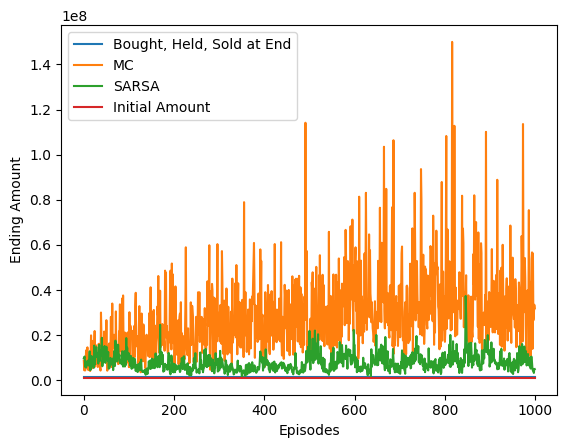

In [21]:
# MC TRAINING PLOT
mc_all_episode_rewards = []
for episode in mc_train_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    mc_all_episode_rewards.append(episode_rewards)
        

mc_final_amounts = [rewards[-1] for rewards in mc_all_episode_rewards]

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), mc_final_amounts, label='MC')
plt.plot(list(range(EPISODES)), sarsa_final_amounts, label='SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

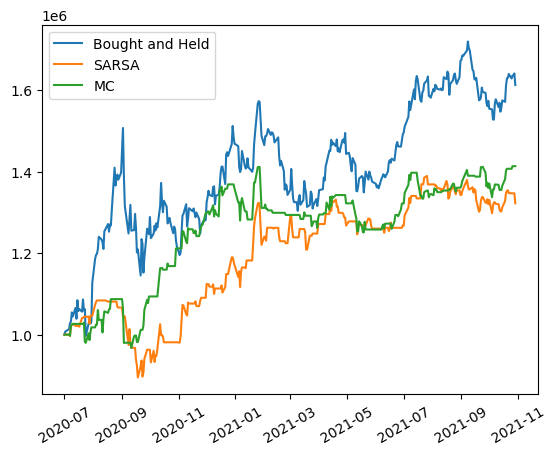

In [22]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
sarsa_test_values = sarsa_test_env.asset_memory
plt.plot(dates, sarsa_test_values, label="SARSA")
mc_test_values = mc_test_env_post.asset_memory
plt.plot(dates, mc_test_values, label="MC")
plt.xticks(rotation=30)
plt.legend()
plt.show()


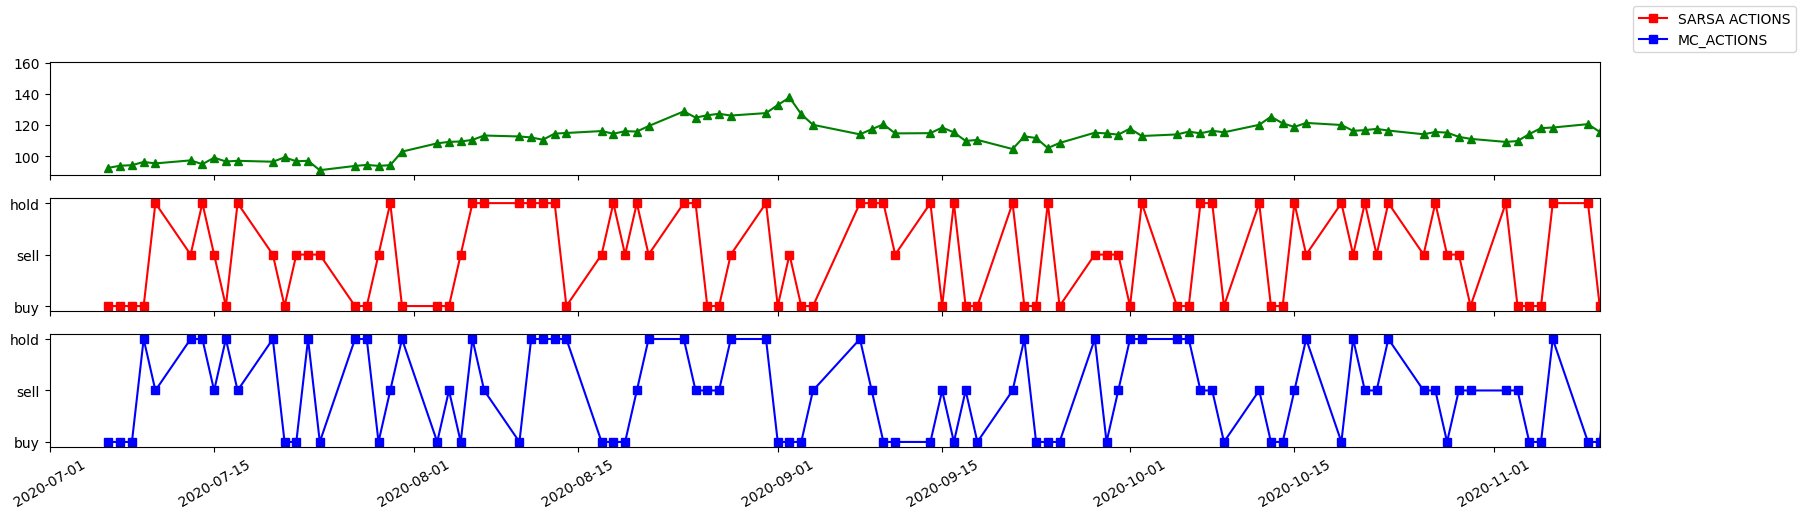

In [23]:
# ACTIONS OVER TEST
sarsa_test_actions = []
mc_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in sarsa_test_episode[0]:
    action = step[1]
    sarsa_test_actions.append(action)
for step in mc_test_episode[0]:
    action = step[1]
    mc_test_actions.append(action)
fig, axs = plt.subplots(nrows=3, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, sarsa_test_actions, marker = 's', label = 'SARSA ACTIONS', c='r')
axs[2].plot(action_dates, mc_test_actions, marker = 's', label= 'MC_ACTIONS', c='b')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])


In [18]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT